In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# Phần code này dựa trên bài viết này
# https://www.sciencedirect.com/science/article/pii/S1877050919302789

# Import the libraries

In [3]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [4]:
# Hàm vẽ mô hình miêu tả giá trị từng thuộc tính
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [5]:
# Hàm thêm cột giá trị Ma, là đường trung bình động (Moving Average) của biến giá trị Close
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [6]:
# Class này kế thừa class TimeseriesGenerator
# Nó tạo ra các batch dữ liệu được chuẩn hóa (standarized)
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [7]:
# Giải thích các thông số đầu vào của class TimeseriesGenerator
# Data: Những dữ liệu liên tiếp nhau (axis 0 được kì vọng là time dimension)
# Target: Dữ liệu tương ứng với những timesteps trong data
# Length: Độ dài của các sequences đầu vào (Hay window, look-back)
# sampling_rate: Chu kỳ của các timestep input được lấy (VD: sampling_rate=2 
# thì cách 2 ngày lấy một lần)
# stride: Chu kỳ của các timestep output được lấy (VD: stride=2 
# thì cách 2 ngày lấy một lần, hay chú Sơn nói là số bước mà cửa sổ trượt)
# start_index, end_index: Khoảng dữ liệu được dùng
# bacth_size: số lượng samples 1 batch
# ([day1, day2, day3],[day4]) là 1 sample
# [([day1, day2, day3],[day4]), ([day2, day3, day4],[day5])] là 1 batch có 
# batch_size là 5
################Xét ví dụ sau############
# from keras.preprocessing.sequence import TimeseriesGenerator
# import numpy as np
# data = np.array([[i] for i in range(50)])
# targets = np.array([[i] for i in range(50)])
# data_gen = TimeseriesGenerator(data, targets,
#                                length=10, sampling_rate=2,
#                                batch_size=2)
# assert len(data_gen) == 20
# batch_0 = data_gen[0]
# x, y = batch_0
# assert np.array_equal(x,
#                       np.array([[[0], [2], [4], [6], [8]],
#                                 [[1], [3], [5], [7], [9]]]))
# assert np.array_equal(y,
#                       np.array([[10], [11]]))
# ==>length=10 nên những dữ liệu được pick cho input có index 0->9
# Và dữ liệu đầu tiên cho output có index là 10
# sampling_rate bằng 2 nên (index thứ i) - (index thứ i - 1) = 2
# Batch_size=2 --> Mỗi batch có 2 sample mà có 41 samples --> Có 21 batches

def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [8]:
# Hàm dùng để tính mean squared error cho generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
# Các hàm tính metrics từ 2 tập thực tế và dự đoán.
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
# Vì Discriminator trong bài toán này chỉ có hai giá trị đầu ra (giống/ không giống) nên dùng hàm phân loại nhị phân
# Tìm hiểu Binary Cross Entropy là gì tại đây:
# https://ndquy.github.io/posts/loss-function-p2/#:~:text=Binary%20Cross%2DEntropy%20Loss,tr%E1%BB%8B%20%7B0%2C%201%7D.
# Cross-entropy là hàm loss được sử dụng mặc định cho bài toán phân lớp nhị phân.
# Nó được thiết kế để sử dụng với bài toán phân loại nhị phân trong đó các giá trị mục tiêu nhận một trong 2 giá trị {0, 1}.
# Trang 402
def discriminator_loss(real_output, fake_output):
    # So sách kết quả dự đoán như thể nào với 1 (đúng) (real_loss)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    # So sách kết quả dự đoán như thể nào với 1 (đúng) (real_loss)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    # Giá trị mất mát của Generator
    total_loss = real_loss + fake_loss
    return total_loss
# https://www.sciencedirect.com/science/article/pii/S1877050919302789
# Trang 403
def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    # return_sequences = True, Trả về cho lớp sau các điểm đầu ra trước đó thay vì chỉ các điểm đầu ra ở lớp cuối cùng
    # Trong mạng neural học sâu, kernel_initializer là một tham số được sử dụng để khởi tạo trọng số (weights) của các lớp (layer) trong mạng neural.
    lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
    # Batch Normalization là một lớp (layer) được sử dụng trong mạng neural học sâu để chuẩn hóa đầu ra của một lớp trước khi đưa vào lớp kế tiếp
    # Cải thiện "vanishing gradient" và "exploding gradient", đồng thời giúp mô hình hội tụ nhanh hơn
    batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    #  LeakyReLU
    # https://aicurious.io/blog/2019-09-23-cac-ham-kich-hoat-activation-function-trong-neural-networks
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs = inputs, outputs = output)
    model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
    model.summary()

    return model
# Vì sao cần hàm kích hoạt, vì nếu có hàm kích hoạt mà là các lớp nơ ron đơn thuần xếp chồng lên nhau thì kết quả đầu ra đơn 
# là một hàm tuyến tính của giá trị đầu vào --> Việc xếp chồng mà k có hàm kích hoạt là vô nghĩa
# Sigmoid (0,1). Đạo hàm đẹp nhưng dễ bằng 0 (vanishing gradient), không có trung tâm nên hội tụ khó khăn
# tanh (-1,1). Cũng bão hòa hai đầu nhưng có trung tâm (O)
# ReLu max(0, x): Sử dụng khá nhiều gần đây do tốc độ hội tụ nhanh do nó k bị bão hòa 2 đầu
# --> Rectified Linear Unit: đơn vị tuyến tính được hiệu chỉnh
# Tính toán nhanh dO công thức đơn giản
# Nhược điểm là với những node < 0 thù activation chuyển thành 0 (Dying ReLU) (*)
# Leaky ReLU dùng để khắc phục ReLU
# LeakyReLU: f(x) = 1 với x<0 và f(x)=ax + 1 với x>=0 với a nhỏ
# Thay vì trả về 0 với x < 0 thì nó cố gắng tạo ra một đường xiên nhỏ



## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # là một lớp sinh dữ liệu ngẫu nhiên nhằm giảm thiểu overfit
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    # GradientTape trả về  Context Manager, quản lý quan sát các thay đổi của mô hình và cập nhật lại trọng số
    # Nó theo dõi các quá trình tính toán của mô hình trong quá trình lan truyền thuận và cập nhật trong quá trình lan truyền ngược
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Giải thích training=True 
        # https://stackoverflow.com/questions/57320371/what-does-training-true-mean-when-calling-a-tensorflow-keras-model
        generated_prediction = generator(sequences, training=True)
        # None là cách tăng dimension. VD: [1,2,3] --> [[1],[2],[3]]
        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    # Biến history (training) và history_val (testing) lưu các thông số liên quan đến mse, rmse, mae, mape để vẽ đồ thị ở bước sau
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        # Với mỗi batch
        for sequence_batch, sequence_end_batch in dataset:
            # Tiến hành train, cập nhật weight bằng Gradient Tape cho hai mô hình G và D
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            # lấy ra giá trị của các loss function 
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        # Verbose là dài dòng, verbose=False có nghĩa là không xuất ra giá trị cụ thể
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        #Lưu các thông số vào biến history
        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "TSLA"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2010-07-07    1.093333    1.108667    0.998667    1.053333    1.053333   
6    2010-07-08    1.076000    1.168000    1.038000    1.164000    1.164000   
7    2010-07-09    1.172000    1.193333    1.103333    1.160000    1.160000   
8    2010-07-12    1.196667    1.204667    1.133333    1.136667    1.136667   
9    2010-07-13    1.159333    1.242667    1.126667    1.209333    1.209333   
...         ...         ...         ...         ...         ...         ...   
2641 2020-12-23  210.733337  217.166672  207.523331  215.326660  215.326660   
2642 2020-12-24  214.330002  222.029999  213.666672  220.589996  220.589996   
2643 2020-12-28  224.836670  227.133331  220.266663  221.229996  221.229996   
2644 2020-12-29  220.333328  223.300003  218.333328  221.996674  221.996674   
2645 2020-12-30  224.000000  232.199997  222.786667  231.593338  231.593338   

         Volume          Ma  
5     103825500    1.399867  
6     115671000    1.292000  
7      60759000    1.207067  
8      33037500    1.146267  
9      40201500    1.117600  
...         ...         ...  
2641   99519000  217.591333  
2642   68596800  219.138666  
2643   96835800  219.529999  
2644   68732400  217.442664  
2645  128538000  218.517999  

[2641 rows x 8 columns]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                840       
                                                           

Time for epoch 53 is 0.42647266387939453 sec Generator Loss: 1.2592800855636597,  Discriminator_loss: 1.0234038829803467
Time for epoch 54 is 0.4343414306640625 sec Generator Loss: 1.3040051460266113,  Discriminator_loss: 1.0024257898330688
Time for epoch 55 is 0.4404737949371338 sec Generator Loss: 1.304437279701233,  Discriminator_loss: 1.0066457986831665
Time for epoch 56 is 0.44173574447631836 sec Generator Loss: 1.2723042964935303,  Discriminator_loss: 1.0519566535949707
Time for epoch 57 is 0.4350161552429199 sec Generator Loss: 1.2469539642333984,  Discriminator_loss: 1.0466948747634888
Time for epoch 58 is 0.43155622482299805 sec Generator Loss: 1.2297661304473877,  Discriminator_loss: 1.07278573513031
Time for epoch 59 is 0.4308795928955078 sec Generator Loss: 1.2371001243591309,  Discriminator_loss: 1.0603992938995361
Time for epoch 60 is 0.42894816398620605 sec Generator Loss: 1.229491949081421,  Discriminator_loss: 1.0717252492904663
Time for epoch 61 is 0.43346524238586426

Time for epoch 122 is 0.43000197410583496 sec Generator Loss: 0.9594612121582031,  Discriminator_loss: 1.2375118732452393
Time for epoch 123 is 0.4382822513580322 sec Generator Loss: 0.9478120803833008,  Discriminator_loss: 1.251267671585083
Time for epoch 124 is 0.432819128036499 sec Generator Loss: 0.9627313613891602,  Discriminator_loss: 1.235824465751648
Time for epoch 125 is 0.43277955055236816 sec Generator Loss: 0.9572197198867798,  Discriminator_loss: 1.249925971031189
Time for epoch 126 is 0.43740177154541016 sec Generator Loss: 0.9333921670913696,  Discriminator_loss: 1.2622731924057007
Time for epoch 127 is 0.4376528263092041 sec Generator Loss: 0.9322084784507751,  Discriminator_loss: 1.2540241479873657
Time for epoch 128 is 0.43227052688598633 sec Generator Loss: 0.9326626062393188,  Discriminator_loss: 1.2596683502197266
Time for epoch 129 is 0.43207788467407227 sec Generator Loss: 0.9395360946655273,  Discriminator_loss: 1.2594903707504272
Time for epoch 130 is 0.4303433

Time for epoch 190 is 0.5268595218658447 sec Generator Loss: 0.9327660799026489,  Discriminator_loss: 1.269086241722107
Time for epoch 191 is 0.5130791664123535 sec Generator Loss: 0.9221832752227783,  Discriminator_loss: 1.275635004043579
Time for epoch 192 is 0.5484716892242432 sec Generator Loss: 0.9186572432518005,  Discriminator_loss: 1.270938515663147
Time for epoch 193 is 0.5024240016937256 sec Generator Loss: 0.9228977560997009,  Discriminator_loss: 1.2687311172485352
Time for epoch 194 is 0.5341174602508545 sec Generator Loss: 0.9220948219299316,  Discriminator_loss: 1.2709077596664429
Time for epoch 195 is 0.5509936809539795 sec Generator Loss: 0.9125669598579407,  Discriminator_loss: 1.2720023393630981
Time for epoch 196 is 0.48483777046203613 sec Generator Loss: 0.9222002625465393,  Discriminator_loss: 1.2776964902877808
Time for epoch 197 is 0.4836761951446533 sec Generator Loss: 0.9192600846290588,  Discriminator_loss: 1.2586112022399902
Time for epoch 198 is 0.4870922565

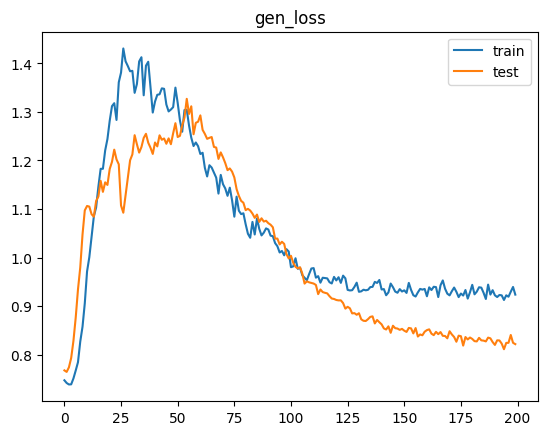

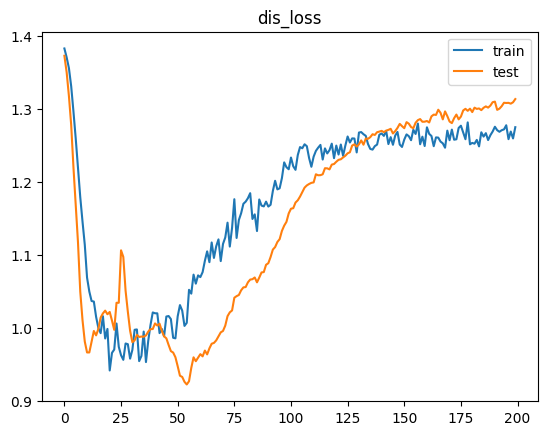

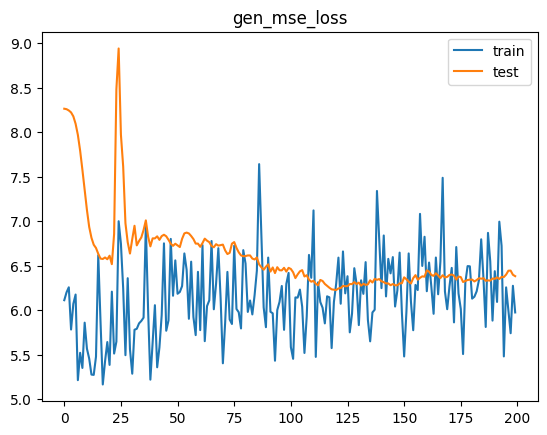

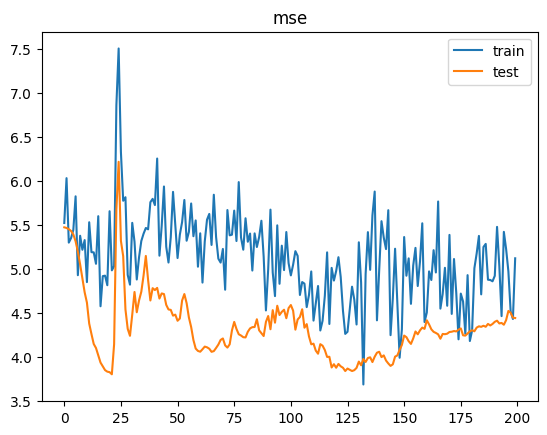

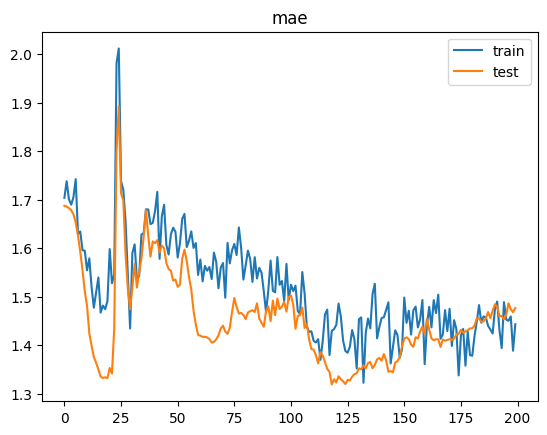

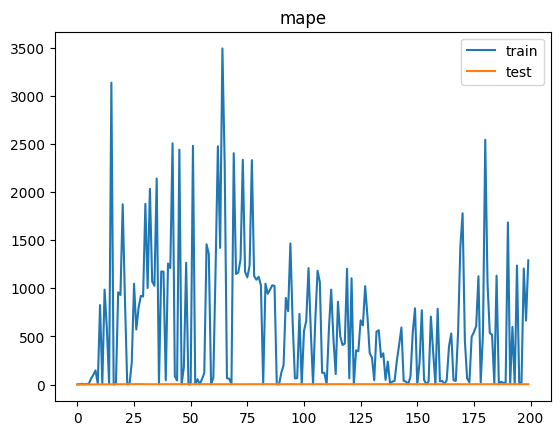

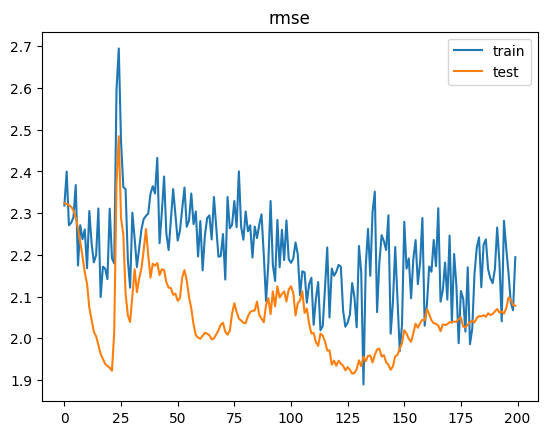

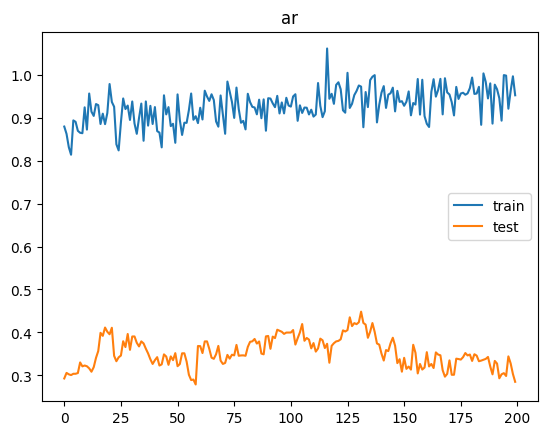

2/2 [==============================] - 0s 3ms/step


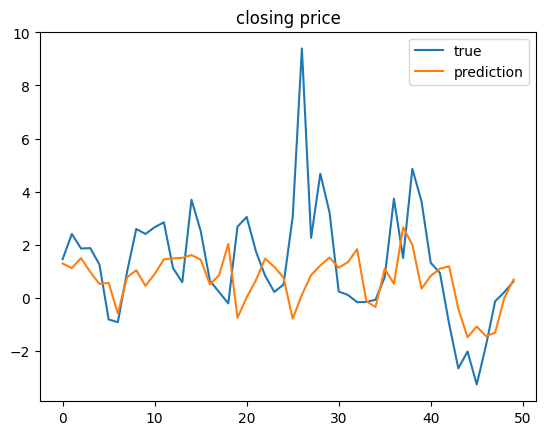

[MSE Baseline] train: 5.20897351749588  test: 3.868181586758766
Delta time with epochs = 200: 0:01:42.328945
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_5 (LSTM)  

Time for epoch 52 is 0.4680213928222656 sec Generator Loss: 1.1017857789993286,  Discriminator_loss: 1.1646374464035034
Time for epoch 53 is 0.4635958671569824 sec Generator Loss: 1.1247828006744385,  Discriminator_loss: 1.1344668865203857
Time for epoch 54 is 0.4651622772216797 sec Generator Loss: 1.135670781135559,  Discriminator_loss: 1.1222580671310425
Time for epoch 55 is 0.4701728820800781 sec Generator Loss: 1.1693408489227295,  Discriminator_loss: 1.1206495761871338
Time for epoch 56 is 0.47009992599487305 sec Generator Loss: 1.1672762632369995,  Discriminator_loss: 1.1151888370513916
Time for epoch 57 is 0.4660165309906006 sec Generator Loss: 1.1760095357894897,  Discriminator_loss: 1.1215628385543823
Time for epoch 58 is 0.4710514545440674 sec Generator Loss: 1.1385682821273804,  Discriminator_loss: 1.1385705471038818
Time for epoch 59 is 0.47021031379699707 sec Generator Loss: 1.137411117553711,  Discriminator_loss: 1.1243999004364014
Time for epoch 60 is 0.47324228286743164

Time for epoch 121 is 0.4529244899749756 sec Generator Loss: 0.9735393524169922,  Discriminator_loss: 1.217026948928833
Time for epoch 122 is 0.8074150085449219 sec Generator Loss: 0.9887359142303467,  Discriminator_loss: 1.2234688997268677
Time for epoch 123 is 0.510622501373291 sec Generator Loss: 0.997661292552948,  Discriminator_loss: 1.2279523611068726
Time for epoch 124 is 0.4832587242126465 sec Generator Loss: 0.9868131279945374,  Discriminator_loss: 1.2111179828643799
Time for epoch 125 is 0.4610915184020996 sec Generator Loss: 0.9761272668838501,  Discriminator_loss: 1.2179659605026245
Time for epoch 126 is 0.4712843894958496 sec Generator Loss: 0.9873011112213135,  Discriminator_loss: 1.226179599761963
Time for epoch 127 is 0.46807384490966797 sec Generator Loss: 0.9946733117103577,  Discriminator_loss: 1.207468032836914
Time for epoch 128 is 0.4635632038116455 sec Generator Loss: 0.9908982515335083,  Discriminator_loss: 1.2205092906951904
Time for epoch 129 is 0.469996690750

Time for epoch 189 is 0.47198915481567383 sec Generator Loss: 0.9514403939247131,  Discriminator_loss: 1.2705495357513428
Time for epoch 190 is 0.46952366828918457 sec Generator Loss: 0.9608719944953918,  Discriminator_loss: 1.2448759078979492
Time for epoch 191 is 0.4800393581390381 sec Generator Loss: 0.9527733325958252,  Discriminator_loss: 1.2686234712600708
Time for epoch 192 is 0.4559311866760254 sec Generator Loss: 0.9641425609588623,  Discriminator_loss: 1.2522801160812378
Time for epoch 193 is 0.47432541847229004 sec Generator Loss: 0.9590957760810852,  Discriminator_loss: 1.2517881393432617
Time for epoch 194 is 0.4745781421661377 sec Generator Loss: 0.9608091711997986,  Discriminator_loss: 1.2455573081970215
Time for epoch 195 is 0.4785325527191162 sec Generator Loss: 0.9354205131530762,  Discriminator_loss: 1.2741864919662476
Time for epoch 196 is 0.5024199485778809 sec Generator Loss: 0.9612962007522583,  Discriminator_loss: 1.2592508792877197
Time for epoch 197 is 0.47580

Time for epoch 257 is 0.4722607135772705 sec Generator Loss: 0.9305524230003357,  Discriminator_loss: 1.2717878818511963
Time for epoch 258 is 0.4939005374908447 sec Generator Loss: 0.9241608381271362,  Discriminator_loss: 1.2655061483383179
Time for epoch 259 is 0.4861335754394531 sec Generator Loss: 0.9276884198188782,  Discriminator_loss: 1.2555791139602661
Time for epoch 260 is 0.4843430519104004 sec Generator Loss: 0.9580581784248352,  Discriminator_loss: 1.2641537189483643
Time for epoch 261 is 0.4691917896270752 sec Generator Loss: 0.9337444305419922,  Discriminator_loss: 1.2751961946487427
Time for epoch 262 is 0.4842662811279297 sec Generator Loss: 0.9131442904472351,  Discriminator_loss: 1.291454792022705
Time for epoch 263 is 0.4688289165496826 sec Generator Loss: 0.9040509462356567,  Discriminator_loss: 1.2795825004577637
Time for epoch 264 is 0.4712953567504883 sec Generator Loss: 0.9270933866500854,  Discriminator_loss: 1.2787401676177979
Time for epoch 265 is 0.479723930

Time for epoch 325 is 0.47881174087524414 sec Generator Loss: 0.9141724705696106,  Discriminator_loss: 1.2880234718322754
Time for epoch 326 is 0.5327234268188477 sec Generator Loss: 0.9245226979255676,  Discriminator_loss: 1.2707704305648804
Time for epoch 327 is 0.4512522220611572 sec Generator Loss: 0.9248155355453491,  Discriminator_loss: 1.2896331548690796
Time for epoch 328 is 0.43540167808532715 sec Generator Loss: 0.9268872141838074,  Discriminator_loss: 1.274668574333191
Time for epoch 329 is 0.47732067108154297 sec Generator Loss: 0.9116554260253906,  Discriminator_loss: 1.296821117401123
Time for epoch 330 is 0.4396846294403076 sec Generator Loss: 0.9239740967750549,  Discriminator_loss: 1.2759921550750732
Time for epoch 331 is 0.44318509101867676 sec Generator Loss: 0.9251932501792908,  Discriminator_loss: 1.2817339897155762
Time for epoch 332 is 0.42931699752807617 sec Generator Loss: 0.8934744596481323,  Discriminator_loss: 1.2976807355880737
Time for epoch 333 is 0.43980

Time for epoch 393 is 0.4992821216583252 sec Generator Loss: 0.9164974689483643,  Discriminator_loss: 1.2889355421066284
Time for epoch 394 is 0.46703147888183594 sec Generator Loss: 0.8907139301300049,  Discriminator_loss: 1.3081783056259155
Time for epoch 395 is 0.4687621593475342 sec Generator Loss: 0.8894568681716919,  Discriminator_loss: 1.2987219095230103
Time for epoch 396 is 0.46637606620788574 sec Generator Loss: 0.9187976717948914,  Discriminator_loss: 1.2869815826416016
Time for epoch 397 is 0.4757726192474365 sec Generator Loss: 0.8832254409790039,  Discriminator_loss: 1.301421046257019
Time for epoch 398 is 0.4713468551635742 sec Generator Loss: 0.8966318964958191,  Discriminator_loss: 1.287923812866211
Time for epoch 399 is 0.4718163013458252 sec Generator Loss: 0.9088678359985352,  Discriminator_loss: 1.2897852659225464
Time for epoch 400 is 0.4732198715209961 sec Generator Loss: 0.8979542255401611,  Discriminator_loss: 1.295844554901123
Time for epoch 401 is 0.469192504

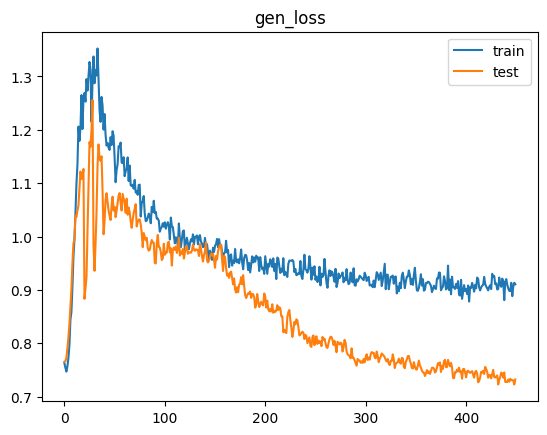

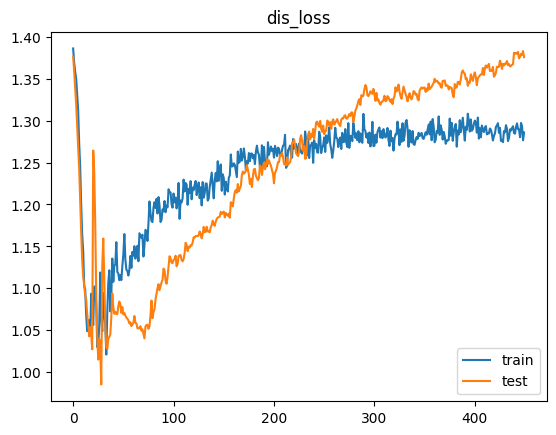

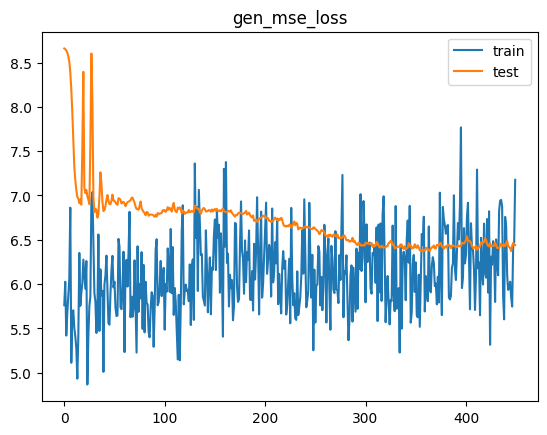

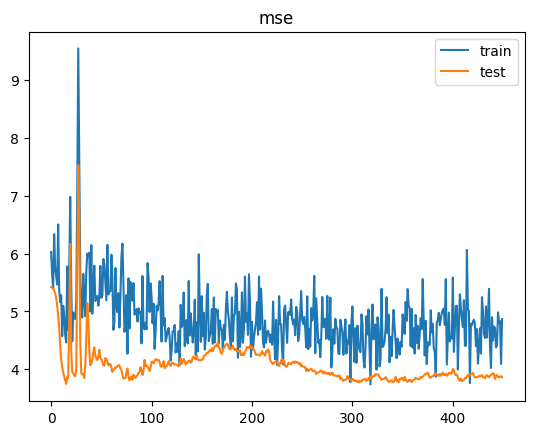

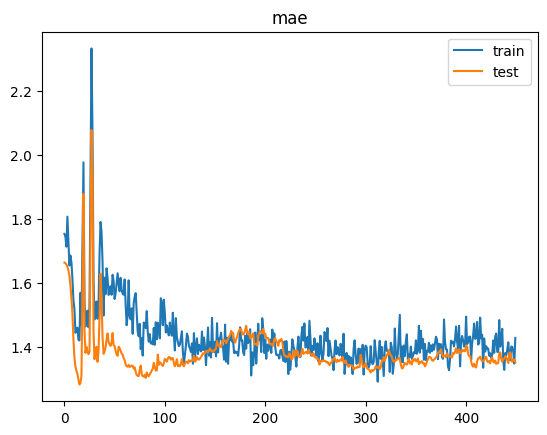

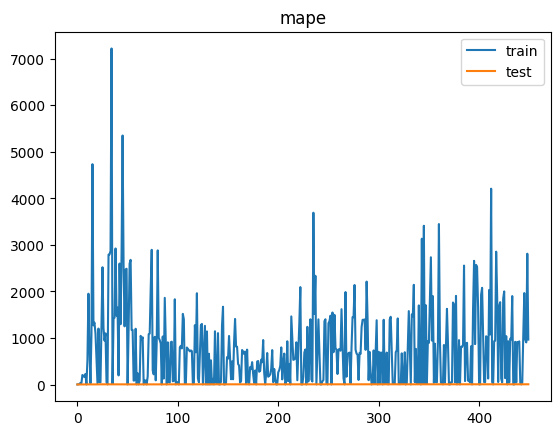

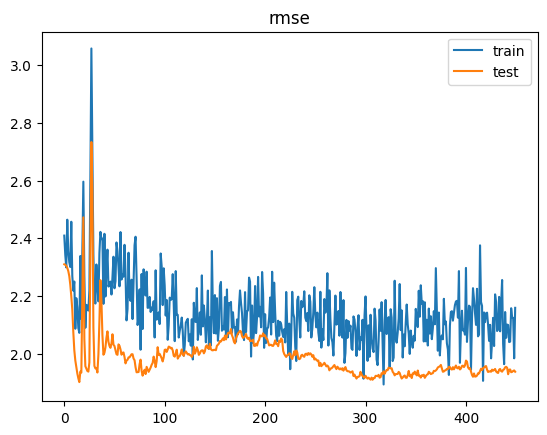

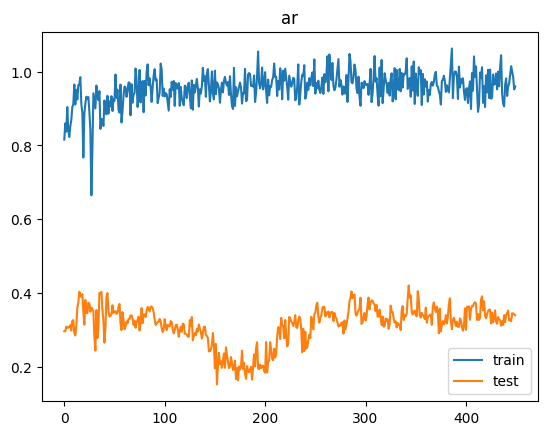

2/2 [==============================] - 0s 3ms/step


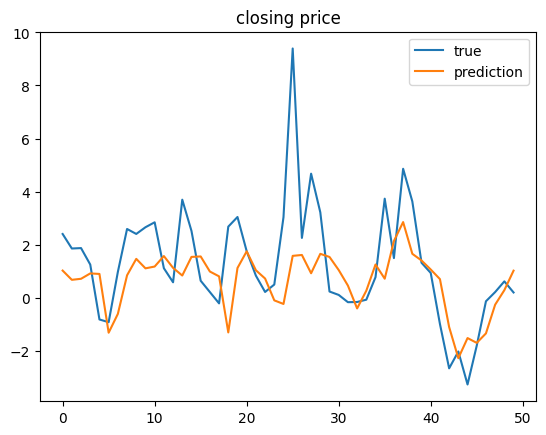

[MSE Baseline] train: 3.796574372131119  test: 3.7469059248471765
Delta time with epochs = 450: 0:03:48.320487
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_7 (LSTM)

Time for epoch 52 is 0.43938136100769043 sec Generator Loss: 1.188300371170044,  Discriminator_loss: 1.0694876909255981
Time for epoch 53 is 0.43118762969970703 sec Generator Loss: 1.1387708187103271,  Discriminator_loss: 1.113716959953308
Time for epoch 54 is 0.44013381004333496 sec Generator Loss: 1.1835254430770874,  Discriminator_loss: 1.0719819068908691
Time for epoch 55 is 0.43964409828186035 sec Generator Loss: 1.1325374841690063,  Discriminator_loss: 1.0986384153366089
Time for epoch 56 is 0.4425513744354248 sec Generator Loss: 1.1521189212799072,  Discriminator_loss: 1.0806127786636353
Time for epoch 57 is 0.43541979789733887 sec Generator Loss: 1.1533256769180298,  Discriminator_loss: 1.0986720323562622
Time for epoch 58 is 0.43645715713500977 sec Generator Loss: 1.1295485496520996,  Discriminator_loss: 1.099041223526001
Time for epoch 59 is 0.4371185302734375 sec Generator Loss: 1.140146255493164,  Discriminator_loss: 1.0998406410217285
Time for epoch 60 is 0.431094646453857

Time for epoch 121 is 0.4725213050842285 sec Generator Loss: 0.9686188697814941,  Discriminator_loss: 1.2237008810043335
Time for epoch 122 is 0.48241138458251953 sec Generator Loss: 0.966169536113739,  Discriminator_loss: 1.2321867942810059
Time for epoch 123 is 0.4821794033050537 sec Generator Loss: 0.9912276864051819,  Discriminator_loss: 1.2187399864196777
Time for epoch 124 is 0.48018836975097656 sec Generator Loss: 0.9712141156196594,  Discriminator_loss: 1.2251191139221191
Time for epoch 125 is 0.473590612411499 sec Generator Loss: 0.9663203358650208,  Discriminator_loss: 1.2335705757141113
Time for epoch 126 is 0.4752810001373291 sec Generator Loss: 0.9878472685813904,  Discriminator_loss: 1.2152341604232788
Time for epoch 127 is 0.47980594635009766 sec Generator Loss: 0.971270740032196,  Discriminator_loss: 1.2201262712478638
Time for epoch 128 is 0.47256922721862793 sec Generator Loss: 0.9739493131637573,  Discriminator_loss: 1.2237297296524048
Time for epoch 129 is 0.4853999

Time for epoch 189 is 0.4972817897796631 sec Generator Loss: 0.9289270043373108,  Discriminator_loss: 1.2664926052093506
Time for epoch 190 is 0.496135950088501 sec Generator Loss: 0.9214327931404114,  Discriminator_loss: 1.2730722427368164
Time for epoch 191 is 0.49477720260620117 sec Generator Loss: 0.9111874103546143,  Discriminator_loss: 1.2775132656097412
Time for epoch 192 is 0.4989004135131836 sec Generator Loss: 0.9204039573669434,  Discriminator_loss: 1.2673345804214478
Time for epoch 193 is 0.5011467933654785 sec Generator Loss: 0.9228206872940063,  Discriminator_loss: 1.2642409801483154
Time for epoch 194 is 0.4934053421020508 sec Generator Loss: 0.9252143502235413,  Discriminator_loss: 1.2703293561935425
Time for epoch 195 is 0.4980778694152832 sec Generator Loss: 0.9259546995162964,  Discriminator_loss: 1.2717175483703613
Time for epoch 196 is 0.50459885597229 sec Generator Loss: 0.9114905595779419,  Discriminator_loss: 1.274462342262268
Time for epoch 197 is 0.49462199211

Time for epoch 257 is 0.4536128044128418 sec Generator Loss: 0.919681966304779,  Discriminator_loss: 1.2756447792053223
Time for epoch 258 is 0.4447617530822754 sec Generator Loss: 0.8994603157043457,  Discriminator_loss: 1.2812397480010986
Time for epoch 259 is 0.4727141857147217 sec Generator Loss: 0.9167124032974243,  Discriminator_loss: 1.2750064134597778
Time for epoch 260 is 0.4559154510498047 sec Generator Loss: 0.9141116142272949,  Discriminator_loss: 1.2859032154083252
Time for epoch 261 is 0.4596893787384033 sec Generator Loss: 0.9025825262069702,  Discriminator_loss: 1.2721126079559326
Time for epoch 262 is 0.5661201477050781 sec Generator Loss: 0.9054462313652039,  Discriminator_loss: 1.2833740711212158
Time for epoch 263 is 0.5410501956939697 sec Generator Loss: 0.9186974763870239,  Discriminator_loss: 1.2533091306686401
Time for epoch 264 is 0.5109231472015381 sec Generator Loss: 0.906896710395813,  Discriminator_loss: 1.2705988883972168
Time for epoch 265 is 0.5107634067

Time for epoch 325 is 0.496762752532959 sec Generator Loss: 0.899311900138855,  Discriminator_loss: 1.2852851152420044
Time for epoch 326 is 0.49169015884399414 sec Generator Loss: 0.8978539109230042,  Discriminator_loss: 1.2731877565383911
Time for epoch 327 is 0.4824378490447998 sec Generator Loss: 0.9224667549133301,  Discriminator_loss: 1.2691329717636108
Time for epoch 328 is 0.4819180965423584 sec Generator Loss: 0.9255707859992981,  Discriminator_loss: 1.2712899446487427
Time for epoch 329 is 0.47594594955444336 sec Generator Loss: 0.9076440930366516,  Discriminator_loss: 1.2702090740203857
Time for epoch 330 is 0.47711896896362305 sec Generator Loss: 0.9303051233291626,  Discriminator_loss: 1.2615197896957397
Time for epoch 331 is 0.49504637718200684 sec Generator Loss: 0.8934395909309387,  Discriminator_loss: 1.2869255542755127
Time for epoch 332 is 0.5510416030883789 sec Generator Loss: 0.8876426815986633,  Discriminator_loss: 1.3016773462295532
Time for epoch 333 is 0.476331

Time for epoch 393 is 0.45979976654052734 sec Generator Loss: 0.9200359582901001,  Discriminator_loss: 1.26974618434906
Time for epoch 394 is 0.44998931884765625 sec Generator Loss: 0.9036040306091309,  Discriminator_loss: 1.2707659006118774
Time for epoch 395 is 0.4694550037384033 sec Generator Loss: 0.9070414304733276,  Discriminator_loss: 1.2801240682601929
Time for epoch 396 is 0.4783949851989746 sec Generator Loss: 0.9088022112846375,  Discriminator_loss: 1.2803479433059692
Time for epoch 397 is 0.48759961128234863 sec Generator Loss: 0.9254883527755737,  Discriminator_loss: 1.2774077653884888
Time for epoch 398 is 0.4651970863342285 sec Generator Loss: 0.9194971919059753,  Discriminator_loss: 1.2769367694854736
Time for epoch 399 is 0.45615458488464355 sec Generator Loss: 0.9276202917098999,  Discriminator_loss: 1.2687666416168213
Time for epoch 400 is 0.4735598564147949 sec Generator Loss: 0.9176384210586548,  Discriminator_loss: 1.265246868133545
Time for epoch 401 is 0.4820713

Time for epoch 461 is 0.5173392295837402 sec Generator Loss: 0.8990398049354553,  Discriminator_loss: 1.2673057317733765
Time for epoch 462 is 0.531043529510498 sec Generator Loss: 0.9162939786911011,  Discriminator_loss: 1.270967721939087
Time for epoch 463 is 0.5434989929199219 sec Generator Loss: 0.9256699085235596,  Discriminator_loss: 1.2638769149780273
Time for epoch 464 is 0.45062756538391113 sec Generator Loss: 0.9323086142539978,  Discriminator_loss: 1.2666934728622437
Time for epoch 465 is 0.43972063064575195 sec Generator Loss: 0.9043659567832947,  Discriminator_loss: 1.286452054977417
Time for epoch 466 is 0.42896318435668945 sec Generator Loss: 0.9229127168655396,  Discriminator_loss: 1.27511727809906
Time for epoch 467 is 0.4335486888885498 sec Generator Loss: 0.9137642979621887,  Discriminator_loss: 1.2676559686660767
Time for epoch 468 is 0.4375128746032715 sec Generator Loss: 0.9126551747322083,  Discriminator_loss: 1.2733854055404663
Time for epoch 469 is 0.4339373111

Time for epoch 529 is 0.508969783782959 sec Generator Loss: 0.921413242816925,  Discriminator_loss: 1.2721322774887085
Time for epoch 530 is 0.5024528503417969 sec Generator Loss: 0.9112594127655029,  Discriminator_loss: 1.280914545059204
Time for epoch 531 is 0.5336437225341797 sec Generator Loss: 0.8991963267326355,  Discriminator_loss: 1.2847154140472412
Time for epoch 532 is 0.6362745761871338 sec Generator Loss: 0.9089910387992859,  Discriminator_loss: 1.2756989002227783
Time for epoch 533 is 0.5530397891998291 sec Generator Loss: 0.9243404865264893,  Discriminator_loss: 1.2671773433685303
Time for epoch 534 is 0.526576042175293 sec Generator Loss: 0.9314485192298889,  Discriminator_loss: 1.2767339944839478
Time for epoch 535 is 0.5347154140472412 sec Generator Loss: 0.9134629368782043,  Discriminator_loss: 1.2892545461654663
Time for epoch 536 is 0.5450460910797119 sec Generator Loss: 0.9034475088119507,  Discriminator_loss: 1.2793207168579102
Time for epoch 537 is 0.523836135864

Time for epoch 597 is 0.448028564453125 sec Generator Loss: 0.929155170917511,  Discriminator_loss: 1.2796199321746826
Time for epoch 598 is 0.4533498287200928 sec Generator Loss: 0.9406246542930603,  Discriminator_loss: 1.2595914602279663
Time for epoch 599 is 0.4497683048248291 sec Generator Loss: 0.9235635995864868,  Discriminator_loss: 1.2735493183135986
Time for epoch 600 is 0.4777250289916992 sec Generator Loss: 0.9256437420845032,  Discriminator_loss: 1.2789045572280884
Time for epoch 601 is 0.44962453842163086 sec Generator Loss: 0.9302692413330078,  Discriminator_loss: 1.2708373069763184
Time for epoch 602 is 0.4574117660522461 sec Generator Loss: 0.9209718704223633,  Discriminator_loss: 1.2827757596969604
Time for epoch 603 is 0.4657633304595947 sec Generator Loss: 0.923893928527832,  Discriminator_loss: 1.2651129961013794
Time for epoch 604 is 0.4496030807495117 sec Generator Loss: 0.9304046034812927,  Discriminator_loss: 1.2819535732269287
Time for epoch 605 is 0.4511072635

Time for epoch 665 is 0.4749891757965088 sec Generator Loss: 0.9272737503051758,  Discriminator_loss: 1.280909538269043
Time for epoch 666 is 0.5250029563903809 sec Generator Loss: 0.9253262281417847,  Discriminator_loss: 1.2706866264343262
Time for epoch 667 is 0.49460864067077637 sec Generator Loss: 0.9432268142700195,  Discriminator_loss: 1.2660274505615234
Time for epoch 668 is 0.4962329864501953 sec Generator Loss: 0.9230366349220276,  Discriminator_loss: 1.2784450054168701
Time for epoch 669 is 0.4770925045013428 sec Generator Loss: 0.9172520041465759,  Discriminator_loss: 1.2872644662857056
Time for epoch 670 is 0.4820840358734131 sec Generator Loss: 0.9394645094871521,  Discriminator_loss: 1.2718948125839233
Time for epoch 671 is 0.476703405380249 sec Generator Loss: 0.9361295104026794,  Discriminator_loss: 1.254723310470581
Time for epoch 672 is 0.4853956699371338 sec Generator Loss: 0.9231077432632446,  Discriminator_loss: 1.2880088090896606
Time for epoch 673 is 0.4791080951

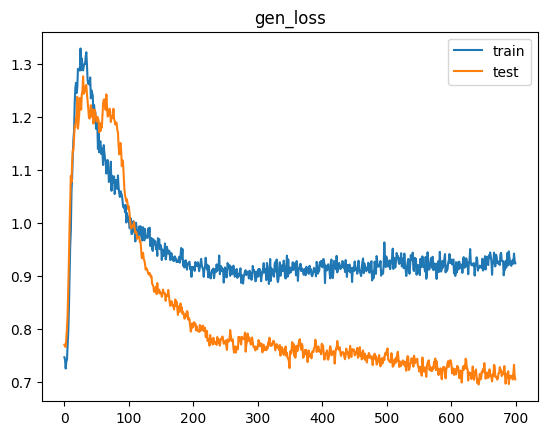

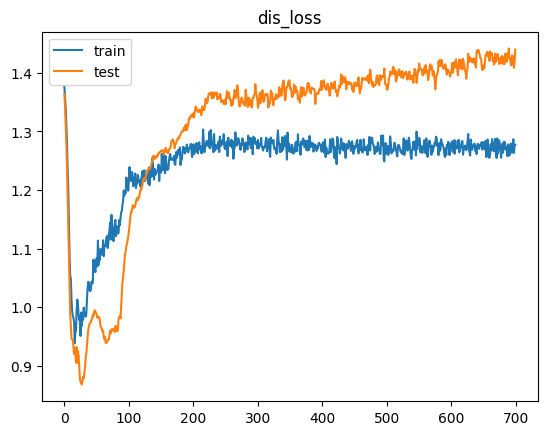

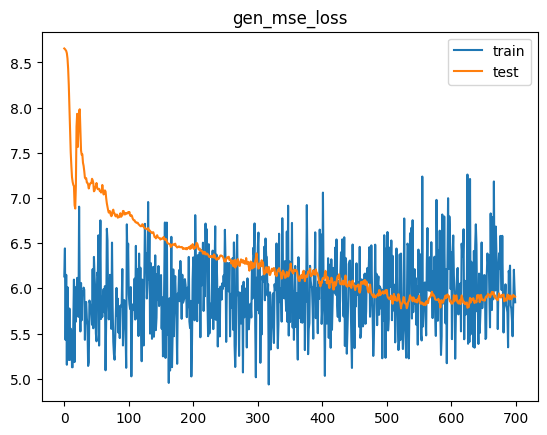

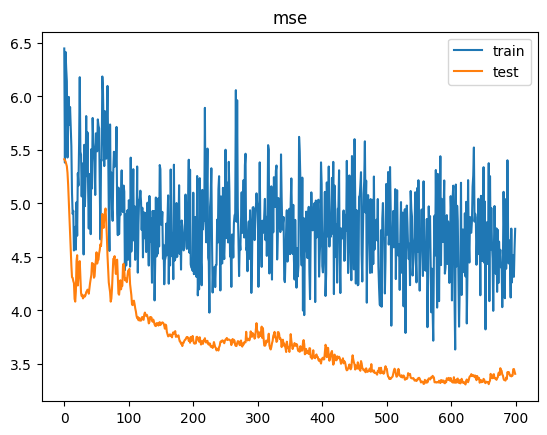

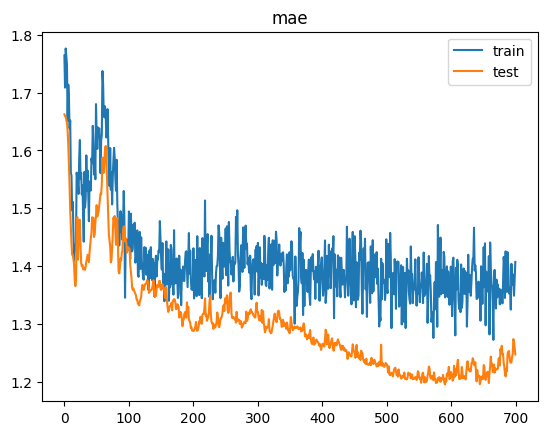

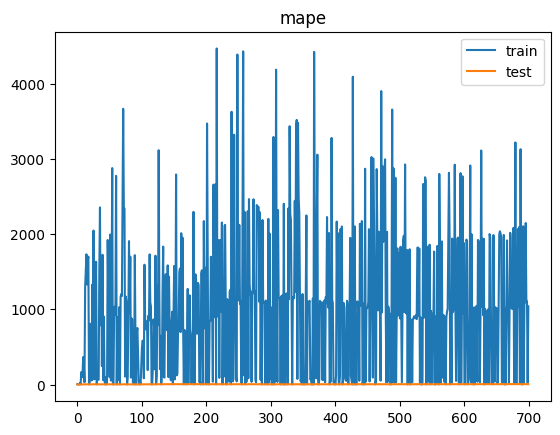

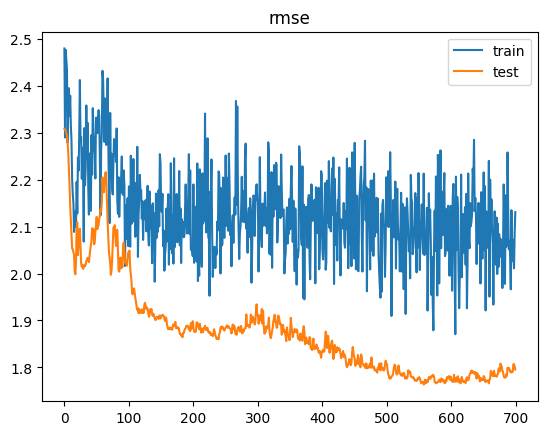

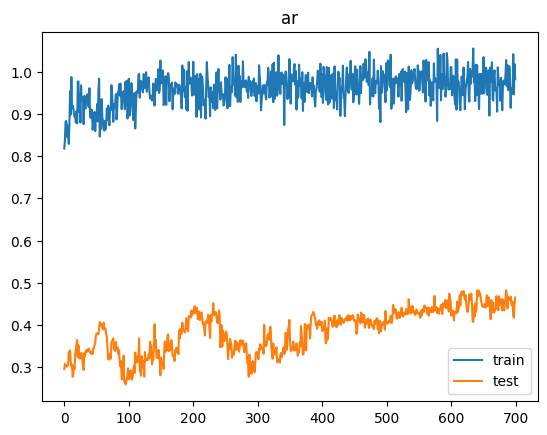

2/2 [==============================] - 0s 3ms/step


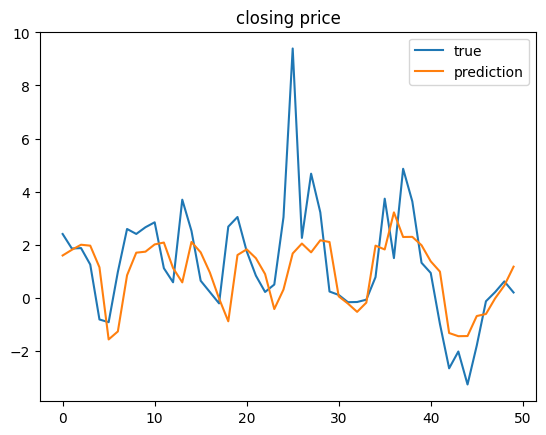

[MSE Baseline] train: 4.72480315790311  test: 3.7469059248471765
Delta time with epochs = 700: 0:05:45.762484


In [21]:
for epochs in [200, 450, 700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_9 (LSTM)               (None, 10)                840       
                                                           

Time for epoch 53 is 0.4819602966308594 sec Generator Loss: 1.4291733503341675,  Discriminator_loss: 0.9771104454994202
Time for epoch 54 is 0.47353315353393555 sec Generator Loss: 1.4447115659713745,  Discriminator_loss: 0.9618931412696838
Time for epoch 55 is 0.4725837707519531 sec Generator Loss: 1.4344658851623535,  Discriminator_loss: 0.9546489119529724
Time for epoch 56 is 0.49485278129577637 sec Generator Loss: 1.451287031173706,  Discriminator_loss: 0.9658660888671875
Time for epoch 57 is 0.4765658378601074 sec Generator Loss: 1.4277621507644653,  Discriminator_loss: 0.9577187895774841
Time for epoch 58 is 0.4777841567993164 sec Generator Loss: 1.4584892988204956,  Discriminator_loss: 0.947952151298523
Time for epoch 59 is 0.4753532409667969 sec Generator Loss: 1.3968240022659302,  Discriminator_loss: 0.9897075295448303
Time for epoch 60 is 0.45641016960144043 sec Generator Loss: 1.4105315208435059,  Discriminator_loss: 0.9786716103553772
Time for epoch 61 is 0.4612689018249511

Time for epoch 122 is 0.471480131149292 sec Generator Loss: 1.1487162113189697,  Discriminator_loss: 1.1288282871246338
Time for epoch 123 is 0.5601530075073242 sec Generator Loss: 1.1708998680114746,  Discriminator_loss: 1.113020896911621
Time for epoch 124 is 0.5135378837585449 sec Generator Loss: 1.16473388671875,  Discriminator_loss: 1.1289881467819214
Time for epoch 125 is 0.5334246158599854 sec Generator Loss: 1.1770206689834595,  Discriminator_loss: 1.1072243452072144
Time for epoch 126 is 0.504662036895752 sec Generator Loss: 1.1640115976333618,  Discriminator_loss: 1.1275744438171387
Time for epoch 127 is 0.5127103328704834 sec Generator Loss: 1.1223064661026,  Discriminator_loss: 1.1427451372146606
Time for epoch 128 is 0.5046465396881104 sec Generator Loss: 1.1475675106048584,  Discriminator_loss: 1.137071132659912
Time for epoch 129 is 0.47405385971069336 sec Generator Loss: 1.1424167156219482,  Discriminator_loss: 1.1271002292633057
Time for epoch 130 is 0.4784650802612304

Time for epoch 190 is 0.4718046188354492 sec Generator Loss: 1.0077118873596191,  Discriminator_loss: 1.2434844970703125
Time for epoch 191 is 0.47733020782470703 sec Generator Loss: 0.9826825857162476,  Discriminator_loss: 1.2572054862976074
Time for epoch 192 is 0.47065043449401855 sec Generator Loss: 0.9988318681716919,  Discriminator_loss: 1.2344173192977905
Time for epoch 193 is 0.475999116897583 sec Generator Loss: 0.987765908241272,  Discriminator_loss: 1.2525147199630737
Time for epoch 194 is 0.4704904556274414 sec Generator Loss: 0.9877896308898926,  Discriminator_loss: 1.24394690990448
Time for epoch 195 is 0.4755878448486328 sec Generator Loss: 0.9819543361663818,  Discriminator_loss: 1.2312368154525757
Time for epoch 196 is 0.47241973876953125 sec Generator Loss: 0.9587897062301636,  Discriminator_loss: 1.2628153562545776
Time for epoch 197 is 0.48233652114868164 sec Generator Loss: 0.9685109853744507,  Discriminator_loss: 1.2261962890625
Time for epoch 198 is 0.50186514854

Time for epoch 258 is 0.5059454441070557 sec Generator Loss: 0.9383373856544495,  Discriminator_loss: 1.264832615852356
Time for epoch 259 is 0.4761216640472412 sec Generator Loss: 0.9488679766654968,  Discriminator_loss: 1.2616609334945679
Time for epoch 260 is 0.4780266284942627 sec Generator Loss: 0.9324847459793091,  Discriminator_loss: 1.264284372329712
Time for epoch 261 is 0.4723072052001953 sec Generator Loss: 0.9254024028778076,  Discriminator_loss: 1.2826181650161743
Time for epoch 262 is 0.47374939918518066 sec Generator Loss: 0.9249569773674011,  Discriminator_loss: 1.2746890783309937
Time for epoch 263 is 0.46985459327697754 sec Generator Loss: 0.9478572010993958,  Discriminator_loss: 1.2676734924316406
Time for epoch 264 is 0.4750809669494629 sec Generator Loss: 0.9448977112770081,  Discriminator_loss: 1.2614202499389648
Time for epoch 265 is 0.4721550941467285 sec Generator Loss: 0.9392068386077881,  Discriminator_loss: 1.2682785987854004
Time for epoch 266 is 0.47690749

Time for epoch 326 is 0.5363442897796631 sec Generator Loss: 0.9159722328186035,  Discriminator_loss: 1.2724159955978394
Time for epoch 327 is 0.5089614391326904 sec Generator Loss: 0.9270366430282593,  Discriminator_loss: 1.2851980924606323
Time for epoch 328 is 0.5140292644500732 sec Generator Loss: 0.9301814436912537,  Discriminator_loss: 1.2755144834518433
Time for epoch 329 is 0.5231187343597412 sec Generator Loss: 0.9432328939437866,  Discriminator_loss: 1.271413803100586
Time for epoch 330 is 0.525078296661377 sec Generator Loss: 0.9317747354507446,  Discriminator_loss: 1.2761131525039673
Time for epoch 331 is 0.5336780548095703 sec Generator Loss: 0.9276251792907715,  Discriminator_loss: 1.2877238988876343
Time for epoch 332 is 0.5735478401184082 sec Generator Loss: 0.9180573225021362,  Discriminator_loss: 1.2782888412475586
Time for epoch 333 is 0.5211584568023682 sec Generator Loss: 0.9174385070800781,  Discriminator_loss: 1.2701557874679565
Time for epoch 334 is 0.5440275669

Time for epoch 394 is 0.46980762481689453 sec Generator Loss: 0.9301545023918152,  Discriminator_loss: 1.2654392719268799
Time for epoch 395 is 0.4694938659667969 sec Generator Loss: 0.9229646325111389,  Discriminator_loss: 1.2745189666748047
Time for epoch 396 is 0.46260809898376465 sec Generator Loss: 0.9128920435905457,  Discriminator_loss: 1.288044810295105
Time for epoch 397 is 0.4660940170288086 sec Generator Loss: 0.9253747463226318,  Discriminator_loss: 1.2804319858551025
Time for epoch 398 is 0.4865570068359375 sec Generator Loss: 0.9187974333763123,  Discriminator_loss: 1.295210361480713
Time for epoch 399 is 0.4701666831970215 sec Generator Loss: 0.9212995171546936,  Discriminator_loss: 1.2835270166397095
Time for epoch 400 is 0.4732811450958252 sec Generator Loss: 0.9228723645210266,  Discriminator_loss: 1.266243815422058
Time for epoch 401 is 0.47686767578125 sec Generator Loss: 0.9333993792533875,  Discriminator_loss: 1.2766485214233398
Time for epoch 402 is 0.47615766525

Time for epoch 462 is 0.47484803199768066 sec Generator Loss: 0.9124897122383118,  Discriminator_loss: 1.2836451530456543
Time for epoch 463 is 0.47388792037963867 sec Generator Loss: 0.9126136302947998,  Discriminator_loss: 1.2760560512542725
Time for epoch 464 is 0.4739036560058594 sec Generator Loss: 0.9072268605232239,  Discriminator_loss: 1.285369873046875
Time for epoch 465 is 0.4736649990081787 sec Generator Loss: 0.9205045104026794,  Discriminator_loss: 1.2780433893203735
Time for epoch 466 is 0.475017786026001 sec Generator Loss: 0.9054222702980042,  Discriminator_loss: 1.2657630443572998
Time for epoch 467 is 0.4749906063079834 sec Generator Loss: 0.9182988405227661,  Discriminator_loss: 1.2777856588363647
Time for epoch 468 is 0.4801948070526123 sec Generator Loss: 0.9092633724212646,  Discriminator_loss: 1.2831748723983765
Time for epoch 469 is 0.47005152702331543 sec Generator Loss: 0.9123470783233643,  Discriminator_loss: 1.2880305051803589
Time for epoch 470 is 0.4779207

Time for epoch 530 is 0.4279632568359375 sec Generator Loss: 0.9089184999465942,  Discriminator_loss: 1.2857146263122559
Time for epoch 531 is 0.42998433113098145 sec Generator Loss: 0.9047799110412598,  Discriminator_loss: 1.284608006477356
Time for epoch 532 is 0.4729456901550293 sec Generator Loss: 0.9175237417221069,  Discriminator_loss: 1.28658926486969
Time for epoch 533 is 0.46563220024108887 sec Generator Loss: 0.9156151413917542,  Discriminator_loss: 1.2783896923065186
Time for epoch 534 is 0.46280479431152344 sec Generator Loss: 0.9032840728759766,  Discriminator_loss: 1.290251612663269
Time for epoch 535 is 0.4650712013244629 sec Generator Loss: 0.9099071621894836,  Discriminator_loss: 1.281209945678711
Time for epoch 536 is 0.4768209457397461 sec Generator Loss: 0.905021607875824,  Discriminator_loss: 1.2890987396240234
Time for epoch 537 is 0.48319125175476074 sec Generator Loss: 0.9158378839492798,  Discriminator_loss: 1.270654559135437
Time for epoch 538 is 0.46351575851

Time for epoch 598 is 0.4748878479003906 sec Generator Loss: 0.9241870641708374,  Discriminator_loss: 1.280997395515442
Time for epoch 599 is 0.4501020908355713 sec Generator Loss: 0.9007735252380371,  Discriminator_loss: 1.2888548374176025
Time for epoch 600 is 0.4329111576080322 sec Generator Loss: 0.8956584334373474,  Discriminator_loss: 1.288807988166809
Time for epoch 601 is 0.437422513961792 sec Generator Loss: 0.9180861711502075,  Discriminator_loss: 1.2694091796875
Time for epoch 602 is 0.4575843811035156 sec Generator Loss: 0.9032965302467346,  Discriminator_loss: 1.2728899717330933
Time for epoch 603 is 0.43396520614624023 sec Generator Loss: 0.9073294401168823,  Discriminator_loss: 1.285829782485962
Time for epoch 604 is 0.43323397636413574 sec Generator Loss: 0.9031097888946533,  Discriminator_loss: 1.2959556579589844
Time for epoch 605 is 0.46364331245422363 sec Generator Loss: 0.9136606454849243,  Discriminator_loss: 1.2927736043930054
Time for epoch 606 is 0.426479816436

Time for epoch 666 is 0.4338531494140625 sec Generator Loss: 0.8974751234054565,  Discriminator_loss: 1.291414737701416
Time for epoch 667 is 0.4288468360900879 sec Generator Loss: 0.9093748331069946,  Discriminator_loss: 1.2892333269119263
Time for epoch 668 is 0.43341541290283203 sec Generator Loss: 0.8979479074478149,  Discriminator_loss: 1.2858102321624756
Time for epoch 669 is 0.4300248622894287 sec Generator Loss: 0.9197287559509277,  Discriminator_loss: 1.2666841745376587
Time for epoch 670 is 0.4227898120880127 sec Generator Loss: 0.9234405159950256,  Discriminator_loss: 1.2827503681182861
Time for epoch 671 is 0.4297323226928711 sec Generator Loss: 0.9192756414413452,  Discriminator_loss: 1.2905017137527466
Time for epoch 672 is 0.4448707103729248 sec Generator Loss: 0.9091640710830688,  Discriminator_loss: 1.2854821681976318
Time for epoch 673 is 0.4302074909210205 sec Generator Loss: 0.9064267873764038,  Discriminator_loss: 1.2939332723617554
Time for epoch 674 is 0.43469595

Time for epoch 734 is 0.432858943939209 sec Generator Loss: 0.9042314291000366,  Discriminator_loss: 1.2875945568084717
Time for epoch 735 is 0.4315464496612549 sec Generator Loss: 0.902484655380249,  Discriminator_loss: 1.2941055297851562
Time for epoch 736 is 0.4334702491760254 sec Generator Loss: 0.9088643193244934,  Discriminator_loss: 1.2759629487991333
Time for epoch 737 is 0.43930745124816895 sec Generator Loss: 0.9321820139884949,  Discriminator_loss: 1.275976300239563
Time for epoch 738 is 0.432997465133667 sec Generator Loss: 0.9359622597694397,  Discriminator_loss: 1.2674944400787354
Time for epoch 739 is 0.42789602279663086 sec Generator Loss: 0.9211498498916626,  Discriminator_loss: 1.2725157737731934
Time for epoch 740 is 0.42162084579467773 sec Generator Loss: 0.9309198260307312,  Discriminator_loss: 1.2722055912017822
Time for epoch 741 is 0.429398775100708 sec Generator Loss: 0.8960137963294983,  Discriminator_loss: 1.2845200300216675
Time for epoch 742 is 0.4236879348

Time for epoch 802 is 0.4271364212036133 sec Generator Loss: 0.9328324198722839,  Discriminator_loss: 1.2746931314468384
Time for epoch 803 is 0.4411599636077881 sec Generator Loss: 0.9179489016532898,  Discriminator_loss: 1.273918628692627
Time for epoch 804 is 0.4272623062133789 sec Generator Loss: 0.9036451578140259,  Discriminator_loss: 1.2804642915725708
Time for epoch 805 is 0.42950940132141113 sec Generator Loss: 0.9267989993095398,  Discriminator_loss: 1.2484805583953857
Time for epoch 806 is 0.43258190155029297 sec Generator Loss: 0.943470299243927,  Discriminator_loss: 1.2651352882385254
Time for epoch 807 is 0.43413329124450684 sec Generator Loss: 0.9195419549942017,  Discriminator_loss: 1.2790555953979492
Time for epoch 808 is 0.4256608486175537 sec Generator Loss: 0.9247016906738281,  Discriminator_loss: 1.2864457368850708
Time for epoch 809 is 0.42700934410095215 sec Generator Loss: 0.9263092875480652,  Discriminator_loss: 1.276323914527893
Time for epoch 810 is 0.4366633

Time for epoch 870 is 0.42676591873168945 sec Generator Loss: 0.9288095831871033,  Discriminator_loss: 1.271652340888977
Time for epoch 871 is 0.42391061782836914 sec Generator Loss: 0.9093124270439148,  Discriminator_loss: 1.2905175685882568
Time for epoch 872 is 0.42737627029418945 sec Generator Loss: 0.9260391592979431,  Discriminator_loss: 1.270672082901001
Time for epoch 873 is 0.43108677864074707 sec Generator Loss: 0.9130240678787231,  Discriminator_loss: 1.28329598903656
Time for epoch 874 is 0.4342842102050781 sec Generator Loss: 0.9197813868522644,  Discriminator_loss: 1.2852113246917725
Time for epoch 875 is 0.4292457103729248 sec Generator Loss: 0.8977739214897156,  Discriminator_loss: 1.295303225517273
Time for epoch 876 is 0.43521809577941895 sec Generator Loss: 0.9111191034317017,  Discriminator_loss: 1.3031436204910278
Time for epoch 877 is 0.43517065048217773 sec Generator Loss: 0.9015393257141113,  Discriminator_loss: 1.291426658630371
Time for epoch 878 is 0.43798351

Time for epoch 938 is 0.4351940155029297 sec Generator Loss: 0.9070302844047546,  Discriminator_loss: 1.283801555633545
Time for epoch 939 is 0.45228147506713867 sec Generator Loss: 0.9044365286827087,  Discriminator_loss: 1.2842206954956055
Time for epoch 940 is 0.43502235412597656 sec Generator Loss: 0.9028487801551819,  Discriminator_loss: 1.2930454015731812
Time for epoch 941 is 0.47194671630859375 sec Generator Loss: 0.9061486721038818,  Discriminator_loss: 1.2845265865325928
Time for epoch 942 is 0.4493288993835449 sec Generator Loss: 0.9020146727561951,  Discriminator_loss: 1.2904448509216309
Time for epoch 943 is 0.4587547779083252 sec Generator Loss: 0.8811125159263611,  Discriminator_loss: 1.3074272871017456
Time for epoch 944 is 0.48363709449768066 sec Generator Loss: 0.8997374773025513,  Discriminator_loss: 1.2879481315612793
Time for epoch 945 is 0.4782683849334717 sec Generator Loss: 0.9088586568832397,  Discriminator_loss: 1.2806899547576904
Time for epoch 946 is 0.47864

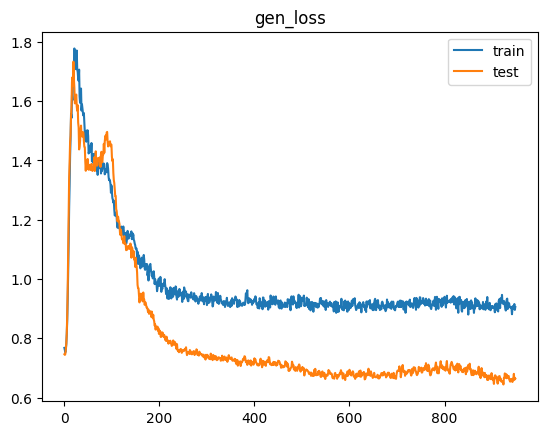

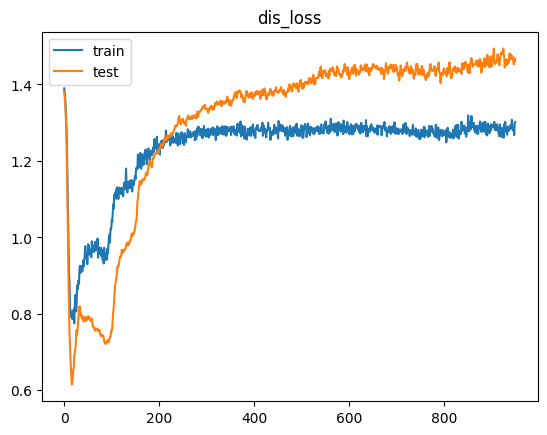

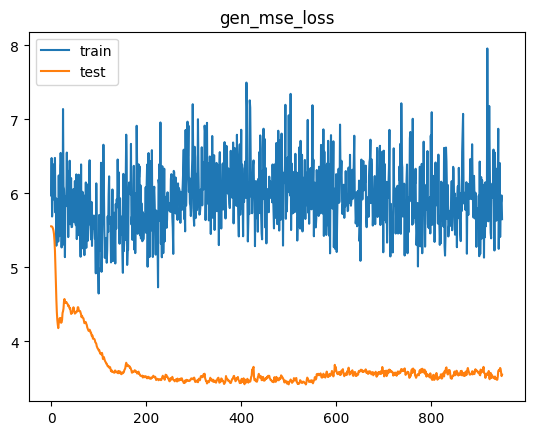

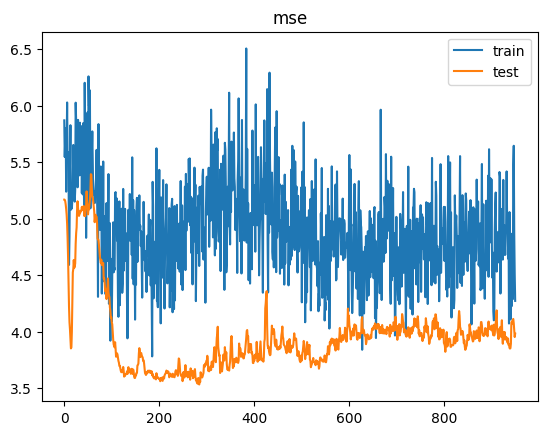

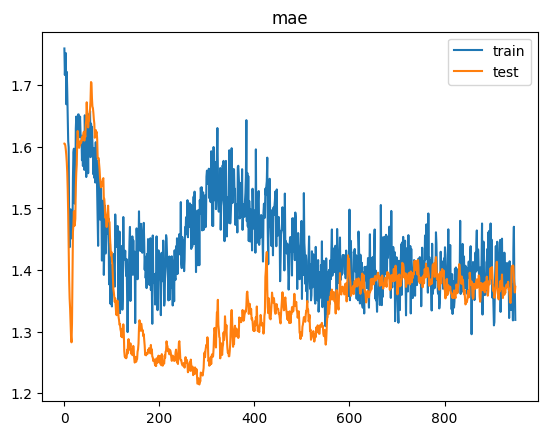

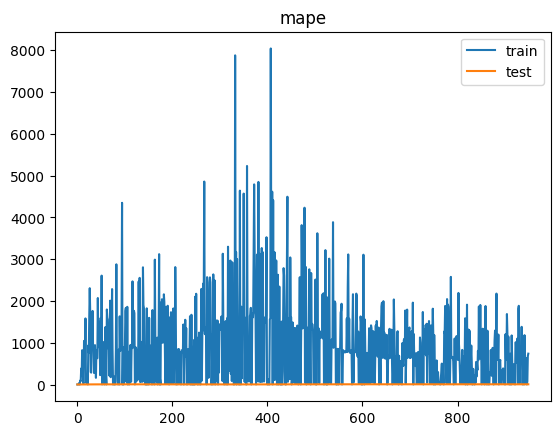

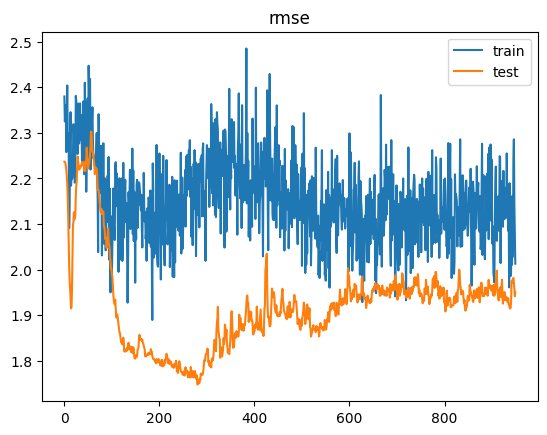

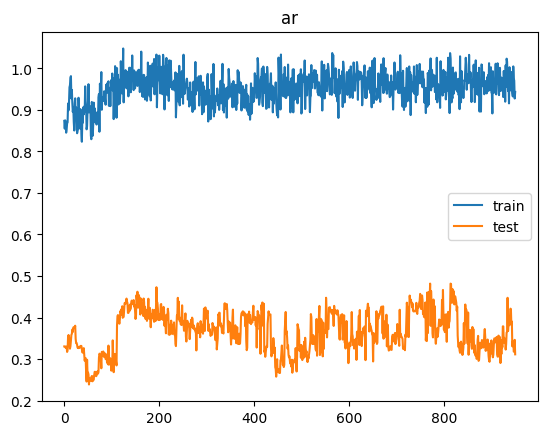

2/2 [==============================] - 0s 5ms/step


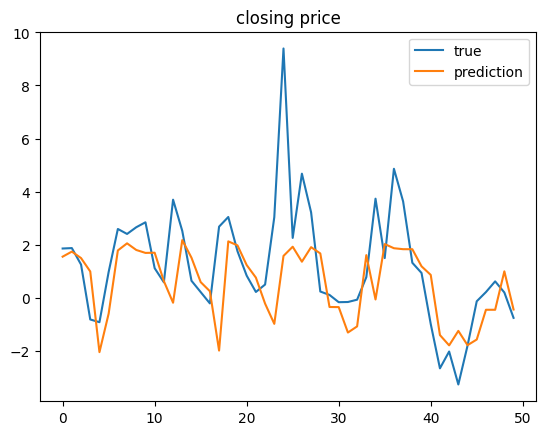

[MSE Baseline] train: 3.8840514501622194  test: 3.665913330963867
Delta time with epochs = 950: 0:07:36.602918
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_11 (LSTM

Time for epoch 52 is 0.43822169303894043 sec Generator Loss: 1.1719963550567627,  Discriminator_loss: 1.0659897327423096
Time for epoch 53 is 0.4284698963165283 sec Generator Loss: 1.1931166648864746,  Discriminator_loss: 1.0556432008743286
Time for epoch 54 is 0.43352818489074707 sec Generator Loss: 1.1740390062332153,  Discriminator_loss: 1.070817232131958
Time for epoch 55 is 0.4908263683319092 sec Generator Loss: 1.1820038557052612,  Discriminator_loss: 1.0583616495132446
Time for epoch 56 is 0.44478392601013184 sec Generator Loss: 1.158323049545288,  Discriminator_loss: 1.0767937898635864
Time for epoch 57 is 0.436673641204834 sec Generator Loss: 1.1869484186172485,  Discriminator_loss: 1.0683069229125977
Time for epoch 58 is 0.4350419044494629 sec Generator Loss: 1.16758394241333,  Discriminator_loss: 1.0869423151016235
Time for epoch 59 is 0.4324827194213867 sec Generator Loss: 1.1668792963027954,  Discriminator_loss: 1.092374324798584
Time for epoch 60 is 0.43055152893066406 se

Time for epoch 121 is 0.43171143531799316 sec Generator Loss: 0.9309203028678894,  Discriminator_loss: 1.251908540725708
Time for epoch 122 is 0.43256258964538574 sec Generator Loss: 0.922452449798584,  Discriminator_loss: 1.2730470895767212
Time for epoch 123 is 0.43489861488342285 sec Generator Loss: 0.9324216246604919,  Discriminator_loss: 1.2564818859100342
Time for epoch 124 is 0.4349370002746582 sec Generator Loss: 0.9207598567008972,  Discriminator_loss: 1.266670823097229
Time for epoch 125 is 0.43938732147216797 sec Generator Loss: 0.9164750576019287,  Discriminator_loss: 1.2628856897354126
Time for epoch 126 is 0.4375782012939453 sec Generator Loss: 0.9057372808456421,  Discriminator_loss: 1.2835509777069092
Time for epoch 127 is 0.43010687828063965 sec Generator Loss: 0.9273185729980469,  Discriminator_loss: 1.2654746770858765
Time for epoch 128 is 0.43004703521728516 sec Generator Loss: 0.9175918102264404,  Discriminator_loss: 1.2726342678070068
Time for epoch 129 is 0.44121

Time for epoch 189 is 0.43770551681518555 sec Generator Loss: 0.8835495114326477,  Discriminator_loss: 1.294894814491272
Time for epoch 190 is 0.43669891357421875 sec Generator Loss: 0.8623425364494324,  Discriminator_loss: 1.2988072633743286
Time for epoch 191 is 0.43474841117858887 sec Generator Loss: 0.8663594722747803,  Discriminator_loss: 1.302619457244873
Time for epoch 192 is 0.44341015815734863 sec Generator Loss: 0.8769201636314392,  Discriminator_loss: 1.2861309051513672
Time for epoch 193 is 0.4544551372528076 sec Generator Loss: 0.8718355298042297,  Discriminator_loss: 1.3062528371810913
Time for epoch 194 is 0.4485437870025635 sec Generator Loss: 0.8685736656188965,  Discriminator_loss: 1.2909621000289917
Time for epoch 195 is 0.43441033363342285 sec Generator Loss: 0.8758231401443481,  Discriminator_loss: 1.2862062454223633
Time for epoch 196 is 0.43834495544433594 sec Generator Loss: 0.8894566297531128,  Discriminator_loss: 1.2827078104019165
Time for epoch 197 is 0.4533

Time for epoch 257 is 0.4337272644042969 sec Generator Loss: 0.8744964599609375,  Discriminator_loss: 1.30781090259552
Time for epoch 258 is 0.4350879192352295 sec Generator Loss: 0.8869633674621582,  Discriminator_loss: 1.2873677015304565
Time for epoch 259 is 0.4322373867034912 sec Generator Loss: 0.880158543586731,  Discriminator_loss: 1.3067691326141357
Time for epoch 260 is 0.4256279468536377 sec Generator Loss: 0.8595406413078308,  Discriminator_loss: 1.307767391204834
Time for epoch 261 is 0.4364187717437744 sec Generator Loss: 0.8700604438781738,  Discriminator_loss: 1.3069688081741333
Time for epoch 262 is 0.44598817825317383 sec Generator Loss: 0.8618463277816772,  Discriminator_loss: 1.3040655851364136
Time for epoch 263 is 0.4272303581237793 sec Generator Loss: 0.8577845096588135,  Discriminator_loss: 1.3136441707611084
Time for epoch 264 is 0.4308156967163086 sec Generator Loss: 0.8640165328979492,  Discriminator_loss: 1.3095296621322632
Time for epoch 265 is 0.43199062347

Time for epoch 325 is 0.42844200134277344 sec Generator Loss: 0.8561021089553833,  Discriminator_loss: 1.3035756349563599
Time for epoch 326 is 0.430905818939209 sec Generator Loss: 0.8784890174865723,  Discriminator_loss: 1.2862147092819214
Time for epoch 327 is 0.43857717514038086 sec Generator Loss: 0.8766406178474426,  Discriminator_loss: 1.2910088300704956
Time for epoch 328 is 0.42713022232055664 sec Generator Loss: 0.8796640634536743,  Discriminator_loss: 1.2951149940490723
Time for epoch 329 is 0.4403810501098633 sec Generator Loss: 0.8713803291320801,  Discriminator_loss: 1.2916388511657715
Time for epoch 330 is 0.4304373264312744 sec Generator Loss: 0.8631329536437988,  Discriminator_loss: 1.2931632995605469
Time for epoch 331 is 0.42967915534973145 sec Generator Loss: 0.8868945240974426,  Discriminator_loss: 1.2993971109390259
Time for epoch 332 is 0.43332409858703613 sec Generator Loss: 0.8744484186172485,  Discriminator_loss: 1.2873252630233765
Time for epoch 333 is 0.4323

Time for epoch 393 is 0.4328181743621826 sec Generator Loss: 0.8770552277565002,  Discriminator_loss: 1.2849156856536865
Time for epoch 394 is 0.42545318603515625 sec Generator Loss: 0.8897942304611206,  Discriminator_loss: 1.284313440322876
Time for epoch 395 is 0.4222896099090576 sec Generator Loss: 0.8971913456916809,  Discriminator_loss: 1.2747633457183838
Time for epoch 396 is 0.4300673007965088 sec Generator Loss: 0.8921152949333191,  Discriminator_loss: 1.2929332256317139
Time for epoch 397 is 0.43111109733581543 sec Generator Loss: 0.8716773986816406,  Discriminator_loss: 1.2968517541885376
Time for epoch 398 is 0.44266724586486816 sec Generator Loss: 0.9013878107070923,  Discriminator_loss: 1.2778775691986084
Time for epoch 399 is 0.4299769401550293 sec Generator Loss: 0.879578709602356,  Discriminator_loss: 1.2972444295883179
Time for epoch 400 is 0.4499671459197998 sec Generator Loss: 0.8921570777893066,  Discriminator_loss: 1.2996829748153687
Time for epoch 401 is 0.4321293

Time for epoch 461 is 0.4350314140319824 sec Generator Loss: 0.8913129568099976,  Discriminator_loss: 1.2708654403686523
Time for epoch 462 is 0.4309518337249756 sec Generator Loss: 0.8975307941436768,  Discriminator_loss: 1.2775330543518066
Time for epoch 463 is 0.42806172370910645 sec Generator Loss: 0.8992761373519897,  Discriminator_loss: 1.2741366624832153
Time for epoch 464 is 0.42478489875793457 sec Generator Loss: 0.8999754190444946,  Discriminator_loss: 1.2785625457763672
Time for epoch 465 is 0.42977094650268555 sec Generator Loss: 0.8911521434783936,  Discriminator_loss: 1.2778069972991943
Time for epoch 466 is 0.43794798851013184 sec Generator Loss: 0.9048142433166504,  Discriminator_loss: 1.2805355787277222
Time for epoch 467 is 0.4548819065093994 sec Generator Loss: 0.8911648392677307,  Discriminator_loss: 1.287516713142395
Time for epoch 468 is 0.43091249465942383 sec Generator Loss: 0.91484135389328,  Discriminator_loss: 1.265377163887024
Time for epoch 469 is 0.4277987

Time for epoch 529 is 0.461057186126709 sec Generator Loss: 0.9024045467376709,  Discriminator_loss: 1.2767959833145142
Time for epoch 530 is 0.4383389949798584 sec Generator Loss: 0.8955466747283936,  Discriminator_loss: 1.2810906171798706
Time for epoch 531 is 0.4306144714355469 sec Generator Loss: 0.9102055430412292,  Discriminator_loss: 1.2566874027252197
Time for epoch 532 is 0.42910218238830566 sec Generator Loss: 0.9068446755409241,  Discriminator_loss: 1.2888319492340088
Time for epoch 533 is 0.43141651153564453 sec Generator Loss: 0.922772228717804,  Discriminator_loss: 1.2808141708374023
Time for epoch 534 is 0.46524620056152344 sec Generator Loss: 0.9117984175682068,  Discriminator_loss: 1.2679656744003296
Time for epoch 535 is 0.44243931770324707 sec Generator Loss: 0.9104662537574768,  Discriminator_loss: 1.2621238231658936
Time for epoch 536 is 0.43196725845336914 sec Generator Loss: 0.9056676626205444,  Discriminator_loss: 1.2775381803512573
Time for epoch 537 is 0.43797

Time for epoch 597 is 0.4320094585418701 sec Generator Loss: 0.9136060476303101,  Discriminator_loss: 1.2725372314453125
Time for epoch 598 is 0.4322483539581299 sec Generator Loss: 0.9029123783111572,  Discriminator_loss: 1.2787567377090454
Time for epoch 599 is 0.4328939914703369 sec Generator Loss: 0.9158931970596313,  Discriminator_loss: 1.2618494033813477
Time for epoch 600 is 0.42948269844055176 sec Generator Loss: 0.9074673056602478,  Discriminator_loss: 1.2770076990127563
Time for epoch 601 is 0.43235111236572266 sec Generator Loss: 0.9080663323402405,  Discriminator_loss: 1.2806353569030762
Time for epoch 602 is 0.4365053176879883 sec Generator Loss: 0.9110302329063416,  Discriminator_loss: 1.2654575109481812
Time for epoch 603 is 0.4688131809234619 sec Generator Loss: 0.9024469256401062,  Discriminator_loss: 1.2716425657272339
Time for epoch 604 is 0.43148183822631836 sec Generator Loss: 0.9172366261482239,  Discriminator_loss: 1.2822234630584717
Time for epoch 605 is 0.43610

Time for epoch 665 is 0.4297482967376709 sec Generator Loss: 0.8986554145812988,  Discriminator_loss: 1.274959683418274
Time for epoch 666 is 0.4312856197357178 sec Generator Loss: 0.8927491903305054,  Discriminator_loss: 1.2927969694137573
Time for epoch 667 is 0.43921756744384766 sec Generator Loss: 0.9055739045143127,  Discriminator_loss: 1.2705187797546387
Time for epoch 668 is 0.44606494903564453 sec Generator Loss: 0.9112615585327148,  Discriminator_loss: 1.272925615310669
Time for epoch 669 is 0.43536972999572754 sec Generator Loss: 0.8945053815841675,  Discriminator_loss: 1.287713646888733
Time for epoch 670 is 0.4407641887664795 sec Generator Loss: 0.9089969396591187,  Discriminator_loss: 1.2823588848114014
Time for epoch 671 is 0.44267916679382324 sec Generator Loss: 0.9005154371261597,  Discriminator_loss: 1.287451982498169
Time for epoch 672 is 0.431438684463501 sec Generator Loss: 0.9076178669929504,  Discriminator_loss: 1.2812612056732178
Time for epoch 673 is 0.429853439

Time for epoch 733 is 0.4363219738006592 sec Generator Loss: 0.9087212085723877,  Discriminator_loss: 1.2869830131530762
Time for epoch 734 is 0.4328889846801758 sec Generator Loss: 0.9212487936019897,  Discriminator_loss: 1.271053433418274
Time for epoch 735 is 0.42989230155944824 sec Generator Loss: 0.9019927382469177,  Discriminator_loss: 1.290525197982788
Time for epoch 736 is 0.4313504695892334 sec Generator Loss: 0.9092495441436768,  Discriminator_loss: 1.277158260345459
Time for epoch 737 is 0.43135738372802734 sec Generator Loss: 0.9080159068107605,  Discriminator_loss: 1.291558027267456
Time for epoch 738 is 0.46361732482910156 sec Generator Loss: 0.9095730185508728,  Discriminator_loss: 1.2799782752990723
Time for epoch 739 is 0.44709038734436035 sec Generator Loss: 0.9021204710006714,  Discriminator_loss: 1.27406907081604
Time for epoch 740 is 0.42702317237854004 sec Generator Loss: 0.9070447683334351,  Discriminator_loss: 1.269934892654419
Time for epoch 741 is 0.4381785392

Time for epoch 801 is 0.4337952136993408 sec Generator Loss: 0.9104337692260742,  Discriminator_loss: 1.2811360359191895
Time for epoch 802 is 0.444119930267334 sec Generator Loss: 0.9015209078788757,  Discriminator_loss: 1.2762267589569092
Time for epoch 803 is 0.4299325942993164 sec Generator Loss: 0.8950023055076599,  Discriminator_loss: 1.285406470298767
Time for epoch 804 is 0.43650317192077637 sec Generator Loss: 0.9147473573684692,  Discriminator_loss: 1.2720963954925537
Time for epoch 805 is 0.439716100692749 sec Generator Loss: 0.9145618677139282,  Discriminator_loss: 1.2665791511535645
Time for epoch 806 is 0.48267388343811035 sec Generator Loss: 0.9188242554664612,  Discriminator_loss: 1.2757480144500732
Time for epoch 807 is 0.46788668632507324 sec Generator Loss: 0.9033855199813843,  Discriminator_loss: 1.2867193222045898
Time for epoch 808 is 0.44803500175476074 sec Generator Loss: 0.9148061275482178,  Discriminator_loss: 1.2727901935577393
Time for epoch 809 is 0.4366838

Time for epoch 869 is 0.4280233383178711 sec Generator Loss: 0.8879222869873047,  Discriminator_loss: 1.2801337242126465
Time for epoch 870 is 0.4328744411468506 sec Generator Loss: 0.8863469362258911,  Discriminator_loss: 1.2945144176483154
Time for epoch 871 is 0.4319112300872803 sec Generator Loss: 0.9085249900817871,  Discriminator_loss: 1.2725800275802612
Time for epoch 872 is 0.44469189643859863 sec Generator Loss: 0.8901928663253784,  Discriminator_loss: 1.286749005317688
Time for epoch 873 is 0.433823823928833 sec Generator Loss: 0.9147675037384033,  Discriminator_loss: 1.2753092050552368
Time for epoch 874 is 0.43987083435058594 sec Generator Loss: 0.9271203279495239,  Discriminator_loss: 1.2699118852615356
Time for epoch 875 is 0.432680606842041 sec Generator Loss: 0.9140897989273071,  Discriminator_loss: 1.2652729749679565
Time for epoch 876 is 0.4362466335296631 sec Generator Loss: 0.9023756980895996,  Discriminator_loss: 1.2831004858016968
Time for epoch 877 is 0.441343784

Time for epoch 937 is 0.5159521102905273 sec Generator Loss: 0.9259489178657532,  Discriminator_loss: 1.2720932960510254
Time for epoch 938 is 0.472475528717041 sec Generator Loss: 0.9265512824058533,  Discriminator_loss: 1.2788029909133911
Time for epoch 939 is 0.4758586883544922 sec Generator Loss: 0.9044621586799622,  Discriminator_loss: 1.2808111906051636
Time for epoch 940 is 0.4708888530731201 sec Generator Loss: 0.8953566551208496,  Discriminator_loss: 1.2769606113433838
Time for epoch 941 is 0.47417759895324707 sec Generator Loss: 0.9336682558059692,  Discriminator_loss: 1.2700461149215698
Time for epoch 942 is 0.4792208671569824 sec Generator Loss: 0.9027352929115295,  Discriminator_loss: 1.2751755714416504
Time for epoch 943 is 0.4775068759918213 sec Generator Loss: 0.905881404876709,  Discriminator_loss: 1.288129448890686
Time for epoch 944 is 0.47414350509643555 sec Generator Loss: 0.9125726819038391,  Discriminator_loss: 1.2874919176101685
Time for epoch 945 is 0.474019765

Time for epoch 1005 is 0.4755685329437256 sec Generator Loss: 0.9055443406105042,  Discriminator_loss: 1.2782484292984009
Time for epoch 1006 is 0.5051343441009521 sec Generator Loss: 0.8996721506118774,  Discriminator_loss: 1.2789685726165771
Time for epoch 1007 is 0.5313920974731445 sec Generator Loss: 0.9035380482673645,  Discriminator_loss: 1.2828938961029053
Time for epoch 1008 is 0.48260068893432617 sec Generator Loss: 0.9019618630409241,  Discriminator_loss: 1.2901357412338257
Time for epoch 1009 is 0.4706852436065674 sec Generator Loss: 0.8850690722465515,  Discriminator_loss: 1.298577904701233
Time for epoch 1010 is 0.48515915870666504 sec Generator Loss: 0.8940086960792542,  Discriminator_loss: 1.289238691329956
Time for epoch 1011 is 0.4786720275878906 sec Generator Loss: 0.8926119208335876,  Discriminator_loss: 1.2839508056640625
Time for epoch 1012 is 0.4805307388305664 sec Generator Loss: 0.9262949228286743,  Discriminator_loss: 1.265997290611267
Time for epoch 1013 is 0.

Time for epoch 1073 is 0.44170570373535156 sec Generator Loss: 0.9013219475746155,  Discriminator_loss: 1.282563328742981
Time for epoch 1074 is 0.45812320709228516 sec Generator Loss: 0.9133734703063965,  Discriminator_loss: 1.270395278930664
Time for epoch 1075 is 0.4458129405975342 sec Generator Loss: 0.9132444858551025,  Discriminator_loss: 1.282212495803833
Time for epoch 1076 is 0.4583008289337158 sec Generator Loss: 0.9037946462631226,  Discriminator_loss: 1.2916388511657715
Time for epoch 1077 is 0.46674227714538574 sec Generator Loss: 0.9112485647201538,  Discriminator_loss: 1.28135085105896
Time for epoch 1078 is 0.44718408584594727 sec Generator Loss: 0.9100828766822815,  Discriminator_loss: 1.2788559198379517
Time for epoch 1079 is 0.45443248748779297 sec Generator Loss: 0.907218873500824,  Discriminator_loss: 1.2827534675598145
Time for epoch 1080 is 0.4378323554992676 sec Generator Loss: 0.902258038520813,  Discriminator_loss: 1.280930995941162
Time for epoch 1081 is 0.45

Time for epoch 1141 is 0.45430731773376465 sec Generator Loss: 0.8917049765586853,  Discriminator_loss: 1.2802391052246094
Time for epoch 1142 is 0.4701559543609619 sec Generator Loss: 0.8907732367515564,  Discriminator_loss: 1.2859662771224976
Time for epoch 1143 is 0.4795260429382324 sec Generator Loss: 0.901919960975647,  Discriminator_loss: 1.283764362335205
Time for epoch 1144 is 0.48717808723449707 sec Generator Loss: 0.9172317385673523,  Discriminator_loss: 1.2736437320709229
Time for epoch 1145 is 0.4533998966217041 sec Generator Loss: 0.9216808080673218,  Discriminator_loss: 1.264695405960083
Time for epoch 1146 is 0.4532887935638428 sec Generator Loss: 0.8961755037307739,  Discriminator_loss: 1.2848217487335205
Time for epoch 1147 is 0.477092981338501 sec Generator Loss: 0.8994237184524536,  Discriminator_loss: 1.275261402130127
Time for epoch 1148 is 0.4593057632446289 sec Generator Loss: 0.9043059349060059,  Discriminator_loss: 1.2892171144485474
Time for epoch 1149 is 0.45

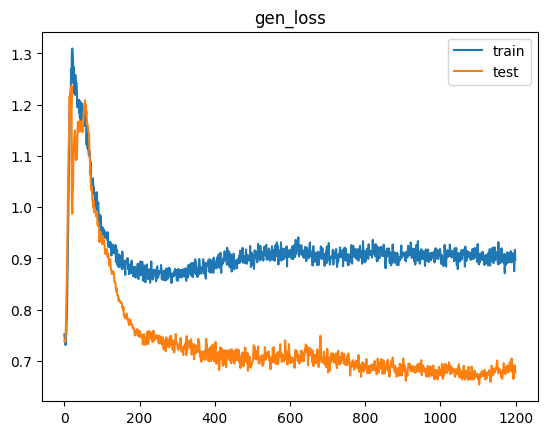

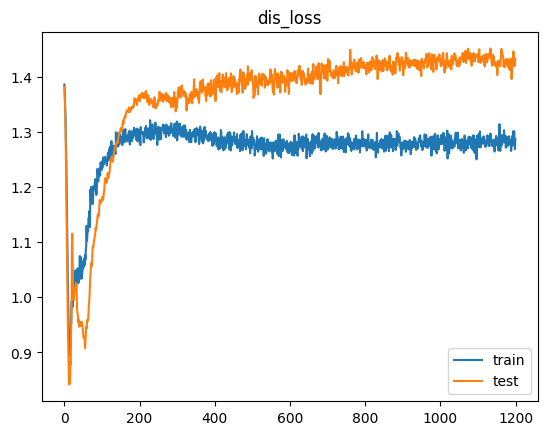

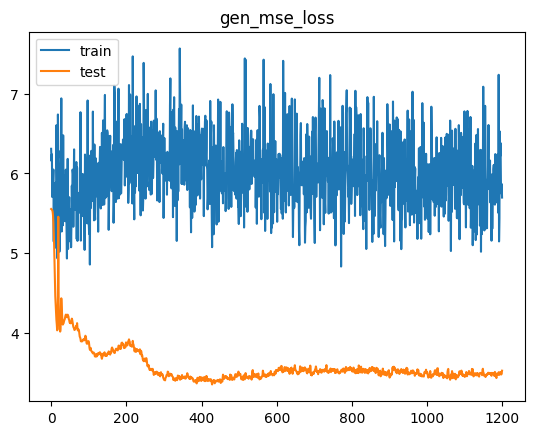

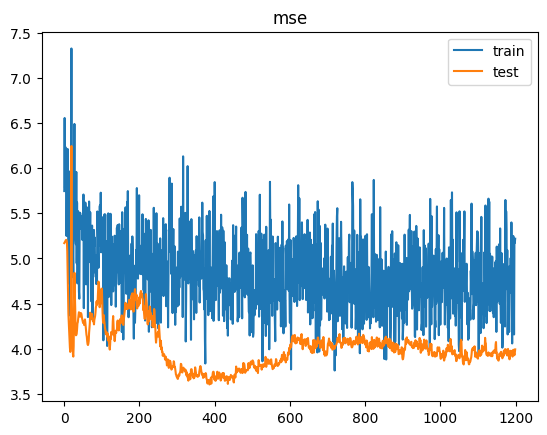

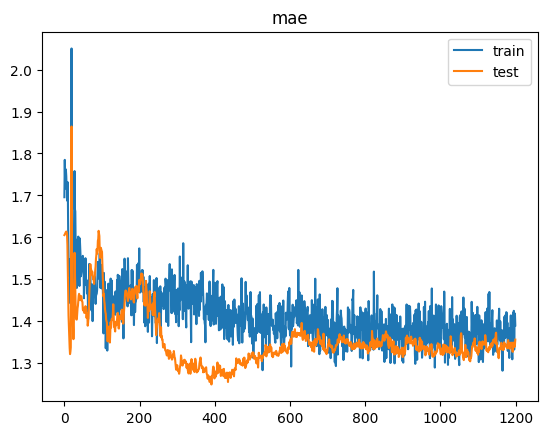

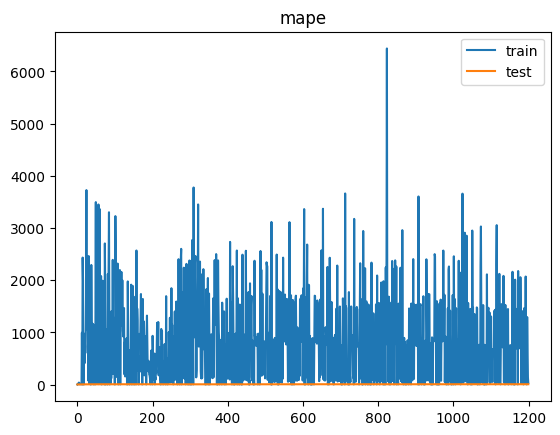

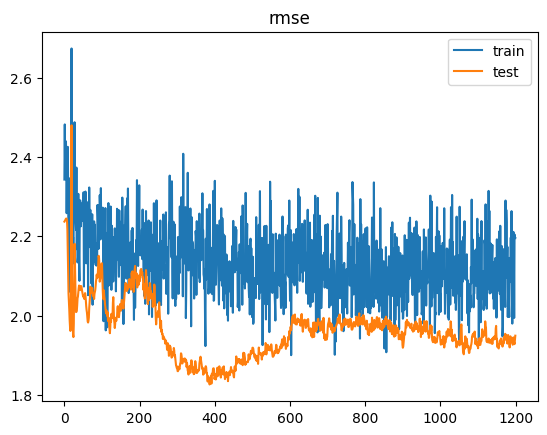

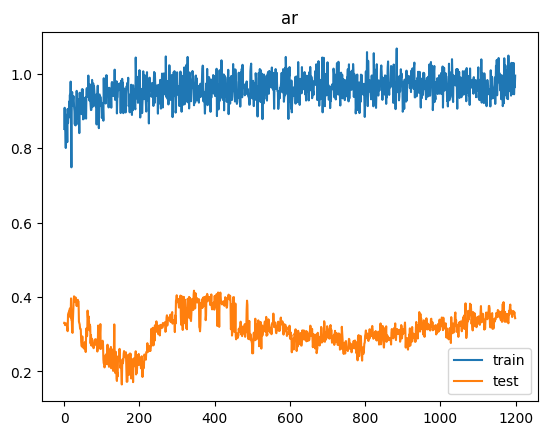

2/2 [==============================] - 0s 3ms/step


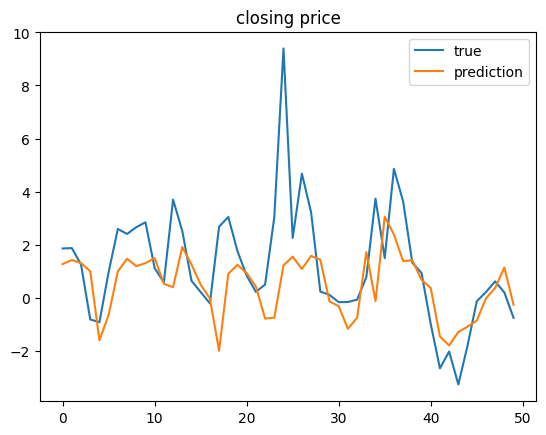

[MSE Baseline] train: 4.912247655105159  test: 3.665913330963867
Delta time with epochs = 1200: 0:09:19.063029
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_13 (LSTM

Time for epoch 52 is 0.4517791271209717 sec Generator Loss: 1.2688640356063843,  Discriminator_loss: 0.9513655304908752
Time for epoch 53 is 0.45229101181030273 sec Generator Loss: 1.2930432558059692,  Discriminator_loss: 0.9789975881576538
Time for epoch 54 is 0.4576151371002197 sec Generator Loss: 1.287754774093628,  Discriminator_loss: 0.9872221946716309
Time for epoch 55 is 0.45297884941101074 sec Generator Loss: 1.2473503351211548,  Discriminator_loss: 1.0031996965408325
Time for epoch 56 is 0.4521355628967285 sec Generator Loss: 1.2862968444824219,  Discriminator_loss: 0.9909218549728394
Time for epoch 57 is 0.4589841365814209 sec Generator Loss: 1.3134454488754272,  Discriminator_loss: 0.9565216302871704
Time for epoch 58 is 0.4502723217010498 sec Generator Loss: 1.2787824869155884,  Discriminator_loss: 1.0104211568832397
Time for epoch 59 is 0.4400908946990967 sec Generator Loss: 1.2896620035171509,  Discriminator_loss: 0.983611524105072
Time for epoch 60 is 0.49962282180786133

Time for epoch 121 is 2.1216278076171875 sec Generator Loss: 0.9182908535003662,  Discriminator_loss: 1.273999571800232
Time for epoch 122 is 0.4583916664123535 sec Generator Loss: 0.933523416519165,  Discriminator_loss: 1.256491780281067
Time for epoch 123 is 0.4603414535522461 sec Generator Loss: 0.9255061149597168,  Discriminator_loss: 1.253468632698059
Time for epoch 124 is 0.46959495544433594 sec Generator Loss: 0.9188197255134583,  Discriminator_loss: 1.2569785118103027
Time for epoch 125 is 0.45734548568725586 sec Generator Loss: 0.9370943903923035,  Discriminator_loss: 1.2621163129806519
Time for epoch 126 is 0.45882153511047363 sec Generator Loss: 0.9311527013778687,  Discriminator_loss: 1.2547804117202759
Time for epoch 127 is 0.4594423770904541 sec Generator Loss: 0.9187252521514893,  Discriminator_loss: 1.25946843624115
Time for epoch 128 is 0.47351503372192383 sec Generator Loss: 0.9472649693489075,  Discriminator_loss: 1.2497484683990479
Time for epoch 129 is 0.4576013088

Time for epoch 189 is 0.482205867767334 sec Generator Loss: 0.913996696472168,  Discriminator_loss: 1.2613030672073364
Time for epoch 190 is 0.47898030281066895 sec Generator Loss: 0.9403595328330994,  Discriminator_loss: 1.267139196395874
Time for epoch 191 is 0.478593111038208 sec Generator Loss: 0.9568524956703186,  Discriminator_loss: 1.258210301399231
Time for epoch 192 is 0.4847581386566162 sec Generator Loss: 0.9350117444992065,  Discriminator_loss: 1.2524689435958862
Time for epoch 193 is 0.47933101654052734 sec Generator Loss: 0.9433343410491943,  Discriminator_loss: 1.2527812719345093
Time for epoch 194 is 0.5087900161743164 sec Generator Loss: 0.9252026081085205,  Discriminator_loss: 1.2645248174667358
Time for epoch 195 is 0.49617981910705566 sec Generator Loss: 0.9462904334068298,  Discriminator_loss: 1.2504431009292603
Time for epoch 196 is 0.5023016929626465 sec Generator Loss: 0.9285960793495178,  Discriminator_loss: 1.2761024236679077
Time for epoch 197 is 0.5300269126

Time for epoch 257 is 0.46938204765319824 sec Generator Loss: 0.9299972057342529,  Discriminator_loss: 1.264889121055603
Time for epoch 258 is 0.4933791160583496 sec Generator Loss: 0.9396992325782776,  Discriminator_loss: 1.2671453952789307
Time for epoch 259 is 0.4587709903717041 sec Generator Loss: 0.9302608966827393,  Discriminator_loss: 1.2660335302352905
Time for epoch 260 is 0.45839691162109375 sec Generator Loss: 0.9348161816596985,  Discriminator_loss: 1.265533208847046
Time for epoch 261 is 0.45967817306518555 sec Generator Loss: 0.9220152497291565,  Discriminator_loss: 1.2752550840377808
Time for epoch 262 is 0.4528830051422119 sec Generator Loss: 0.9302195310592651,  Discriminator_loss: 1.2703534364700317
Time for epoch 263 is 0.45328235626220703 sec Generator Loss: 0.931830644607544,  Discriminator_loss: 1.2582266330718994
Time for epoch 264 is 0.4634406566619873 sec Generator Loss: 0.9197032451629639,  Discriminator_loss: 1.2866448163986206
Time for epoch 265 is 0.4614055

Time for epoch 325 is 0.5170257091522217 sec Generator Loss: 0.9213910102844238,  Discriminator_loss: 1.2602427005767822
Time for epoch 326 is 0.4841806888580322 sec Generator Loss: 0.907876193523407,  Discriminator_loss: 1.2687996625900269
Time for epoch 327 is 0.5281908512115479 sec Generator Loss: 0.9271307587623596,  Discriminator_loss: 1.2646667957305908
Time for epoch 328 is 0.48834800720214844 sec Generator Loss: 0.9275305867195129,  Discriminator_loss: 1.28201162815094
Time for epoch 329 is 0.5066583156585693 sec Generator Loss: 0.9280219078063965,  Discriminator_loss: 1.2694265842437744
Time for epoch 330 is 0.495375394821167 sec Generator Loss: 0.9185491800308228,  Discriminator_loss: 1.2691422700881958
Time for epoch 331 is 0.48705482482910156 sec Generator Loss: 0.9251160621643066,  Discriminator_loss: 1.2687046527862549
Time for epoch 332 is 0.4856832027435303 sec Generator Loss: 0.9314204454421997,  Discriminator_loss: 1.262838363647461
Time for epoch 333 is 0.48965287208

Time for epoch 393 is 0.4700348377227783 sec Generator Loss: 0.8956733345985413,  Discriminator_loss: 1.2997021675109863
Time for epoch 394 is 0.4539022445678711 sec Generator Loss: 0.9163329601287842,  Discriminator_loss: 1.2789918184280396
Time for epoch 395 is 0.4608733654022217 sec Generator Loss: 0.9117212891578674,  Discriminator_loss: 1.2938693761825562
Time for epoch 396 is 0.4581778049468994 sec Generator Loss: 0.8981316089630127,  Discriminator_loss: 1.2960518598556519
Time for epoch 397 is 0.4688687324523926 sec Generator Loss: 0.9149099588394165,  Discriminator_loss: 1.2699127197265625
Time for epoch 398 is 0.4848518371582031 sec Generator Loss: 0.9120976328849792,  Discriminator_loss: 1.2678523063659668
Time for epoch 399 is 0.4607114791870117 sec Generator Loss: 0.9169832468032837,  Discriminator_loss: 1.272660732269287
Time for epoch 400 is 0.4605576992034912 sec Generator Loss: 0.9079176187515259,  Discriminator_loss: 1.2776554822921753
Time for epoch 401 is 0.452755212

Time for epoch 461 is 0.4961838722229004 sec Generator Loss: 0.9110082387924194,  Discriminator_loss: 1.292738437652588
Time for epoch 462 is 0.5116050243377686 sec Generator Loss: 0.9137881398200989,  Discriminator_loss: 1.2808393239974976
Time for epoch 463 is 0.49726343154907227 sec Generator Loss: 0.908364474773407,  Discriminator_loss: 1.278726577758789
Time for epoch 464 is 0.4931039810180664 sec Generator Loss: 0.8951604962348938,  Discriminator_loss: 1.2853502035140991
Time for epoch 465 is 0.4783773422241211 sec Generator Loss: 0.9332240223884583,  Discriminator_loss: 1.2724865674972534
Time for epoch 466 is 0.4831376075744629 sec Generator Loss: 0.9137182831764221,  Discriminator_loss: 1.2775157690048218
Time for epoch 467 is 0.5080304145812988 sec Generator Loss: 0.909028172492981,  Discriminator_loss: 1.2983664274215698
Time for epoch 468 is 0.46180295944213867 sec Generator Loss: 0.9271016716957092,  Discriminator_loss: 1.2638241052627563
Time for epoch 469 is 0.4552628993

Time for epoch 529 is 0.4620826244354248 sec Generator Loss: 0.9132949113845825,  Discriminator_loss: 1.288314938545227
Time for epoch 530 is 0.4601454734802246 sec Generator Loss: 0.8833795785903931,  Discriminator_loss: 1.2985750436782837
Time for epoch 531 is 0.5209174156188965 sec Generator Loss: 0.8981882929801941,  Discriminator_loss: 1.2797882556915283
Time for epoch 532 is 0.48247289657592773 sec Generator Loss: 0.8914072513580322,  Discriminator_loss: 1.2906831502914429
Time for epoch 533 is 0.46511006355285645 sec Generator Loss: 0.9025298953056335,  Discriminator_loss: 1.2891981601715088
Time for epoch 534 is 0.4572875499725342 sec Generator Loss: 0.8970473408699036,  Discriminator_loss: 1.2954950332641602
Time for epoch 535 is 0.4505167007446289 sec Generator Loss: 0.9120562672615051,  Discriminator_loss: 1.2795733213424683
Time for epoch 536 is 0.4601430892944336 sec Generator Loss: 0.897641658782959,  Discriminator_loss: 1.2977296113967896
Time for epoch 537 is 0.45978760

Time for epoch 597 is 0.48618078231811523 sec Generator Loss: 0.9060271978378296,  Discriminator_loss: 1.2788861989974976
Time for epoch 598 is 0.4540274143218994 sec Generator Loss: 0.9071626663208008,  Discriminator_loss: 1.288055419921875
Time for epoch 599 is 0.4522724151611328 sec Generator Loss: 0.8978835344314575,  Discriminator_loss: 1.311475396156311
Time for epoch 600 is 0.45900869369506836 sec Generator Loss: 0.9077060222625732,  Discriminator_loss: 1.2929195165634155
Time for epoch 601 is 0.464679479598999 sec Generator Loss: 0.9045246839523315,  Discriminator_loss: 1.2930858135223389
Time for epoch 602 is 0.4532794952392578 sec Generator Loss: 0.9091814160346985,  Discriminator_loss: 1.2761198282241821
Time for epoch 603 is 0.45852231979370117 sec Generator Loss: 0.885448157787323,  Discriminator_loss: 1.3035802841186523
Time for epoch 604 is 0.4575481414794922 sec Generator Loss: 0.8851847648620605,  Discriminator_loss: 1.3037750720977783
Time for epoch 605 is 0.471631765

Time for epoch 665 is 0.46297192573547363 sec Generator Loss: 0.8952240943908691,  Discriminator_loss: 1.3032090663909912
Time for epoch 666 is 0.45992136001586914 sec Generator Loss: 0.9046058654785156,  Discriminator_loss: 1.2843905687332153
Time for epoch 667 is 0.45425915718078613 sec Generator Loss: 0.8759604096412659,  Discriminator_loss: 1.3050968647003174
Time for epoch 668 is 0.45719361305236816 sec Generator Loss: 0.8882613778114319,  Discriminator_loss: 1.296093225479126
Time for epoch 669 is 0.47197699546813965 sec Generator Loss: 0.8980218768119812,  Discriminator_loss: 1.2912728786468506
Time for epoch 670 is 0.46428728103637695 sec Generator Loss: 0.888521134853363,  Discriminator_loss: 1.2849169969558716
Time for epoch 671 is 0.4549381732940674 sec Generator Loss: 0.8969582915306091,  Discriminator_loss: 1.2974880933761597
Time for epoch 672 is 0.4646036624908447 sec Generator Loss: 0.9006368517875671,  Discriminator_loss: 1.285918951034546
Time for epoch 673 is 0.45512

Time for epoch 733 is 0.4618871212005615 sec Generator Loss: 0.903899610042572,  Discriminator_loss: 1.2997649908065796
Time for epoch 734 is 0.4545419216156006 sec Generator Loss: 0.9102504253387451,  Discriminator_loss: 1.2847002744674683
Time for epoch 735 is 0.4861338138580322 sec Generator Loss: 0.9019875526428223,  Discriminator_loss: 1.291979432106018
Time for epoch 736 is 0.4551064968109131 sec Generator Loss: 0.9143568873405457,  Discriminator_loss: 1.271538496017456
Time for epoch 737 is 0.466489315032959 sec Generator Loss: 0.9064191579818726,  Discriminator_loss: 1.2959380149841309
Time for epoch 738 is 0.48793745040893555 sec Generator Loss: 0.9074764847755432,  Discriminator_loss: 1.2796751260757446
Time for epoch 739 is 0.45417046546936035 sec Generator Loss: 0.9029911160469055,  Discriminator_loss: 1.2853708267211914
Time for epoch 740 is 0.45659399032592773 sec Generator Loss: 0.8965887427330017,  Discriminator_loss: 1.2956111431121826
Time for epoch 741 is 0.457972049

Time for epoch 801 is 0.47596073150634766 sec Generator Loss: 0.906561017036438,  Discriminator_loss: 1.2868962287902832
Time for epoch 802 is 0.504910945892334 sec Generator Loss: 0.9009732007980347,  Discriminator_loss: 1.2885420322418213
Time for epoch 803 is 0.4584619998931885 sec Generator Loss: 0.9069629311561584,  Discriminator_loss: 1.2768220901489258
Time for epoch 804 is 0.464794397354126 sec Generator Loss: 0.9027800559997559,  Discriminator_loss: 1.2815498113632202
Time for epoch 805 is 0.45926356315612793 sec Generator Loss: 0.8983072638511658,  Discriminator_loss: 1.3084728717803955
Time for epoch 806 is 0.45598673820495605 sec Generator Loss: 0.909451425075531,  Discriminator_loss: 1.2835668325424194
Time for epoch 807 is 0.4608914852142334 sec Generator Loss: 0.9278886318206787,  Discriminator_loss: 1.260507345199585
Time for epoch 808 is 0.47150254249572754 sec Generator Loss: 0.9097479581832886,  Discriminator_loss: 1.290527105331421
Time for epoch 809 is 0.4523200988

Time for epoch 869 is 0.4537670612335205 sec Generator Loss: 0.8998783230781555,  Discriminator_loss: 1.2908157110214233
Time for epoch 870 is 0.456129789352417 sec Generator Loss: 0.9229432344436646,  Discriminator_loss: 1.2801989316940308
Time for epoch 871 is 0.4719414710998535 sec Generator Loss: 0.8898283243179321,  Discriminator_loss: 1.2970972061157227
Time for epoch 872 is 0.5234155654907227 sec Generator Loss: 0.8901945948600769,  Discriminator_loss: 1.283870816230774
Time for epoch 873 is 0.5090322494506836 sec Generator Loss: 0.8939116597175598,  Discriminator_loss: 1.2952080965042114
Time for epoch 874 is 0.4886934757232666 sec Generator Loss: 0.905338704586029,  Discriminator_loss: 1.2750612497329712
Time for epoch 875 is 0.47464442253112793 sec Generator Loss: 0.9018296599388123,  Discriminator_loss: 1.2874782085418701
Time for epoch 876 is 0.47406768798828125 sec Generator Loss: 0.9095094203948975,  Discriminator_loss: 1.279618263244629
Time for epoch 877 is 0.4884338378

Time for epoch 937 is 0.5051088333129883 sec Generator Loss: 0.9249231219291687,  Discriminator_loss: 1.2793786525726318
Time for epoch 938 is 0.48030924797058105 sec Generator Loss: 0.9109513163566589,  Discriminator_loss: 1.2778699398040771
Time for epoch 939 is 0.481982946395874 sec Generator Loss: 0.9018353223800659,  Discriminator_loss: 1.2942345142364502
Time for epoch 940 is 0.47264695167541504 sec Generator Loss: 0.9251955151557922,  Discriminator_loss: 1.2724040746688843
Time for epoch 941 is 0.4638023376464844 sec Generator Loss: 0.9293828010559082,  Discriminator_loss: 1.271363377571106
Time for epoch 942 is 0.4663574695587158 sec Generator Loss: 0.9066141843795776,  Discriminator_loss: 1.2820903062820435
Time for epoch 943 is 0.45901989936828613 sec Generator Loss: 0.9110602736473083,  Discriminator_loss: 1.2845356464385986
Time for epoch 944 is 0.45724987983703613 sec Generator Loss: 0.9109252691268921,  Discriminator_loss: 1.2930426597595215
Time for epoch 945 is 0.460602

Time for epoch 1005 is 0.5288419723510742 sec Generator Loss: 0.9223747849464417,  Discriminator_loss: 1.2722655534744263
Time for epoch 1006 is 0.4735527038574219 sec Generator Loss: 0.928923487663269,  Discriminator_loss: 1.2763261795043945
Time for epoch 1007 is 0.4616084098815918 sec Generator Loss: 0.9118950963020325,  Discriminator_loss: 1.2866476774215698
Time for epoch 1008 is 0.5437517166137695 sec Generator Loss: 0.9310622811317444,  Discriminator_loss: 1.2691482305526733
Time for epoch 1009 is 0.46456003189086914 sec Generator Loss: 0.9313866496086121,  Discriminator_loss: 1.27311372756958
Time for epoch 1010 is 0.463245153427124 sec Generator Loss: 0.9321285486221313,  Discriminator_loss: 1.2681267261505127
Time for epoch 1011 is 0.456897497177124 sec Generator Loss: 0.9353197813034058,  Discriminator_loss: 1.2696634531021118
Time for epoch 1012 is 0.46518611907958984 sec Generator Loss: 0.9220096468925476,  Discriminator_loss: 1.2812784910202026
Time for epoch 1013 is 0.45

Time for epoch 1073 is 0.5134470462799072 sec Generator Loss: 0.9195835590362549,  Discriminator_loss: 1.2752611637115479
Time for epoch 1074 is 0.48842597007751465 sec Generator Loss: 0.9205935597419739,  Discriminator_loss: 1.2658642530441284
Time for epoch 1075 is 0.49239397048950195 sec Generator Loss: 0.9269900918006897,  Discriminator_loss: 1.281490683555603
Time for epoch 1076 is 0.5080013275146484 sec Generator Loss: 0.939144492149353,  Discriminator_loss: 1.2694908380508423
Time for epoch 1077 is 0.5066680908203125 sec Generator Loss: 0.9310038685798645,  Discriminator_loss: 1.2652474641799927
Time for epoch 1078 is 0.511141300201416 sec Generator Loss: 0.9297879934310913,  Discriminator_loss: 1.2545198202133179
Time for epoch 1079 is 0.5190351009368896 sec Generator Loss: 0.9373125433921814,  Discriminator_loss: 1.2780605554580688
Time for epoch 1080 is 0.5108978748321533 sec Generator Loss: 0.9295470714569092,  Discriminator_loss: 1.2688931226730347
Time for epoch 1081 is 0.

Time for epoch 1141 is 0.46179890632629395 sec Generator Loss: 0.9309231042861938,  Discriminator_loss: 1.2583266496658325
Time for epoch 1142 is 0.46149492263793945 sec Generator Loss: 0.942363440990448,  Discriminator_loss: 1.2553455829620361
Time for epoch 1143 is 0.47048521041870117 sec Generator Loss: 0.9360302090644836,  Discriminator_loss: 1.2732417583465576
Time for epoch 1144 is 0.4675755500793457 sec Generator Loss: 0.9372183680534363,  Discriminator_loss: 1.2697443962097168
Time for epoch 1145 is 0.4601726531982422 sec Generator Loss: 0.9507516026496887,  Discriminator_loss: 1.263986587524414
Time for epoch 1146 is 0.4756593704223633 sec Generator Loss: 0.9356403946876526,  Discriminator_loss: 1.2825957536697388
Time for epoch 1147 is 0.461132287979126 sec Generator Loss: 0.9325870275497437,  Discriminator_loss: 1.269640564918518
Time for epoch 1148 is 0.4836888313293457 sec Generator Loss: 0.9262979626655579,  Discriminator_loss: 1.2727491855621338
Time for epoch 1149 is 0.

Time for epoch 1209 is 0.5483708381652832 sec Generator Loss: 0.9444319009780884,  Discriminator_loss: 1.2633321285247803
Time for epoch 1210 is 0.5146033763885498 sec Generator Loss: 0.9448506832122803,  Discriminator_loss: 1.2696893215179443
Time for epoch 1211 is 0.5311346054077148 sec Generator Loss: 0.9179949164390564,  Discriminator_loss: 1.274340271949768
Time for epoch 1212 is 0.4831700325012207 sec Generator Loss: 0.9279432892799377,  Discriminator_loss: 1.2754086256027222
Time for epoch 1213 is 0.5008180141448975 sec Generator Loss: 0.9405133724212646,  Discriminator_loss: 1.2669239044189453
Time for epoch 1214 is 0.504866361618042 sec Generator Loss: 0.9434950947761536,  Discriminator_loss: 1.2647110223770142
Time for epoch 1215 is 0.49224328994750977 sec Generator Loss: 0.9620262384414673,  Discriminator_loss: 1.2559891939163208
Time for epoch 1216 is 0.46288084983825684 sec Generator Loss: 0.9343747496604919,  Discriminator_loss: 1.2815979719161987
Time for epoch 1217 is 0

Time for epoch 1277 is 0.5053815841674805 sec Generator Loss: 0.9580931067466736,  Discriminator_loss: 1.2561510801315308
Time for epoch 1278 is 0.4720456600189209 sec Generator Loss: 0.9393959045410156,  Discriminator_loss: 1.267452597618103
Time for epoch 1279 is 0.46471500396728516 sec Generator Loss: 0.9602996706962585,  Discriminator_loss: 1.2569072246551514
Time for epoch 1280 is 0.5102536678314209 sec Generator Loss: 0.9394822716712952,  Discriminator_loss: 1.2733757495880127
Time for epoch 1281 is 0.467836856842041 sec Generator Loss: 0.9458546042442322,  Discriminator_loss: 1.264750361442566
Time for epoch 1282 is 0.4939994812011719 sec Generator Loss: 0.931678056716919,  Discriminator_loss: 1.267557978630066
Time for epoch 1283 is 0.4650154113769531 sec Generator Loss: 0.9562107920646667,  Discriminator_loss: 1.2598322629928589
Time for epoch 1284 is 0.4828519821166992 sec Generator Loss: 0.9516968727111816,  Discriminator_loss: 1.2574549913406372
Time for epoch 1285 is 0.461

Time for epoch 1345 is 0.5195059776306152 sec Generator Loss: 0.9314477443695068,  Discriminator_loss: 1.2721260786056519
Time for epoch 1346 is 0.532703161239624 sec Generator Loss: 0.9545479416847229,  Discriminator_loss: 1.2634012699127197
Time for epoch 1347 is 0.5402512550354004 sec Generator Loss: 0.925706148147583,  Discriminator_loss: 1.273200511932373
Time for epoch 1348 is 0.5971288681030273 sec Generator Loss: 0.9338786005973816,  Discriminator_loss: 1.268322229385376
Time for epoch 1349 is 0.5348327159881592 sec Generator Loss: 0.9187003970146179,  Discriminator_loss: 1.270540475845337
Time for epoch 1350 is 0.48121190071105957 sec Generator Loss: 0.9562765955924988,  Discriminator_loss: 1.2659506797790527
Time for epoch 1351 is 0.49500250816345215 sec Generator Loss: 0.9311234354972839,  Discriminator_loss: 1.2725551128387451
Time for epoch 1352 is 0.4796946048736572 sec Generator Loss: 0.9237136244773865,  Discriminator_loss: 1.2755792140960693
Time for epoch 1353 is 0.52

Time for epoch 1413 is 0.49042677879333496 sec Generator Loss: 0.9500032067298889,  Discriminator_loss: 1.2657774686813354
Time for epoch 1414 is 0.5164906978607178 sec Generator Loss: 0.9383326768875122,  Discriminator_loss: 1.2746657133102417
Time for epoch 1415 is 0.5434350967407227 sec Generator Loss: 0.9330116510391235,  Discriminator_loss: 1.2636079788208008
Time for epoch 1416 is 0.5510704517364502 sec Generator Loss: 0.9399269819259644,  Discriminator_loss: 1.268721580505371
Time for epoch 1417 is 0.5215039253234863 sec Generator Loss: 0.9477730393409729,  Discriminator_loss: 1.2508680820465088
Time for epoch 1418 is 0.5117511749267578 sec Generator Loss: 0.9318716526031494,  Discriminator_loss: 1.2713552713394165
Time for epoch 1419 is 0.509432315826416 sec Generator Loss: 0.9589401483535767,  Discriminator_loss: 1.2749665975570679
Time for epoch 1420 is 0.5233578681945801 sec Generator Loss: 0.9617846012115479,  Discriminator_loss: 1.255646824836731
Time for epoch 1421 is 0.5

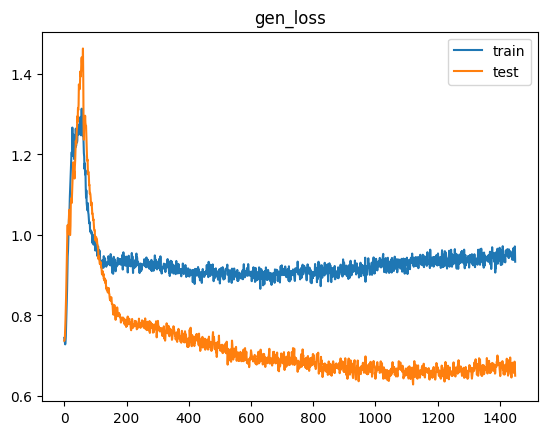

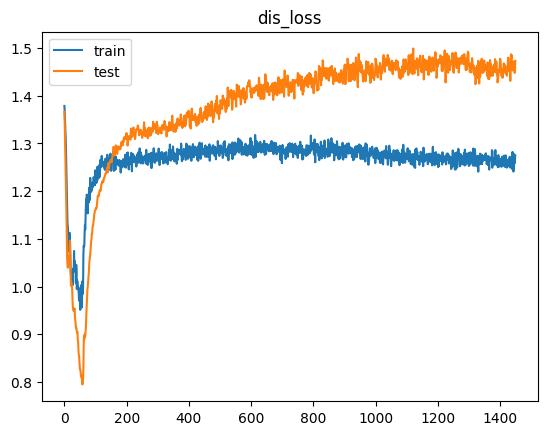

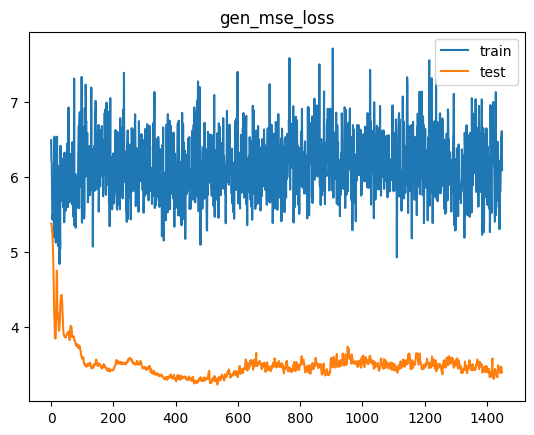

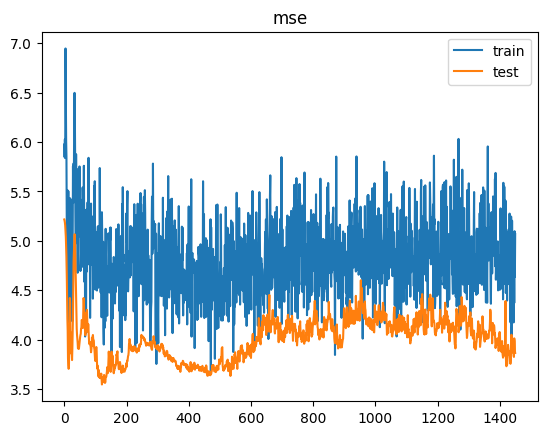

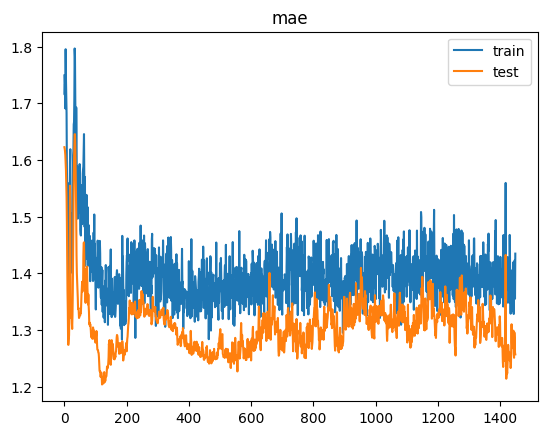

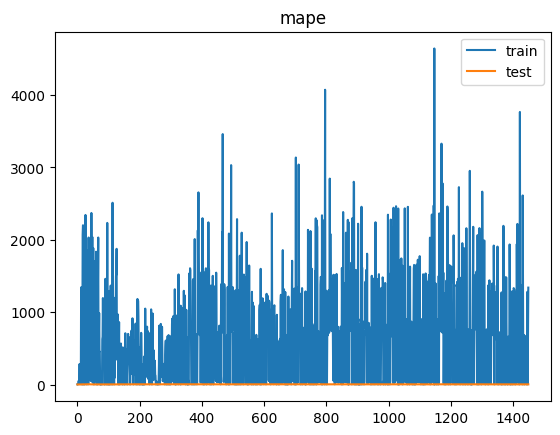

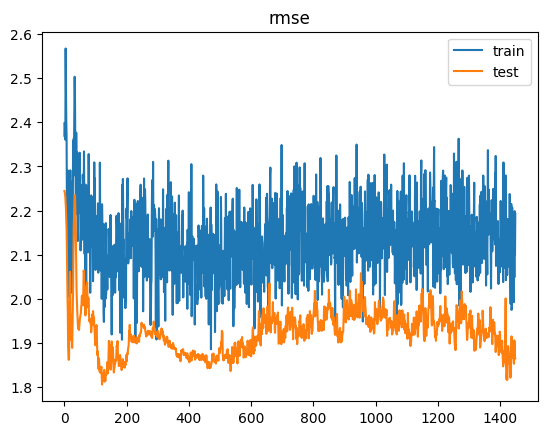

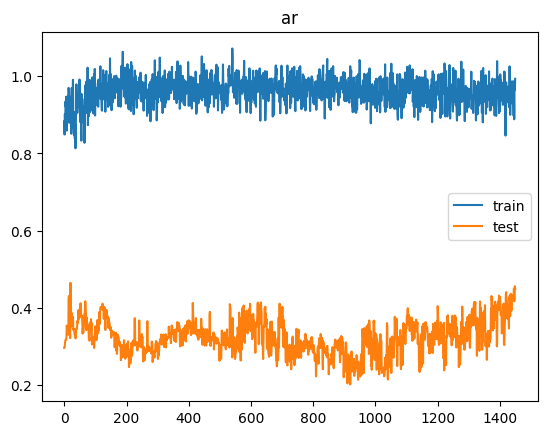

2/2 [==============================] - 0s 3ms/step


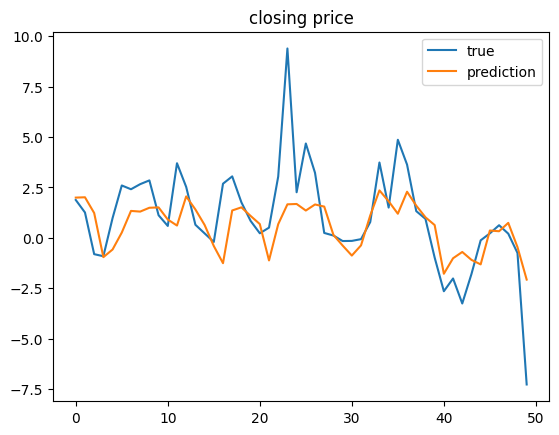

[MSE Baseline] train: 4.1598766370861  test: 3.634052838095099
Delta time with epochs = 1450: 0:11:52.877224


In [22]:
for epochs in [950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_14 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_14 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_15 (LSTM)              (None, 10)                840       
                                                           

Time for epoch 53 is 0.4703712463378906 sec Generator Loss: 1.0740306377410889,  Discriminator_loss: 1.142206072807312
Time for epoch 54 is 0.484241247177124 sec Generator Loss: 1.0854591131210327,  Discriminator_loss: 1.14859938621521
Time for epoch 55 is 0.47207164764404297 sec Generator Loss: 1.0779433250427246,  Discriminator_loss: 1.1396236419677734
Time for epoch 56 is 0.5038309097290039 sec Generator Loss: 1.081621766090393,  Discriminator_loss: 1.145390510559082
Time for epoch 57 is 0.7273399829864502 sec Generator Loss: 1.093850016593933,  Discriminator_loss: 1.1314274072647095
Time for epoch 58 is 0.6996471881866455 sec Generator Loss: 1.0852948427200317,  Discriminator_loss: 1.1504398584365845
Time for epoch 59 is 0.5074338912963867 sec Generator Loss: 1.0860543251037598,  Discriminator_loss: 1.1367875337600708
Time for epoch 60 is 0.4923522472381592 sec Generator Loss: 1.05341637134552,  Discriminator_loss: 1.1550356149673462
Time for epoch 61 is 0.47411084175109863 sec Gen

Time for epoch 122 is 0.4452691078186035 sec Generator Loss: 0.9438982009887695,  Discriminator_loss: 1.2394042015075684
Time for epoch 123 is 0.48825597763061523 sec Generator Loss: 0.9399123191833496,  Discriminator_loss: 1.254691481590271
Time for epoch 124 is 0.44593334197998047 sec Generator Loss: 0.9591467976570129,  Discriminator_loss: 1.2546968460083008
Time for epoch 125 is 0.4426758289337158 sec Generator Loss: 0.9363760352134705,  Discriminator_loss: 1.2636281251907349
Time for epoch 126 is 0.4550292491912842 sec Generator Loss: 0.9465327858924866,  Discriminator_loss: 1.257215142250061
Time for epoch 127 is 0.4796574115753174 sec Generator Loss: 0.9308791160583496,  Discriminator_loss: 1.2614680528640747
Time for epoch 128 is 0.5276870727539062 sec Generator Loss: 0.9355796575546265,  Discriminator_loss: 1.26010000705719
Time for epoch 129 is 0.516242265701294 sec Generator Loss: 0.9232862591743469,  Discriminator_loss: 1.2815115451812744
Time for epoch 130 is 0.52939128875

Time for epoch 190 is 0.44476795196533203 sec Generator Loss: 0.9045034050941467,  Discriminator_loss: 1.2855956554412842
Time for epoch 191 is 0.4454467296600342 sec Generator Loss: 0.8952587842941284,  Discriminator_loss: 1.301564335823059
Time for epoch 192 is 0.481243371963501 sec Generator Loss: 0.8983694911003113,  Discriminator_loss: 1.2864174842834473
Time for epoch 193 is 0.45229458808898926 sec Generator Loss: 0.9088213443756104,  Discriminator_loss: 1.2677723169326782
Time for epoch 194 is 0.5512807369232178 sec Generator Loss: 0.9088267087936401,  Discriminator_loss: 1.2838082313537598
Time for epoch 195 is 0.466475248336792 sec Generator Loss: 0.9220209121704102,  Discriminator_loss: 1.2771432399749756
Time for epoch 196 is 0.4391355514526367 sec Generator Loss: 0.9344223737716675,  Discriminator_loss: 1.2579152584075928
Time for epoch 197 is 0.44048380851745605 sec Generator Loss: 0.8994956612586975,  Discriminator_loss: 1.296950101852417
Time for epoch 198 is 0.466864824

Time for epoch 258 is 0.453580379486084 sec Generator Loss: 0.8949607014656067,  Discriminator_loss: 1.2997279167175293
Time for epoch 259 is 0.4470787048339844 sec Generator Loss: 0.8935394883155823,  Discriminator_loss: 1.2952957153320312
Time for epoch 260 is 0.5084290504455566 sec Generator Loss: 0.9093215465545654,  Discriminator_loss: 1.2775317430496216
Time for epoch 261 is 0.4494476318359375 sec Generator Loss: 0.9086448550224304,  Discriminator_loss: 1.2814369201660156
Time for epoch 262 is 0.4635035991668701 sec Generator Loss: 0.9028575420379639,  Discriminator_loss: 1.2863593101501465
Time for epoch 263 is 0.4396333694458008 sec Generator Loss: 0.8980967998504639,  Discriminator_loss: 1.2902759313583374
Time for epoch 264 is 0.439831018447876 sec Generator Loss: 0.9145222306251526,  Discriminator_loss: 1.277398705482483
Time for epoch 265 is 0.46595311164855957 sec Generator Loss: 0.9163100719451904,  Discriminator_loss: 1.293615698814392
Time for epoch 266 is 0.44202399253

Time for epoch 326 is 0.4427351951599121 sec Generator Loss: 0.911557674407959,  Discriminator_loss: 1.2770042419433594
Time for epoch 327 is 0.518164873123169 sec Generator Loss: 0.9007726907730103,  Discriminator_loss: 1.2898237705230713
Time for epoch 328 is 0.49086594581604004 sec Generator Loss: 0.9146543145179749,  Discriminator_loss: 1.270896315574646
Time for epoch 329 is 0.4738144874572754 sec Generator Loss: 0.9098842144012451,  Discriminator_loss: 1.2874091863632202
Time for epoch 330 is 0.4749312400817871 sec Generator Loss: 0.9029621481895447,  Discriminator_loss: 1.2804183959960938
Time for epoch 331 is 0.46923828125 sec Generator Loss: 0.9352253079414368,  Discriminator_loss: 1.2785249948501587
Time for epoch 332 is 0.5463347434997559 sec Generator Loss: 0.901005744934082,  Discriminator_loss: 1.2840574979782104
Time for epoch 333 is 0.5099024772644043 sec Generator Loss: 0.9072979092597961,  Discriminator_loss: 1.2782599925994873
Time for epoch 334 is 0.4848108291625976

Time for epoch 394 is 0.497636079788208 sec Generator Loss: 0.9019783139228821,  Discriminator_loss: 1.285502314567566
Time for epoch 395 is 0.44747042655944824 sec Generator Loss: 0.9003154635429382,  Discriminator_loss: 1.287474513053894
Time for epoch 396 is 0.46892261505126953 sec Generator Loss: 0.9009686708450317,  Discriminator_loss: 1.2987103462219238
Time for epoch 397 is 0.441570520401001 sec Generator Loss: 0.9107245802879333,  Discriminator_loss: 1.2854021787643433
Time for epoch 398 is 0.443894624710083 sec Generator Loss: 0.9112702012062073,  Discriminator_loss: 1.2838268280029297
Time for epoch 399 is 0.4431896209716797 sec Generator Loss: 0.8936479091644287,  Discriminator_loss: 1.3057137727737427
Time for epoch 400 is 0.4565446376800537 sec Generator Loss: 0.9102221727371216,  Discriminator_loss: 1.2836476564407349
Time for epoch 401 is 0.45381927490234375 sec Generator Loss: 0.8965341448783875,  Discriminator_loss: 1.2861896753311157
Time for epoch 402 is 0.4608139991

Time for epoch 462 is 0.49631166458129883 sec Generator Loss: 0.9096174836158752,  Discriminator_loss: 1.2964686155319214
Time for epoch 463 is 0.4895479679107666 sec Generator Loss: 0.9214962720870972,  Discriminator_loss: 1.2803165912628174
Time for epoch 464 is 0.4642634391784668 sec Generator Loss: 0.8927801847457886,  Discriminator_loss: 1.2851202487945557
Time for epoch 465 is 0.5653073787689209 sec Generator Loss: 0.9004355669021606,  Discriminator_loss: 1.280364751815796
Time for epoch 466 is 0.4918241500854492 sec Generator Loss: 0.8983393907546997,  Discriminator_loss: 1.2848047018051147
Time for epoch 467 is 0.5163569450378418 sec Generator Loss: 0.8954301476478577,  Discriminator_loss: 1.3004952669143677
Time for epoch 468 is 0.49000048637390137 sec Generator Loss: 0.902039110660553,  Discriminator_loss: 1.2779276371002197
Time for epoch 469 is 0.5004947185516357 sec Generator Loss: 0.8957446217536926,  Discriminator_loss: 1.3016295433044434
Time for epoch 470 is 0.46589708

Time for epoch 530 is 0.5314042568206787 sec Generator Loss: 0.9156519770622253,  Discriminator_loss: 1.2910090684890747
Time for epoch 531 is 0.5289816856384277 sec Generator Loss: 0.9161091446876526,  Discriminator_loss: 1.2793620824813843
Time for epoch 532 is 0.4619152545928955 sec Generator Loss: 0.9205873012542725,  Discriminator_loss: 1.2771153450012207
Time for epoch 533 is 0.46697497367858887 sec Generator Loss: 0.9001896381378174,  Discriminator_loss: 1.2870879173278809
Time for epoch 534 is 0.5521328449249268 sec Generator Loss: 0.9277302622795105,  Discriminator_loss: 1.2792409658432007
Time for epoch 535 is 0.6523668766021729 sec Generator Loss: 0.9108446836471558,  Discriminator_loss: 1.2882726192474365
Time for epoch 536 is 0.5016863346099854 sec Generator Loss: 0.8907173275947571,  Discriminator_loss: 1.2928670644760132
Time for epoch 537 is 0.6042289733886719 sec Generator Loss: 0.893297553062439,  Discriminator_loss: 1.286720871925354
Time for epoch 538 is 0.524491786

Time for epoch 598 is 0.5020003318786621 sec Generator Loss: 0.9024709463119507,  Discriminator_loss: 1.2829179763793945
Time for epoch 599 is 0.48865532875061035 sec Generator Loss: 0.9083074331283569,  Discriminator_loss: 1.294779658317566
Time for epoch 600 is 0.4587581157684326 sec Generator Loss: 0.9032509922981262,  Discriminator_loss: 1.285017490386963
Time for epoch 601 is 0.49669504165649414 sec Generator Loss: 0.9054333567619324,  Discriminator_loss: 1.2786157131195068
Time for epoch 602 is 0.6191332340240479 sec Generator Loss: 0.9197219014167786,  Discriminator_loss: 1.2816267013549805
Time for epoch 603 is 0.7554855346679688 sec Generator Loss: 0.8955592513084412,  Discriminator_loss: 1.298129677772522
Time for epoch 604 is 0.5827591419219971 sec Generator Loss: 0.9286089539527893,  Discriminator_loss: 1.2647902965545654
Time for epoch 605 is 0.5462703704833984 sec Generator Loss: 0.9076201319694519,  Discriminator_loss: 1.2951034307479858
Time for epoch 606 is 0.469903707

Time for epoch 666 is 0.45691943168640137 sec Generator Loss: 0.9165443778038025,  Discriminator_loss: 1.2758654356002808
Time for epoch 667 is 0.43741846084594727 sec Generator Loss: 0.913824200630188,  Discriminator_loss: 1.2876834869384766
Time for epoch 668 is 0.45556092262268066 sec Generator Loss: 0.9133245348930359,  Discriminator_loss: 1.2880932092666626
Time for epoch 669 is 0.4475710391998291 sec Generator Loss: 0.9188804030418396,  Discriminator_loss: 1.2823363542556763
Time for epoch 670 is 0.45007991790771484 sec Generator Loss: 0.9099636077880859,  Discriminator_loss: 1.2940974235534668
Time for epoch 671 is 0.4445819854736328 sec Generator Loss: 0.8997688889503479,  Discriminator_loss: 1.2963407039642334
Time for epoch 672 is 0.44592881202697754 sec Generator Loss: 0.8941264748573303,  Discriminator_loss: 1.282873272895813
Time for epoch 673 is 0.4633028507232666 sec Generator Loss: 0.9224495887756348,  Discriminator_loss: 1.2725944519042969
Time for epoch 674 is 0.44901

Time for epoch 734 is 0.48243021965026855 sec Generator Loss: 0.9135949611663818,  Discriminator_loss: 1.2705106735229492
Time for epoch 735 is 0.4583926200866699 sec Generator Loss: 0.9217662811279297,  Discriminator_loss: 1.275888442993164
Time for epoch 736 is 0.46226072311401367 sec Generator Loss: 0.9122059345245361,  Discriminator_loss: 1.275314211845398
Time for epoch 737 is 0.45361852645874023 sec Generator Loss: 0.9219749569892883,  Discriminator_loss: 1.2728588581085205
Time for epoch 738 is 0.4571826457977295 sec Generator Loss: 0.9153432846069336,  Discriminator_loss: 1.2785247564315796
Time for epoch 739 is 0.46753454208374023 sec Generator Loss: 0.9162944555282593,  Discriminator_loss: 1.2712960243225098
Time for epoch 740 is 0.4495067596435547 sec Generator Loss: 0.9246695637702942,  Discriminator_loss: 1.2825732231140137
Time for epoch 741 is 0.4519009590148926 sec Generator Loss: 0.9037995338439941,  Discriminator_loss: 1.2881296873092651
Time for epoch 742 is 0.469061

Time for epoch 802 is 0.6120731830596924 sec Generator Loss: 0.9167139530181885,  Discriminator_loss: 1.286159873008728
Time for epoch 803 is 0.5733785629272461 sec Generator Loss: 0.9185119271278381,  Discriminator_loss: 1.2746278047561646
Time for epoch 804 is 0.5875968933105469 sec Generator Loss: 0.9256523251533508,  Discriminator_loss: 1.277274250984192
Time for epoch 805 is 0.5567014217376709 sec Generator Loss: 0.9225554466247559,  Discriminator_loss: 1.2875672578811646
Time for epoch 806 is 0.5933945178985596 sec Generator Loss: 0.9203535914421082,  Discriminator_loss: 1.2820241451263428
Time for epoch 807 is 0.5817360877990723 sec Generator Loss: 0.9069393873214722,  Discriminator_loss: 1.2834872007369995
Time for epoch 808 is 0.5849921703338623 sec Generator Loss: 0.9032751321792603,  Discriminator_loss: 1.2799876928329468
Time for epoch 809 is 0.5500285625457764 sec Generator Loss: 0.9019618034362793,  Discriminator_loss: 1.2819640636444092
Time for epoch 810 is 0.5824823379

Time for epoch 870 is 0.5116055011749268 sec Generator Loss: 0.9168611764907837,  Discriminator_loss: 1.271796464920044
Time for epoch 871 is 0.5054440498352051 sec Generator Loss: 0.9092887043952942,  Discriminator_loss: 1.2905378341674805
Time for epoch 872 is 0.5092005729675293 sec Generator Loss: 0.9256353378295898,  Discriminator_loss: 1.283086895942688
Time for epoch 873 is 0.5054357051849365 sec Generator Loss: 0.9155516624450684,  Discriminator_loss: 1.2782232761383057
Time for epoch 874 is 0.5078315734863281 sec Generator Loss: 0.8923121094703674,  Discriminator_loss: 1.2969415187835693
Time for epoch 875 is 0.5469439029693604 sec Generator Loss: 0.9260859489440918,  Discriminator_loss: 1.2757501602172852
Time for epoch 876 is 0.5174343585968018 sec Generator Loss: 0.9076570868492126,  Discriminator_loss: 1.2749847173690796
Time for epoch 877 is 0.5234184265136719 sec Generator Loss: 0.9033170938491821,  Discriminator_loss: 1.2815701961517334
Time for epoch 878 is 0.5023589134

Time for epoch 938 is 0.5448260307312012 sec Generator Loss: 0.9329493045806885,  Discriminator_loss: 1.2742092609405518
Time for epoch 939 is 0.5335171222686768 sec Generator Loss: 0.9056061506271362,  Discriminator_loss: 1.276893138885498
Time for epoch 940 is 0.5102403163909912 sec Generator Loss: 0.9231790900230408,  Discriminator_loss: 1.2825005054473877
Time for epoch 941 is 0.523432731628418 sec Generator Loss: 0.9091939330101013,  Discriminator_loss: 1.285548448562622
Time for epoch 942 is 0.5187292098999023 sec Generator Loss: 0.9014829397201538,  Discriminator_loss: 1.2868558168411255
Time for epoch 943 is 0.5000011920928955 sec Generator Loss: 0.9132401943206787,  Discriminator_loss: 1.2737829685211182
Time for epoch 944 is 0.5358984470367432 sec Generator Loss: 0.9362650513648987,  Discriminator_loss: 1.2670927047729492
Time for epoch 945 is 0.5008010864257812 sec Generator Loss: 0.9234403967857361,  Discriminator_loss: 1.2741436958312988
Time for epoch 946 is 0.50288534164

Time for epoch 1006 is 0.5812146663665771 sec Generator Loss: 0.913705587387085,  Discriminator_loss: 1.2671998739242554
Time for epoch 1007 is 0.5959687232971191 sec Generator Loss: 0.9082649946212769,  Discriminator_loss: 1.2810369729995728
Time for epoch 1008 is 0.5648767948150635 sec Generator Loss: 0.9245131611824036,  Discriminator_loss: 1.27483332157135
Time for epoch 1009 is 0.5647928714752197 sec Generator Loss: 0.9193461537361145,  Discriminator_loss: 1.272377610206604
Time for epoch 1010 is 0.5884039402008057 sec Generator Loss: 0.9117167592048645,  Discriminator_loss: 1.2755500078201294
Time for epoch 1011 is 0.5561480522155762 sec Generator Loss: 0.9316933155059814,  Discriminator_loss: 1.2720950841903687
Time for epoch 1012 is 0.5796196460723877 sec Generator Loss: 0.9001551270484924,  Discriminator_loss: 1.270870566368103
Time for epoch 1013 is 0.567319393157959 sec Generator Loss: 0.9189974665641785,  Discriminator_loss: 1.2705856561660767
Time for epoch 1014 is 0.62159

Time for epoch 1074 is 0.44225597381591797 sec Generator Loss: 0.9166414141654968,  Discriminator_loss: 1.2746155261993408
Time for epoch 1075 is 0.4577198028564453 sec Generator Loss: 0.9176613688468933,  Discriminator_loss: 1.275493860244751
Time for epoch 1076 is 0.4530339241027832 sec Generator Loss: 0.9027754664421082,  Discriminator_loss: 1.2851440906524658
Time for epoch 1077 is 0.4596424102783203 sec Generator Loss: 0.9197437763214111,  Discriminator_loss: 1.2693121433258057
Time for epoch 1078 is 0.5171470642089844 sec Generator Loss: 0.9470546245574951,  Discriminator_loss: 1.2645282745361328
Time for epoch 1079 is 0.5495624542236328 sec Generator Loss: 0.9115815162658691,  Discriminator_loss: 1.274085521697998
Time for epoch 1080 is 0.5510525703430176 sec Generator Loss: 0.9041509628295898,  Discriminator_loss: 1.2764923572540283
Time for epoch 1081 is 0.5277609825134277 sec Generator Loss: 0.9215410351753235,  Discriminator_loss: 1.2707092761993408
Time for epoch 1082 is 0.

Time for epoch 1142 is 0.6305904388427734 sec Generator Loss: 0.9249718189239502,  Discriminator_loss: 1.267181158065796
Time for epoch 1143 is 0.5498721599578857 sec Generator Loss: 0.9008439183235168,  Discriminator_loss: 1.2890766859054565
Time for epoch 1144 is 0.5734243392944336 sec Generator Loss: 0.9182546734809875,  Discriminator_loss: 1.2733502388000488
Time for epoch 1145 is 0.5465917587280273 sec Generator Loss: 0.9356194138526917,  Discriminator_loss: 1.2629337310791016
Time for epoch 1146 is 0.5691900253295898 sec Generator Loss: 0.9216445088386536,  Discriminator_loss: 1.2662330865859985
Time for epoch 1147 is 0.5743951797485352 sec Generator Loss: 0.91982501745224,  Discriminator_loss: 1.2845345735549927
Time for epoch 1148 is 0.5618991851806641 sec Generator Loss: 0.9031379222869873,  Discriminator_loss: 1.2800498008728027
Time for epoch 1149 is 0.6046020984649658 sec Generator Loss: 0.926103413105011,  Discriminator_loss: 1.281080722808838
Time for epoch 1150 is 0.6174

Time for epoch 1210 is 0.48591017723083496 sec Generator Loss: 0.9447936415672302,  Discriminator_loss: 1.2650901079177856
Time for epoch 1211 is 0.5636351108551025 sec Generator Loss: 0.9227281808853149,  Discriminator_loss: 1.27757728099823
Time for epoch 1212 is 0.5393106937408447 sec Generator Loss: 0.9310861825942993,  Discriminator_loss: 1.2694708108901978
Time for epoch 1213 is 0.5103332996368408 sec Generator Loss: 0.9266707897186279,  Discriminator_loss: 1.2710222005844116
Time for epoch 1214 is 0.567641019821167 sec Generator Loss: 0.919179379940033,  Discriminator_loss: 1.26397705078125
Time for epoch 1215 is 0.4890766143798828 sec Generator Loss: 0.9323398470878601,  Discriminator_loss: 1.2721519470214844
Time for epoch 1216 is 0.4966928958892822 sec Generator Loss: 0.9210596084594727,  Discriminator_loss: 1.2668702602386475
Time for epoch 1217 is 0.5252573490142822 sec Generator Loss: 0.9378911256790161,  Discriminator_loss: 1.2626711130142212
Time for epoch 1218 is 0.4785

Time for epoch 1278 is 0.4696791172027588 sec Generator Loss: 0.9268369674682617,  Discriminator_loss: 1.270033597946167
Time for epoch 1279 is 0.46349430084228516 sec Generator Loss: 0.9228978753089905,  Discriminator_loss: 1.2641878128051758
Time for epoch 1280 is 0.4664912223815918 sec Generator Loss: 0.9304085373878479,  Discriminator_loss: 1.2671160697937012
Time for epoch 1281 is 0.4750361442565918 sec Generator Loss: 0.9167561531066895,  Discriminator_loss: 1.2688359022140503
Time for epoch 1282 is 0.47289204597473145 sec Generator Loss: 0.927413284778595,  Discriminator_loss: 1.2862894535064697
Time for epoch 1283 is 0.46150660514831543 sec Generator Loss: 0.9278078079223633,  Discriminator_loss: 1.2720919847488403
Time for epoch 1284 is 0.46401190757751465 sec Generator Loss: 0.9193588495254517,  Discriminator_loss: 1.278203010559082
Time for epoch 1285 is 0.4602987766265869 sec Generator Loss: 0.908255934715271,  Discriminator_loss: 1.2698440551757812
Time for epoch 1286 is 0

Time for epoch 1346 is 0.5093514919281006 sec Generator Loss: 0.92171311378479,  Discriminator_loss: 1.2772687673568726
Time for epoch 1347 is 0.536494255065918 sec Generator Loss: 0.9211298227310181,  Discriminator_loss: 1.2706263065338135
Time for epoch 1348 is 0.5436081886291504 sec Generator Loss: 0.9302737712860107,  Discriminator_loss: 1.2651941776275635
Time for epoch 1349 is 0.5172667503356934 sec Generator Loss: 0.9178938269615173,  Discriminator_loss: 1.266366720199585
Time for epoch 1350 is 0.5024874210357666 sec Generator Loss: 0.9284399151802063,  Discriminator_loss: 1.2590465545654297
Time for epoch 1351 is 0.5088376998901367 sec Generator Loss: 0.9402667284011841,  Discriminator_loss: 1.2666935920715332
Time for epoch 1352 is 0.5124623775482178 sec Generator Loss: 0.9376887679100037,  Discriminator_loss: 1.2632331848144531
Time for epoch 1353 is 0.5059792995452881 sec Generator Loss: 0.9525493383407593,  Discriminator_loss: 1.265544056892395
Time for epoch 1354 is 0.5734

Time for epoch 1414 is 0.45965099334716797 sec Generator Loss: 0.9558776021003723,  Discriminator_loss: 1.2649288177490234
Time for epoch 1415 is 0.48975253105163574 sec Generator Loss: 0.9277067184448242,  Discriminator_loss: 1.2790932655334473
Time for epoch 1416 is 0.4587850570678711 sec Generator Loss: 0.9253032207489014,  Discriminator_loss: 1.2636247873306274
Time for epoch 1417 is 0.48272061347961426 sec Generator Loss: 0.960792601108551,  Discriminator_loss: 1.2442553043365479
Time for epoch 1418 is 0.46227216720581055 sec Generator Loss: 0.9420652985572815,  Discriminator_loss: 1.2621515989303589
Time for epoch 1419 is 0.47655630111694336 sec Generator Loss: 0.9121488928794861,  Discriminator_loss: 1.2864537239074707
Time for epoch 1420 is 0.5153276920318604 sec Generator Loss: 0.9215407967567444,  Discriminator_loss: 1.275032877922058
Time for epoch 1421 is 0.47006916999816895 sec Generator Loss: 0.9090388417243958,  Discriminator_loss: 1.2818853855133057
Time for epoch 1422 

Time for epoch 1482 is 0.5476374626159668 sec Generator Loss: 0.9177308082580566,  Discriminator_loss: 1.2763478755950928
Time for epoch 1483 is 0.5773587226867676 sec Generator Loss: 0.9232683777809143,  Discriminator_loss: 1.2782154083251953
Time for epoch 1484 is 0.6674439907073975 sec Generator Loss: 0.9068083763122559,  Discriminator_loss: 1.2757025957107544
Time for epoch 1485 is 0.5148580074310303 sec Generator Loss: 0.9201330542564392,  Discriminator_loss: 1.2690882682800293
Time for epoch 1486 is 0.5185036659240723 sec Generator Loss: 0.9304783344268799,  Discriminator_loss: 1.2661596536636353
Time for epoch 1487 is 0.5470783710479736 sec Generator Loss: 0.9350705742835999,  Discriminator_loss: 1.2661494016647339
Time for epoch 1488 is 0.7639422416687012 sec Generator Loss: 0.9256876111030579,  Discriminator_loss: 1.267764687538147
Time for epoch 1489 is 0.539358377456665 sec Generator Loss: 0.9371086955070496,  Discriminator_loss: 1.268024206161499
Time for epoch 1490 is 0.59

Time for epoch 1550 is 0.4692831039428711 sec Generator Loss: 0.9119119644165039,  Discriminator_loss: 1.274507999420166
Time for epoch 1551 is 0.45988893508911133 sec Generator Loss: 0.9375929236412048,  Discriminator_loss: 1.264402151107788
Time for epoch 1552 is 0.47554564476013184 sec Generator Loss: 0.9259119629859924,  Discriminator_loss: 1.281557321548462
Time for epoch 1553 is 0.46340322494506836 sec Generator Loss: 0.9373596906661987,  Discriminator_loss: 1.2721441984176636
Time for epoch 1554 is 0.5353133678436279 sec Generator Loss: 0.9451543688774109,  Discriminator_loss: 1.26457941532135
Time for epoch 1555 is 0.49365830421447754 sec Generator Loss: 0.9147393107414246,  Discriminator_loss: 1.2723604440689087
Time for epoch 1556 is 0.4671149253845215 sec Generator Loss: 0.9244074821472168,  Discriminator_loss: 1.2860108613967896
Time for epoch 1557 is 0.4621725082397461 sec Generator Loss: 0.9233938455581665,  Discriminator_loss: 1.2644660472869873
Time for epoch 1558 is 0.

Time for epoch 1618 is 0.46570754051208496 sec Generator Loss: 0.9389801621437073,  Discriminator_loss: 1.2580597400665283
Time for epoch 1619 is 0.4892134666442871 sec Generator Loss: 0.9217959642410278,  Discriminator_loss: 1.2673606872558594
Time for epoch 1620 is 0.4666733741760254 sec Generator Loss: 0.9516736268997192,  Discriminator_loss: 1.2608342170715332
Time for epoch 1621 is 0.49449944496154785 sec Generator Loss: 0.9445496201515198,  Discriminator_loss: 1.2585705518722534
Time for epoch 1622 is 0.4596998691558838 sec Generator Loss: 0.9356790781021118,  Discriminator_loss: 1.2604788541793823
Time for epoch 1623 is 0.46273326873779297 sec Generator Loss: 0.9240366220474243,  Discriminator_loss: 1.264225721359253
Time for epoch 1624 is 0.490246057510376 sec Generator Loss: 0.9373290538787842,  Discriminator_loss: 1.2562947273254395
Time for epoch 1625 is 0.4972705841064453 sec Generator Loss: 0.9356404542922974,  Discriminator_loss: 1.2681620121002197
Time for epoch 1626 is 

Time for epoch 1686 is 0.4887123107910156 sec Generator Loss: 0.9274078011512756,  Discriminator_loss: 1.2600860595703125
Time for epoch 1687 is 0.46294116973876953 sec Generator Loss: 0.9378745555877686,  Discriminator_loss: 1.2637825012207031
Time for epoch 1688 is 0.48477721214294434 sec Generator Loss: 0.9163356423377991,  Discriminator_loss: 1.2649425268173218
Time for epoch 1689 is 0.46515989303588867 sec Generator Loss: 0.923542857170105,  Discriminator_loss: 1.2614953517913818
Time for epoch 1690 is 0.46416187286376953 sec Generator Loss: 0.9416704177856445,  Discriminator_loss: 1.2587064504623413
Time for epoch 1691 is 0.46772265434265137 sec Generator Loss: 0.9228881001472473,  Discriminator_loss: 1.2750494480133057
Time for epoch 1692 is 0.46305418014526367 sec Generator Loss: 0.9398832321166992,  Discriminator_loss: 1.2566951513290405
Time for epoch 1693 is 0.4666016101837158 sec Generator Loss: 0.9243108034133911,  Discriminator_loss: 1.2635998725891113
Time for epoch 1694

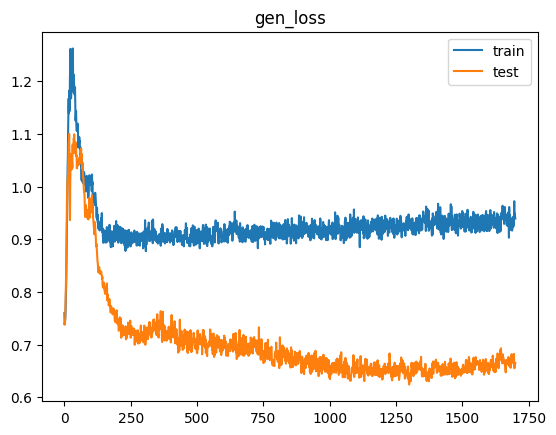

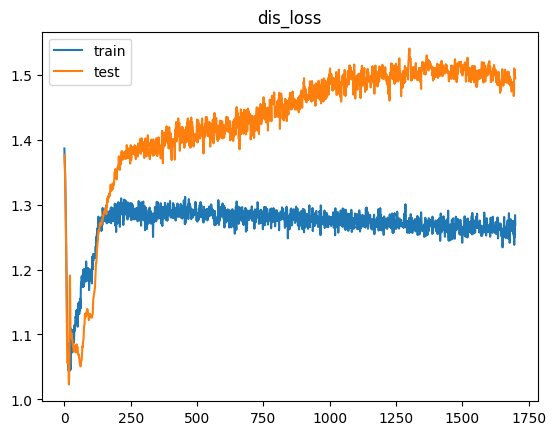

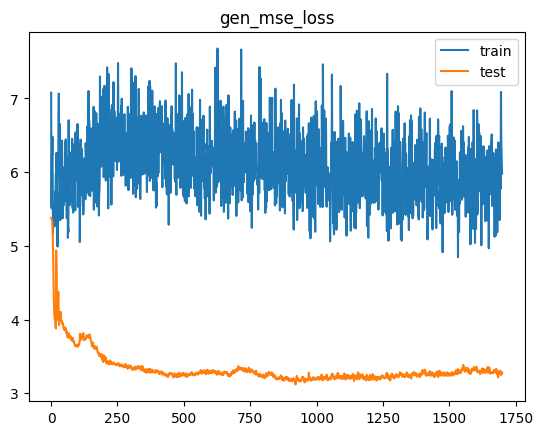

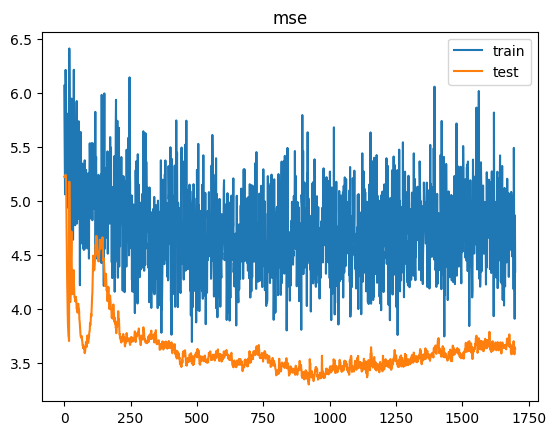

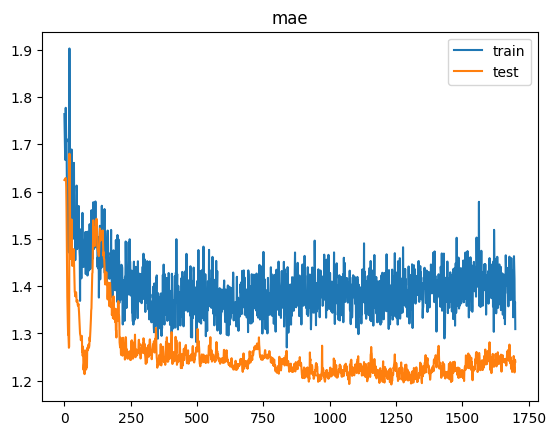

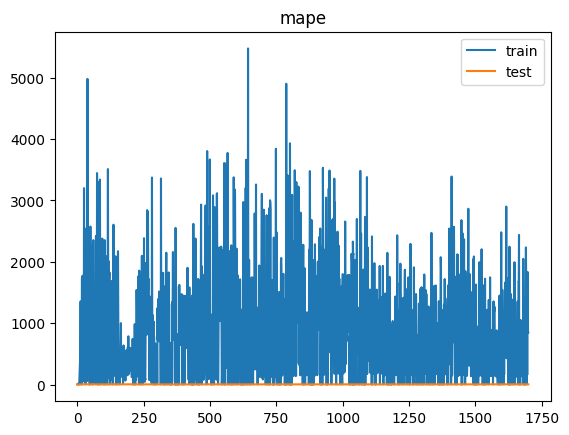

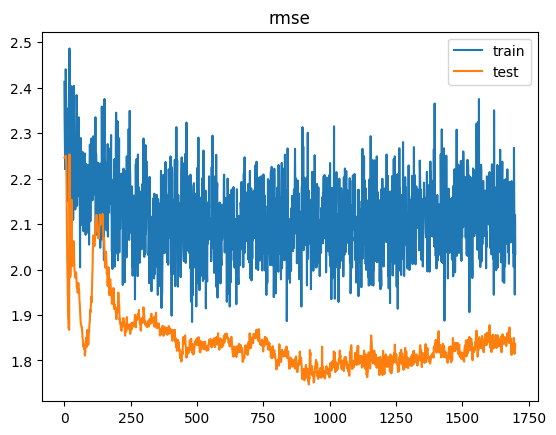

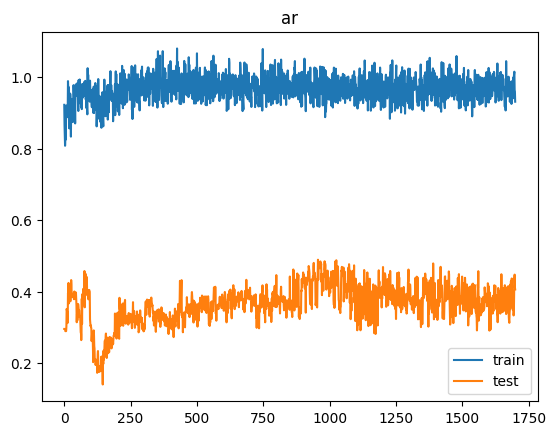

2/2 [==============================] - 0s 4ms/step


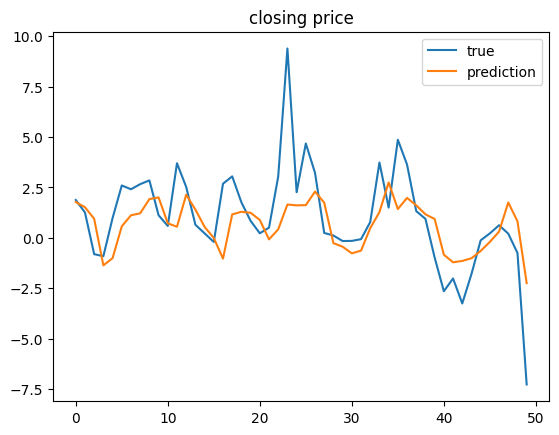

[MSE Baseline] train: 4.356415161928168  test: 3.634052838095099
Delta time with epochs = 1700: 0:14:37.711012
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_16 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_40 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_17 (LSTM

Time for epoch 52 is 0.46709704399108887 sec Generator Loss: 1.1947089433670044,  Discriminator_loss: 1.0607972145080566
Time for epoch 53 is 0.47499632835388184 sec Generator Loss: 1.1887199878692627,  Discriminator_loss: 1.0885186195373535
Time for epoch 54 is 0.4637904167175293 sec Generator Loss: 1.1874455213546753,  Discriminator_loss: 1.0812324285507202
Time for epoch 55 is 0.4693014621734619 sec Generator Loss: 1.1838557720184326,  Discriminator_loss: 1.0690799951553345
Time for epoch 56 is 0.47122788429260254 sec Generator Loss: 1.1628178358078003,  Discriminator_loss: 1.0848170518875122
Time for epoch 57 is 0.4695110321044922 sec Generator Loss: 1.2015259265899658,  Discriminator_loss: 1.0680747032165527
Time for epoch 58 is 0.4715259075164795 sec Generator Loss: 1.191259741783142,  Discriminator_loss: 1.0468559265136719
Time for epoch 59 is 0.4613380432128906 sec Generator Loss: 1.2139811515808105,  Discriminator_loss: 1.0518956184387207
Time for epoch 60 is 0.464385271072387

Time for epoch 121 is 0.47112011909484863 sec Generator Loss: 0.9596971273422241,  Discriminator_loss: 1.2461872100830078
Time for epoch 122 is 0.4750802516937256 sec Generator Loss: 0.9649413824081421,  Discriminator_loss: 1.2444530725479126
Time for epoch 123 is 0.4928548336029053 sec Generator Loss: 0.9493860602378845,  Discriminator_loss: 1.2536054849624634
Time for epoch 124 is 0.506889820098877 sec Generator Loss: 0.9545183777809143,  Discriminator_loss: 1.2555898427963257
Time for epoch 125 is 0.5264599323272705 sec Generator Loss: 0.9432002902030945,  Discriminator_loss: 1.270248293876648
Time for epoch 126 is 0.4919557571411133 sec Generator Loss: 0.9334027767181396,  Discriminator_loss: 1.2741632461547852
Time for epoch 127 is 0.5021312236785889 sec Generator Loss: 0.9395114183425903,  Discriminator_loss: 1.2713223695755005
Time for epoch 128 is 0.513714075088501 sec Generator Loss: 0.9487790465354919,  Discriminator_loss: 1.259239673614502
Time for epoch 129 is 0.55560445785

Time for epoch 189 is 0.46468210220336914 sec Generator Loss: 0.9255607724189758,  Discriminator_loss: 1.2772464752197266
Time for epoch 190 is 0.49101686477661133 sec Generator Loss: 0.9122804403305054,  Discriminator_loss: 1.2810133695602417
Time for epoch 191 is 0.46883678436279297 sec Generator Loss: 0.8986769914627075,  Discriminator_loss: 1.2805231809616089
Time for epoch 192 is 0.4624321460723877 sec Generator Loss: 0.9267800450325012,  Discriminator_loss: 1.2800891399383545
Time for epoch 193 is 0.47702741622924805 sec Generator Loss: 0.9155588746070862,  Discriminator_loss: 1.280658483505249
Time for epoch 194 is 0.4771714210510254 sec Generator Loss: 0.9030147194862366,  Discriminator_loss: 1.3002911806106567
Time for epoch 195 is 0.47174072265625 sec Generator Loss: 0.9176341891288757,  Discriminator_loss: 1.2815486192703247
Time for epoch 196 is 0.47121500968933105 sec Generator Loss: 0.8961526155471802,  Discriminator_loss: 1.298429250717163
Time for epoch 197 is 0.4702336

Time for epoch 257 is 0.5029418468475342 sec Generator Loss: 0.915160059928894,  Discriminator_loss: 1.2855218648910522
Time for epoch 258 is 0.5652017593383789 sec Generator Loss: 0.9041534066200256,  Discriminator_loss: 1.2882460355758667
Time for epoch 259 is 0.5721776485443115 sec Generator Loss: 0.9137127995491028,  Discriminator_loss: 1.2724887132644653
Time for epoch 260 is 0.520148515701294 sec Generator Loss: 0.9163218140602112,  Discriminator_loss: 1.2861522436141968
Time for epoch 261 is 0.4914398193359375 sec Generator Loss: 0.9265616536140442,  Discriminator_loss: 1.2618218660354614
Time for epoch 262 is 0.5228755474090576 sec Generator Loss: 0.9369027018547058,  Discriminator_loss: 1.2641185522079468
Time for epoch 263 is 0.49813246726989746 sec Generator Loss: 0.9121589660644531,  Discriminator_loss: 1.288689136505127
Time for epoch 264 is 0.607475757598877 sec Generator Loss: 0.9136931896209717,  Discriminator_loss: 1.296094298362732
Time for epoch 265 is 0.525648832321

Time for epoch 325 is 0.5431451797485352 sec Generator Loss: 0.919418454170227,  Discriminator_loss: 1.2782734632492065
Time for epoch 326 is 0.4860067367553711 sec Generator Loss: 0.9064784646034241,  Discriminator_loss: 1.280535340309143
Time for epoch 327 is 0.5339584350585938 sec Generator Loss: 0.9225367307662964,  Discriminator_loss: 1.2754261493682861
Time for epoch 328 is 0.5111386775970459 sec Generator Loss: 0.9177735447883606,  Discriminator_loss: 1.278781533241272
Time for epoch 329 is 0.512855052947998 sec Generator Loss: 0.9055459499359131,  Discriminator_loss: 1.2913302183151245
Time for epoch 330 is 0.5295696258544922 sec Generator Loss: 0.9160657525062561,  Discriminator_loss: 1.2698109149932861
Time for epoch 331 is 0.4944117069244385 sec Generator Loss: 0.9090490341186523,  Discriminator_loss: 1.2814593315124512
Time for epoch 332 is 0.500697135925293 sec Generator Loss: 0.9281429052352905,  Discriminator_loss: 1.274626612663269
Time for epoch 333 is 0.50210857391357

Time for epoch 393 is 0.585597038269043 sec Generator Loss: 0.8930215239524841,  Discriminator_loss: 1.2854056358337402
Time for epoch 394 is 0.5724790096282959 sec Generator Loss: 0.91232830286026,  Discriminator_loss: 1.276533842086792
Time for epoch 395 is 0.5596306324005127 sec Generator Loss: 0.8977878093719482,  Discriminator_loss: 1.287757158279419
Time for epoch 396 is 0.5324389934539795 sec Generator Loss: 0.89408940076828,  Discriminator_loss: 1.2845536470413208
Time for epoch 397 is 0.5418655872344971 sec Generator Loss: 0.9021076560020447,  Discriminator_loss: 1.2841837406158447
Time for epoch 398 is 0.6007061004638672 sec Generator Loss: 0.9166739583015442,  Discriminator_loss: 1.2787928581237793
Time for epoch 399 is 0.6744394302368164 sec Generator Loss: 0.8921907544136047,  Discriminator_loss: 1.2960700988769531
Time for epoch 400 is 0.6825110912322998 sec Generator Loss: 0.8934446573257446,  Discriminator_loss: 1.2910375595092773
Time for epoch 401 is 0.547603130340576

Time for epoch 462 is 0.5661282539367676 sec Generator Loss: 0.9220423698425293,  Discriminator_loss: 1.2774134874343872
Time for epoch 463 is 0.5762403011322021 sec Generator Loss: 0.9273812770843506,  Discriminator_loss: 1.2733495235443115
Time for epoch 464 is 0.5678868293762207 sec Generator Loss: 0.8827383518218994,  Discriminator_loss: 1.2925455570220947
Time for epoch 465 is 0.5749392509460449 sec Generator Loss: 0.9147365689277649,  Discriminator_loss: 1.2716238498687744
Time for epoch 466 is 0.604191780090332 sec Generator Loss: 0.88459712266922,  Discriminator_loss: 1.2934304475784302
Time for epoch 467 is 0.6737968921661377 sec Generator Loss: 0.9043266177177429,  Discriminator_loss: 1.2892940044403076
Time for epoch 468 is 0.7102656364440918 sec Generator Loss: 0.8980075716972351,  Discriminator_loss: 1.2945945262908936
Time for epoch 469 is 0.6914801597595215 sec Generator Loss: 0.9043093919754028,  Discriminator_loss: 1.2863013744354248
Time for epoch 470 is 0.59062838554

Time for epoch 530 is 0.4770019054412842 sec Generator Loss: 0.8971999287605286,  Discriminator_loss: 1.2844280004501343
Time for epoch 531 is 0.4801297187805176 sec Generator Loss: 0.89434814453125,  Discriminator_loss: 1.2898799180984497
Time for epoch 532 is 0.48966503143310547 sec Generator Loss: 0.9024211764335632,  Discriminator_loss: 1.28909170627594
Time for epoch 533 is 0.4884529113769531 sec Generator Loss: 0.8851659297943115,  Discriminator_loss: 1.2816553115844727
Time for epoch 534 is 0.5193934440612793 sec Generator Loss: 0.9017568826675415,  Discriminator_loss: 1.286393165588379
Time for epoch 535 is 0.47724270820617676 sec Generator Loss: 0.9130773544311523,  Discriminator_loss: 1.2649739980697632
Time for epoch 536 is 0.48737192153930664 sec Generator Loss: 0.8880454897880554,  Discriminator_loss: 1.2846201658248901
Time for epoch 537 is 0.4870591163635254 sec Generator Loss: 0.9022867679595947,  Discriminator_loss: 1.2819790840148926
Time for epoch 538 is 0.4847238063

Time for epoch 598 is 0.5604746341705322 sec Generator Loss: 0.8860160112380981,  Discriminator_loss: 1.3029717206954956
Time for epoch 599 is 0.5765120983123779 sec Generator Loss: 0.9005948901176453,  Discriminator_loss: 1.2921667098999023
Time for epoch 600 is 0.4930737018585205 sec Generator Loss: 0.9171240925788879,  Discriminator_loss: 1.2792702913284302
Time for epoch 601 is 0.5318362712860107 sec Generator Loss: 0.8909537196159363,  Discriminator_loss: 1.2917020320892334
Time for epoch 602 is 0.6025278568267822 sec Generator Loss: 0.9026703834533691,  Discriminator_loss: 1.2747455835342407
Time for epoch 603 is 0.5717766284942627 sec Generator Loss: 0.900365948677063,  Discriminator_loss: 1.2842504978179932
Time for epoch 604 is 0.5310220718383789 sec Generator Loss: 0.9141545295715332,  Discriminator_loss: 1.2808654308319092
Time for epoch 605 is 0.5506582260131836 sec Generator Loss: 0.8982885479927063,  Discriminator_loss: 1.2795438766479492
Time for epoch 606 is 0.523118257

Time for epoch 666 is 0.5051193237304688 sec Generator Loss: 0.9206399321556091,  Discriminator_loss: 1.2673643827438354
Time for epoch 667 is 0.4877965450286865 sec Generator Loss: 0.9117164611816406,  Discriminator_loss: 1.2840185165405273
Time for epoch 668 is 0.4886593818664551 sec Generator Loss: 0.9199956655502319,  Discriminator_loss: 1.2775768041610718
Time for epoch 669 is 0.48540568351745605 sec Generator Loss: 0.9101969003677368,  Discriminator_loss: 1.274391770362854
Time for epoch 670 is 0.4922292232513428 sec Generator Loss: 0.9101453423500061,  Discriminator_loss: 1.273432731628418
Time for epoch 671 is 0.5090243816375732 sec Generator Loss: 0.911139726638794,  Discriminator_loss: 1.2877566814422607
Time for epoch 672 is 0.5063421726226807 sec Generator Loss: 0.9264764785766602,  Discriminator_loss: 1.264061450958252
Time for epoch 673 is 0.4816470146179199 sec Generator Loss: 0.9425246119499207,  Discriminator_loss: 1.2677326202392578
Time for epoch 674 is 0.47853136062

Time for epoch 734 is 0.5132861137390137 sec Generator Loss: 0.9083772301673889,  Discriminator_loss: 1.289917230606079
Time for epoch 735 is 0.5600998401641846 sec Generator Loss: 0.9304238557815552,  Discriminator_loss: 1.2719097137451172
Time for epoch 736 is 0.48705577850341797 sec Generator Loss: 0.912155032157898,  Discriminator_loss: 1.2712026834487915
Time for epoch 737 is 0.4967184066772461 sec Generator Loss: 0.9273439645767212,  Discriminator_loss: 1.266434907913208
Time for epoch 738 is 0.561009407043457 sec Generator Loss: 0.9180184602737427,  Discriminator_loss: 1.2728931903839111
Time for epoch 739 is 0.5452785491943359 sec Generator Loss: 0.916057288646698,  Discriminator_loss: 1.2867753505706787
Time for epoch 740 is 0.49019455909729004 sec Generator Loss: 0.9160947203636169,  Discriminator_loss: 1.2854652404785156
Time for epoch 741 is 0.5049569606781006 sec Generator Loss: 0.9097458124160767,  Discriminator_loss: 1.2733670473098755
Time for epoch 742 is 0.48413634300

Time for epoch 802 is 0.4849827289581299 sec Generator Loss: 0.9109370112419128,  Discriminator_loss: 1.2726961374282837
Time for epoch 803 is 0.5643625259399414 sec Generator Loss: 0.9120848774909973,  Discriminator_loss: 1.27640962600708
Time for epoch 804 is 0.5424134731292725 sec Generator Loss: 0.9154946804046631,  Discriminator_loss: 1.2751458883285522
Time for epoch 805 is 0.48829221725463867 sec Generator Loss: 0.9310545325279236,  Discriminator_loss: 1.2650787830352783
Time for epoch 806 is 0.5284621715545654 sec Generator Loss: 0.9236970543861389,  Discriminator_loss: 1.2667136192321777
Time for epoch 807 is 0.48531365394592285 sec Generator Loss: 0.9330085515975952,  Discriminator_loss: 1.269213318824768
Time for epoch 808 is 0.5609347820281982 sec Generator Loss: 0.9393885731697083,  Discriminator_loss: 1.2676132917404175
Time for epoch 809 is 0.5270569324493408 sec Generator Loss: 0.9166352152824402,  Discriminator_loss: 1.2733029127120972
Time for epoch 810 is 0.551630496

Time for epoch 870 is 0.4891960620880127 sec Generator Loss: 0.9175195693969727,  Discriminator_loss: 1.2837079763412476
Time for epoch 871 is 0.4767584800720215 sec Generator Loss: 0.9105995297431946,  Discriminator_loss: 1.2798527479171753
Time for epoch 872 is 0.48569822311401367 sec Generator Loss: 0.9120100140571594,  Discriminator_loss: 1.2687209844589233
Time for epoch 873 is 0.5091853141784668 sec Generator Loss: 0.9137800335884094,  Discriminator_loss: 1.2668664455413818
Time for epoch 874 is 0.48862743377685547 sec Generator Loss: 0.9210803508758545,  Discriminator_loss: 1.2762120962142944
Time for epoch 875 is 0.4964408874511719 sec Generator Loss: 0.925932765007019,  Discriminator_loss: 1.2633622884750366
Time for epoch 876 is 0.5054628849029541 sec Generator Loss: 0.9178065061569214,  Discriminator_loss: 1.282164216041565
Time for epoch 877 is 0.4933340549468994 sec Generator Loss: 0.896261990070343,  Discriminator_loss: 1.2946903705596924
Time for epoch 878 is 0.526659488

Time for epoch 938 is 0.5450975894927979 sec Generator Loss: 0.9405913352966309,  Discriminator_loss: 1.2497258186340332
Time for epoch 939 is 0.5163259506225586 sec Generator Loss: 0.9263463020324707,  Discriminator_loss: 1.2827094793319702
Time for epoch 940 is 0.511082649230957 sec Generator Loss: 0.9240687489509583,  Discriminator_loss: 1.2819926738739014
Time for epoch 941 is 0.5262033939361572 sec Generator Loss: 0.9306385517120361,  Discriminator_loss: 1.2748359441757202
Time for epoch 942 is 0.5360782146453857 sec Generator Loss: 0.9164090752601624,  Discriminator_loss: 1.2764209508895874
Time for epoch 943 is 0.5196287631988525 sec Generator Loss: 0.9344528317451477,  Discriminator_loss: 1.261230707168579
Time for epoch 944 is 0.552901029586792 sec Generator Loss: 0.9217885136604309,  Discriminator_loss: 1.2721871137619019
Time for epoch 945 is 0.5377805233001709 sec Generator Loss: 0.9166263341903687,  Discriminator_loss: 1.2796155214309692
Time for epoch 946 is 0.54863214492

Time for epoch 1006 is 0.5369634628295898 sec Generator Loss: 0.9294820427894592,  Discriminator_loss: 1.2688077688217163
Time for epoch 1007 is 0.5243575572967529 sec Generator Loss: 0.9265566468238831,  Discriminator_loss: 1.2704577445983887
Time for epoch 1008 is 0.5085892677307129 sec Generator Loss: 0.957974910736084,  Discriminator_loss: 1.257961630821228
Time for epoch 1009 is 0.48787808418273926 sec Generator Loss: 0.9170601963996887,  Discriminator_loss: 1.2838622331619263
Time for epoch 1010 is 0.5131239891052246 sec Generator Loss: 0.9481004476547241,  Discriminator_loss: 1.2615832090377808
Time for epoch 1011 is 0.4873158931732178 sec Generator Loss: 0.9360008835792542,  Discriminator_loss: 1.251631498336792
Time for epoch 1012 is 0.5535199642181396 sec Generator Loss: 0.9464899301528931,  Discriminator_loss: 1.2714279890060425
Time for epoch 1013 is 0.5267276763916016 sec Generator Loss: 0.9273821115493774,  Discriminator_loss: 1.2875055074691772
Time for epoch 1014 is 0.5

Time for epoch 1074 is 0.5402040481567383 sec Generator Loss: 0.9547726511955261,  Discriminator_loss: 1.2562475204467773
Time for epoch 1075 is 0.5701620578765869 sec Generator Loss: 0.9144718050956726,  Discriminator_loss: 1.281579613685608
Time for epoch 1076 is 0.5714936256408691 sec Generator Loss: 0.9256631731987,  Discriminator_loss: 1.2893540859222412
Time for epoch 1077 is 0.5222458839416504 sec Generator Loss: 0.92149418592453,  Discriminator_loss: 1.268270492553711
Time for epoch 1078 is 0.5509228706359863 sec Generator Loss: 0.9273464679718018,  Discriminator_loss: 1.272711992263794
Time for epoch 1079 is 0.5355660915374756 sec Generator Loss: 0.9356576800346375,  Discriminator_loss: 1.265082836151123
Time for epoch 1080 is 0.5383267402648926 sec Generator Loss: 0.9311822056770325,  Discriminator_loss: 1.275718092918396
Time for epoch 1081 is 0.5600607395172119 sec Generator Loss: 0.9434342980384827,  Discriminator_loss: 1.258960485458374
Time for epoch 1082 is 0.5763602256

Time for epoch 1142 is 0.49661731719970703 sec Generator Loss: 0.9188658595085144,  Discriminator_loss: 1.2783658504486084
Time for epoch 1143 is 0.4975461959838867 sec Generator Loss: 0.9374113082885742,  Discriminator_loss: 1.267318606376648
Time for epoch 1144 is 0.5009875297546387 sec Generator Loss: 0.9493271708488464,  Discriminator_loss: 1.2685884237289429
Time for epoch 1145 is 0.48947858810424805 sec Generator Loss: 0.9538351893424988,  Discriminator_loss: 1.254758596420288
Time for epoch 1146 is 0.49847936630249023 sec Generator Loss: 0.9272436499595642,  Discriminator_loss: 1.2987122535705566
Time for epoch 1147 is 0.5339913368225098 sec Generator Loss: 0.9250549674034119,  Discriminator_loss: 1.2785110473632812
Time for epoch 1148 is 0.49742555618286133 sec Generator Loss: 0.9428243041038513,  Discriminator_loss: 1.2734400033950806
Time for epoch 1149 is 0.5076298713684082 sec Generator Loss: 0.934921145439148,  Discriminator_loss: 1.2645981311798096
Time for epoch 1150 is 

Time for epoch 1210 is 0.5492768287658691 sec Generator Loss: 0.923334002494812,  Discriminator_loss: 1.2765580415725708
Time for epoch 1211 is 0.5363211631774902 sec Generator Loss: 0.9314106106758118,  Discriminator_loss: 1.2764461040496826
Time for epoch 1212 is 0.5452337265014648 sec Generator Loss: 0.9488350749015808,  Discriminator_loss: 1.256296157836914
Time for epoch 1213 is 0.5783789157867432 sec Generator Loss: 0.9666341543197632,  Discriminator_loss: 1.2693077325820923
Time for epoch 1214 is 0.4974489212036133 sec Generator Loss: 0.9343529343605042,  Discriminator_loss: 1.2683368921279907
Time for epoch 1215 is 0.5199410915374756 sec Generator Loss: 0.9436575770378113,  Discriminator_loss: 1.2719782590866089
Time for epoch 1216 is 0.49519944190979004 sec Generator Loss: 0.9406551122665405,  Discriminator_loss: 1.2772135734558105
Time for epoch 1217 is 0.538231372833252 sec Generator Loss: 0.9202685356140137,  Discriminator_loss: 1.2852340936660767
Time for epoch 1218 is 0.5

Time for epoch 1278 is 0.5428242683410645 sec Generator Loss: 0.9321771264076233,  Discriminator_loss: 1.275991678237915
Time for epoch 1279 is 0.5547802448272705 sec Generator Loss: 0.9205314517021179,  Discriminator_loss: 1.2855442762374878
Time for epoch 1280 is 0.5551538467407227 sec Generator Loss: 0.9217769503593445,  Discriminator_loss: 1.2799537181854248
Time for epoch 1281 is 0.6291980743408203 sec Generator Loss: 0.9423592686653137,  Discriminator_loss: 1.27639639377594
Time for epoch 1282 is 0.5281813144683838 sec Generator Loss: 0.9171397089958191,  Discriminator_loss: 1.2954808473587036
Time for epoch 1283 is 0.5524311065673828 sec Generator Loss: 0.9094511270523071,  Discriminator_loss: 1.2801669836044312
Time for epoch 1284 is 0.5417807102203369 sec Generator Loss: 0.9225859642028809,  Discriminator_loss: 1.2823491096496582
Time for epoch 1285 is 0.5341808795928955 sec Generator Loss: 0.9132101535797119,  Discriminator_loss: 1.280727505683899
Time for epoch 1286 is 0.536

Time for epoch 1346 is 0.48996853828430176 sec Generator Loss: 0.9554160237312317,  Discriminator_loss: 1.2779463529586792
Time for epoch 1347 is 0.5039792060852051 sec Generator Loss: 0.9541480541229248,  Discriminator_loss: 1.2675679922103882
Time for epoch 1348 is 0.5450222492218018 sec Generator Loss: 0.8977080583572388,  Discriminator_loss: 1.2887587547302246
Time for epoch 1349 is 0.5042722225189209 sec Generator Loss: 0.9355950355529785,  Discriminator_loss: 1.2754491567611694
Time for epoch 1350 is 0.5314393043518066 sec Generator Loss: 0.9291139841079712,  Discriminator_loss: 1.2883156538009644
Time for epoch 1351 is 0.4975159168243408 sec Generator Loss: 0.9222805500030518,  Discriminator_loss: 1.2720507383346558
Time for epoch 1352 is 0.4991755485534668 sec Generator Loss: 0.9283843636512756,  Discriminator_loss: 1.2911335229873657
Time for epoch 1353 is 0.5756943225860596 sec Generator Loss: 0.9481877088546753,  Discriminator_loss: 1.2694547176361084
Time for epoch 1354 is 

Time for epoch 1414 is 2.72798490524292 sec Generator Loss: 0.9342042207717896,  Discriminator_loss: 1.266233205795288
Time for epoch 1415 is 1.081420660018921 sec Generator Loss: 0.9375067949295044,  Discriminator_loss: 1.280461311340332
Time for epoch 1416 is 0.5235962867736816 sec Generator Loss: 0.937690019607544,  Discriminator_loss: 1.2756539583206177
Time for epoch 1417 is 0.5801820755004883 sec Generator Loss: 0.9360214471817017,  Discriminator_loss: 1.288949966430664
Time for epoch 1418 is 0.5093894004821777 sec Generator Loss: 0.922905683517456,  Discriminator_loss: 1.2842119932174683
Time for epoch 1419 is 0.5215394496917725 sec Generator Loss: 0.9054216146469116,  Discriminator_loss: 1.2856680154800415
Time for epoch 1420 is 0.5002331733703613 sec Generator Loss: 0.9490237236022949,  Discriminator_loss: 1.2687184810638428
Time for epoch 1421 is 0.5013422966003418 sec Generator Loss: 0.9328702092170715,  Discriminator_loss: 1.2788292169570923
Time for epoch 1422 is 0.5036256

Time for epoch 1482 is 0.5413224697113037 sec Generator Loss: 0.9241346120834351,  Discriminator_loss: 1.2808969020843506
Time for epoch 1483 is 0.5091288089752197 sec Generator Loss: 0.9295945167541504,  Discriminator_loss: 1.2821040153503418
Time for epoch 1484 is 0.5180089473724365 sec Generator Loss: 0.9393800497055054,  Discriminator_loss: 1.2763879299163818
Time for epoch 1485 is 0.5270848274230957 sec Generator Loss: 0.9479421973228455,  Discriminator_loss: 1.2769955396652222
Time for epoch 1486 is 0.4719414710998535 sec Generator Loss: 0.9156273603439331,  Discriminator_loss: 1.2863759994506836
Time for epoch 1487 is 0.4864814281463623 sec Generator Loss: 0.9205962419509888,  Discriminator_loss: 1.2852963209152222
Time for epoch 1488 is 0.48404932022094727 sec Generator Loss: 0.9383499622344971,  Discriminator_loss: 1.2843130826950073
Time for epoch 1489 is 0.5149779319763184 sec Generator Loss: 0.9410954117774963,  Discriminator_loss: 1.2709522247314453
Time for epoch 1490 is 

Time for epoch 1550 is 0.4956173896789551 sec Generator Loss: 0.9342265129089355,  Discriminator_loss: 1.2703748941421509
Time for epoch 1551 is 0.5328032970428467 sec Generator Loss: 0.9073818922042847,  Discriminator_loss: 1.294164776802063
Time for epoch 1552 is 0.5019257068634033 sec Generator Loss: 0.9362101554870605,  Discriminator_loss: 1.2809197902679443
Time for epoch 1553 is 0.5436487197875977 sec Generator Loss: 0.9348523020744324,  Discriminator_loss: 1.2670772075653076
Time for epoch 1554 is 0.5241754055023193 sec Generator Loss: 0.9465311169624329,  Discriminator_loss: 1.288681983947754
Time for epoch 1555 is 0.5064465999603271 sec Generator Loss: 0.9203692674636841,  Discriminator_loss: 1.2751282453536987
Time for epoch 1556 is 0.5139307975769043 sec Generator Loss: 0.9416037201881409,  Discriminator_loss: 1.2716861963272095
Time for epoch 1557 is 0.5027670860290527 sec Generator Loss: 0.9452322125434875,  Discriminator_loss: 1.2559620141983032
Time for epoch 1558 is 0.4

Time for epoch 1618 is 0.5618014335632324 sec Generator Loss: 0.9361553192138672,  Discriminator_loss: 1.2878248691558838
Time for epoch 1619 is 0.5685977935791016 sec Generator Loss: 0.9302859902381897,  Discriminator_loss: 1.2684407234191895
Time for epoch 1620 is 0.5950620174407959 sec Generator Loss: 0.9049046039581299,  Discriminator_loss: 1.28603994846344
Time for epoch 1621 is 0.5473086833953857 sec Generator Loss: 0.9421349763870239,  Discriminator_loss: 1.2781509160995483
Time for epoch 1622 is 0.5750265121459961 sec Generator Loss: 0.9345262050628662,  Discriminator_loss: 1.2879623174667358
Time for epoch 1623 is 0.5388002395629883 sec Generator Loss: 0.9306319952011108,  Discriminator_loss: 1.271690011024475
Time for epoch 1624 is 0.5723104476928711 sec Generator Loss: 0.9354020953178406,  Discriminator_loss: 1.2684528827667236
Time for epoch 1625 is 0.4922342300415039 sec Generator Loss: 0.9386099576950073,  Discriminator_loss: 1.2855157852172852
Time for epoch 1626 is 0.51

Time for epoch 1686 is 0.5460212230682373 sec Generator Loss: 0.9271157383918762,  Discriminator_loss: 1.2917007207870483
Time for epoch 1687 is 0.5253117084503174 sec Generator Loss: 0.9261845946311951,  Discriminator_loss: 1.2786157131195068
Time for epoch 1688 is 0.5221569538116455 sec Generator Loss: 0.936052680015564,  Discriminator_loss: 1.2734891176223755
Time for epoch 1689 is 0.5080502033233643 sec Generator Loss: 0.94944828748703,  Discriminator_loss: 1.2690538167953491
Time for epoch 1690 is 0.5083255767822266 sec Generator Loss: 0.9266685247421265,  Discriminator_loss: 1.2954497337341309
Time for epoch 1691 is 0.5162978172302246 sec Generator Loss: 0.9172798991203308,  Discriminator_loss: 1.2835595607757568
Time for epoch 1692 is 0.5104668140411377 sec Generator Loss: 0.9283142685890198,  Discriminator_loss: 1.2780715227127075
Time for epoch 1693 is 0.5040721893310547 sec Generator Loss: 0.9272968769073486,  Discriminator_loss: 1.2700260877609253
Time for epoch 1694 is 0.50

Time for epoch 1754 is 0.528010368347168 sec Generator Loss: 0.9302820563316345,  Discriminator_loss: 1.2771824598312378
Time for epoch 1755 is 0.588716983795166 sec Generator Loss: 0.9265832304954529,  Discriminator_loss: 1.2871934175491333
Time for epoch 1756 is 0.5314805507659912 sec Generator Loss: 0.929837167263031,  Discriminator_loss: 1.2728288173675537
Time for epoch 1757 is 0.5256524085998535 sec Generator Loss: 0.9152516722679138,  Discriminator_loss: 1.2852344512939453
Time for epoch 1758 is 0.542736291885376 sec Generator Loss: 0.9192542433738708,  Discriminator_loss: 1.2750931978225708
Time for epoch 1759 is 0.590752363204956 sec Generator Loss: 0.9345153570175171,  Discriminator_loss: 1.2849675416946411
Time for epoch 1760 is 0.5273423194885254 sec Generator Loss: 0.9490527510643005,  Discriminator_loss: 1.2600394487380981
Time for epoch 1761 is 0.5230631828308105 sec Generator Loss: 0.9386132955551147,  Discriminator_loss: 1.2703837156295776
Time for epoch 1762 is 0.5143

Time for epoch 1822 is 0.5097448825836182 sec Generator Loss: 0.9337781071662903,  Discriminator_loss: 1.280836820602417
Time for epoch 1823 is 0.5330855846405029 sec Generator Loss: 0.9518147110939026,  Discriminator_loss: 1.2592556476593018
Time for epoch 1824 is 0.5775947570800781 sec Generator Loss: 0.9449810981750488,  Discriminator_loss: 1.2708121538162231
Time for epoch 1825 is 0.576674222946167 sec Generator Loss: 0.9347823262214661,  Discriminator_loss: 1.2729597091674805
Time for epoch 1826 is 0.5650336742401123 sec Generator Loss: 0.9503329992294312,  Discriminator_loss: 1.2753068208694458
Time for epoch 1827 is 0.5279698371887207 sec Generator Loss: 0.9391561150550842,  Discriminator_loss: 1.2938066720962524
Time for epoch 1828 is 0.5385887622833252 sec Generator Loss: 0.9192175269126892,  Discriminator_loss: 1.275303840637207
Time for epoch 1829 is 0.5491571426391602 sec Generator Loss: 0.9217544198036194,  Discriminator_loss: 1.2794023752212524
Time for epoch 1830 is 0.55

Time for epoch 1890 is 0.508697509765625 sec Generator Loss: 0.942005455493927,  Discriminator_loss: 1.2678669691085815
Time for epoch 1891 is 0.5207147598266602 sec Generator Loss: 0.9077728390693665,  Discriminator_loss: 1.2899609804153442
Time for epoch 1892 is 0.5149471759796143 sec Generator Loss: 0.917966365814209,  Discriminator_loss: 1.2826176881790161
Time for epoch 1893 is 0.518317461013794 sec Generator Loss: 0.9230312705039978,  Discriminator_loss: 1.276301622390747
Time for epoch 1894 is 0.5118460655212402 sec Generator Loss: 0.9235783219337463,  Discriminator_loss: 1.2805171012878418
Time for epoch 1895 is 0.5189542770385742 sec Generator Loss: 0.9365859627723694,  Discriminator_loss: 1.2783920764923096
Time for epoch 1896 is 0.5401744842529297 sec Generator Loss: 0.9350872039794922,  Discriminator_loss: 1.2807235717773438
Time for epoch 1897 is 0.5647358894348145 sec Generator Loss: 0.9089297652244568,  Discriminator_loss: 1.2881247997283936
Time for epoch 1898 is 0.5141

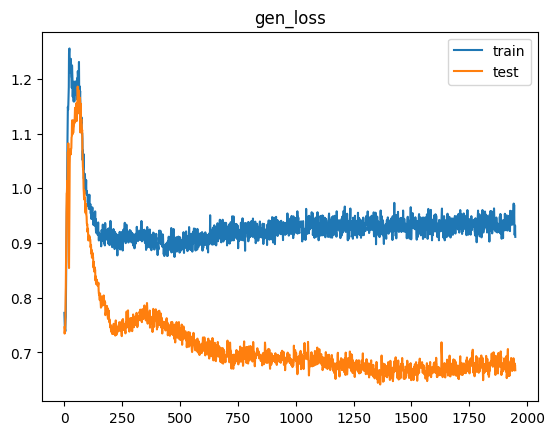

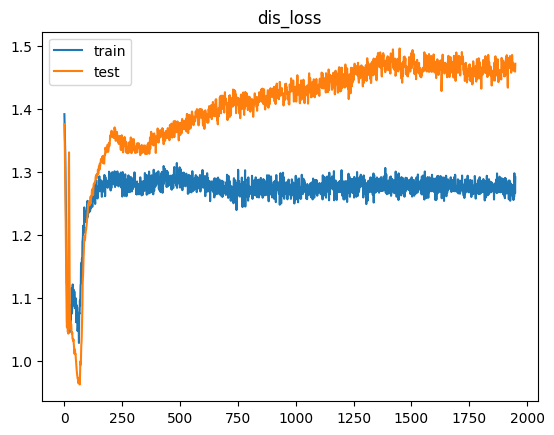

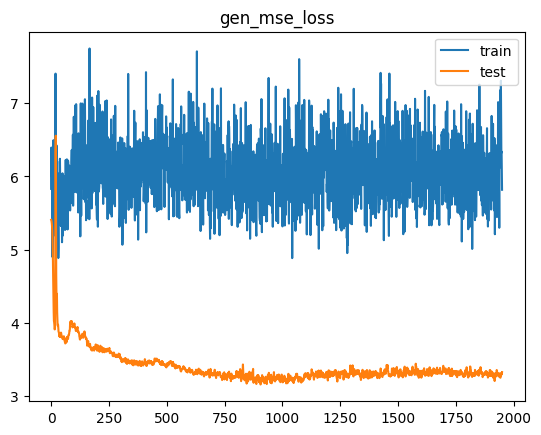

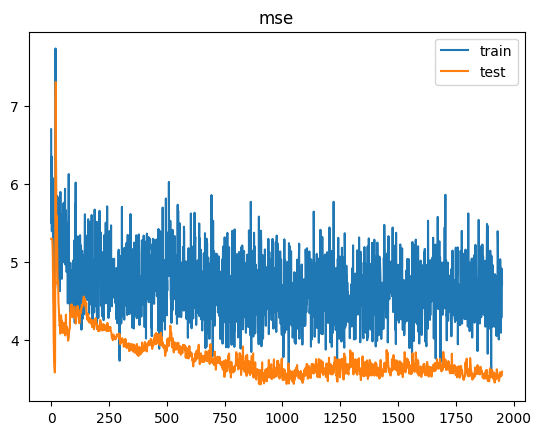

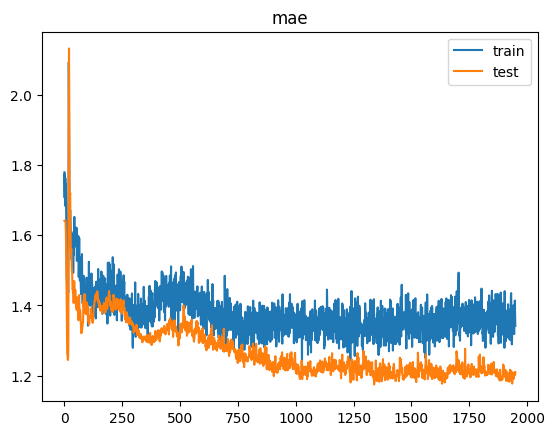

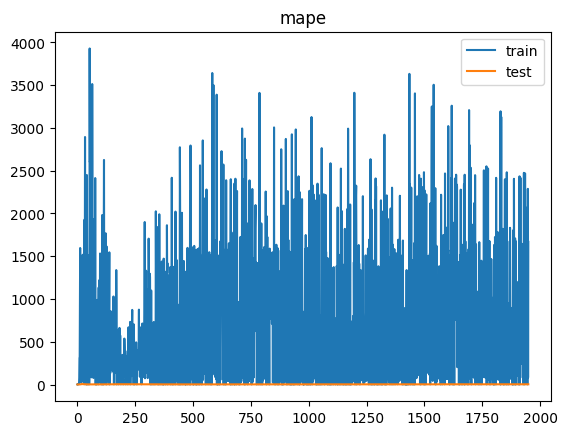

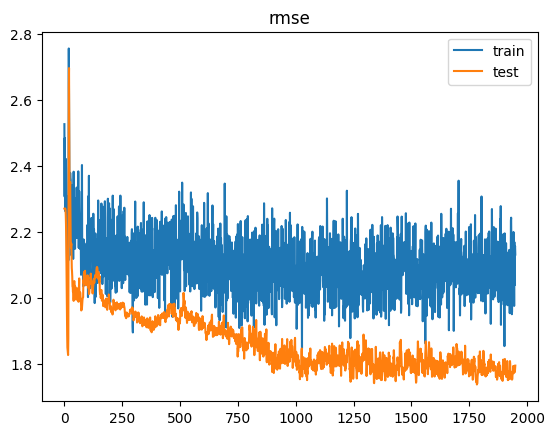

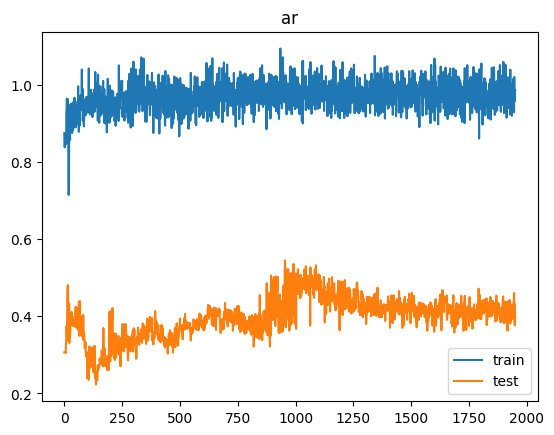

2/2 [==============================] - 0s 4ms/step


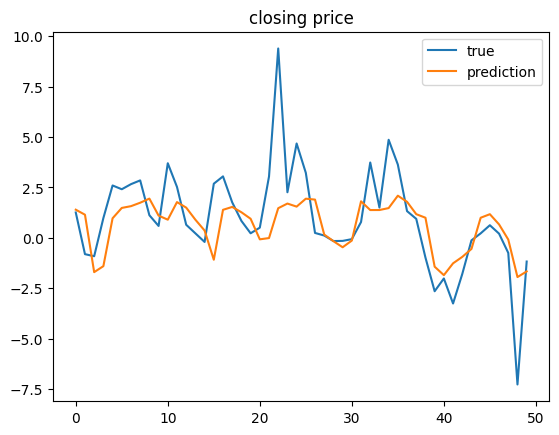

[MSE Baseline] train: 5.1218169489930006  test: 3.676888532616932
Delta time with epochs = 1950: 0:17:19.893042


In [23]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))